In [11]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns 
import math
import random
from scipy.integrate import simps
from sklearn.manifold import TSNE
from scipy.integrate import simps
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from statannot import add_stat_annotation
import scipy.signal
from scipy.stats import exponnorm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lmfit.models import GaussianModel
from lmfit.models import GaussianModel,ExponentialGaussianModel,SkewedGaussianModel,VoigtModel,LorentzianModel,LognormalModel
from scipy.signal import savgol_filter, find_peaks, find_peaks_cwt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import scipy
import pybaselines
import hplc.io
from hplc.quant import Chromatogram

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Arial"
sns.set(font_scale=2)
sns.set_style("white")

In [2]:
def make_entry(csv, sample_name,topfluor_normalization=1): 
    """
    Inputs: HPLC trace (csv), lipid class (string), genetic background (string),multiplier (to make visible int)
    and topfluor (an int representing the amount of topfluor in the sample that is used as a normalization control)
    Outputs: An array of dictionaries for each moment in the hplc trace 
    """
    hplc=[]

    #iterates through the rows of the CSV and adds a dictionary entry for that time point 
    for row in csv.itertuples():
        #iterates through the rows of the CSV and adds a dictionary entry for that time point 
        if isinstance(row[3],str):
            hplc.append({"Time":row[1],"Value":float(row[3].replace(',',''))/topfluor_normalization, "Name":sample_name})
        else: 
            hplc.append({"Time":row[1],"Value":row[3]/topfluor_normalization,  "Name":sample_name})
              

    return hplc 
def low_pass_filter(data, band_limit, sampling_rate) -> np.ndarray:
    
    """
    Applies a low pass FFT filter to a numpy array 
    Inputs: 
        data: numpy array 
        chromatographic data 
        band_limit: int 
        Frequency limit at which data is cutoff  
        sampling rate: int 
        Number of data points a minute 
    Outputs: 
        np array that has been FFTed 
    """
    cutoff_index = int(band_limit * data.size / sampling_rate)
    F = np.fft.rfft(data)
    F[cutoff_index + 1:] = 0
   
    return np.fft.irfft(F, n=data.size).real
def remove_noise(data, band_limit=2000,lamba=1e10,smoothing=20, sampling_rate=500):
    """
    Denoises chromatographic trace with high-pass (pybaselines) and low-pass (low_pass_filter FFT) filters 
    Inputs: 
        Data: numpy array with signal 
        Band-limit (int): Frequency cutoff for FFT
        Sampling-rate (int): Max Frequency that's measured (500/s for our machine)
        lamba (int): smoothing function for whitaker 
    
    Outputs:
        z numpy array with transformed signal 
    """
    k=pybaselines.whittaker.psalsa(data,lam=lamba)[0]
    data=data-k
    z=low_pass_filter(data,band_limit,sampling_rate)
    z=np.convolve(z, np.ones(smoothing)/smoothing, mode='same')
    return z

def model_n_expgaus(x,y,number_peaks,peak_locations,peak_heights,gamma_min=0.01,gamma_max=5,gamma_center=2.5,peak_variation=0.5,
                    sigma_min=0.01,sigma_max=2,sigma_center=0.1,height_scale=0.3,height_scale_high=1.1):
    """
    Fits n expoential gaussians to chromatographic data and returns list of parameters and the area of each peak 
    Inputs:
        x: Time axis, list 
        y: CAD, FLD axis, list
        number_peaks: Number of peaks, int 
        peak_locations: locations of peaks along x axis, float 
        peak_heights: Value on y axis of each peak, float 
        
        gamma_min: float: 
            mimimum value of gamma for exponential gaussian fit (see lmfit documentation)
        gamma_max: float: 
            maximum value of gamma for exponential gaussian fit (see lmfit documentation)
        gamma_center: float: 
            initial guess of value of gamma for exponential gaussian fit (see lmfit documentation)
        peak_variation: float 
            max variation of center for exponential gaussian fits 
        sigma_min: float 
            min sigma for exponential gaussian fits 
        sigma_max: float 
            max sigma for exponential gaussian fits 
        sigma_center: float 
            guess for sigma for exponential gaussian fits 
        height_scale: float 
            minimum amplitude for exponential gaussian fits 
        height_scale_high: float 
            maximum amplitude for exponential gaussian fits
    Outputs: Array of tuples (parameters, area). Tuples are define each peak, and each row in the array is an individual peak 
    
    
    Prints(optional): 
        Summary graphs 
        1. Peak identification 
        2. Intial Fit 
        3. Final Fit+ individual chromatographs 
    """
  
    #goes from max to min number of peaks, finds bic, removes smallest peak, repeat 
    model=''
    for n in range(0,number_peaks):
        gaus=ExponentialGaussianModel(prefix='p'+str(n)+"_")
        #addition of first model for first peak
        if model=='':
            model=gaus
            pars=gaus.make_params(prefix='p'+str(n)+"_")
            #peak locations can vary by 1 min 
            pars['p'+str(n)+'_center'].set(value=peak_locations[n],min=peak_locations[n]-peak_variation,max=peak_locations[n]+peak_variation)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=sigma_center, min=sigma_min,max=sigma_max)
            #amplitude can only be so small to be a real peak. Height correction from Amplitude to height is roughly /gamma~2  
            pars['p'+str(n)+'_amplitude'].set(value=peak_heights[n]/2, min=height_scale*peak_heights[n],max=peak_heights[n]*height_scale_high)
            pars['p'+str(n)+'_gamma'].set(value=gamma_center,max=gamma_max,min=gamma_min)
        #all subsequent peaks    
        else:
            model+=gaus
            pars.update(gaus.make_params(prefix='p'+str(n)+"_"))
            pars['p'+str(n)+'_center'].set(value=peak_locations[n],min=peak_locations[n]-peak_variation,max=peak_locations[n]+peak_variation)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=sigma_center, min=sigma_min,max=sigma_max)
            #amplitude can only be so small to be a real peak Height correction from Amplitude to height is roughly /gamma~2  
            pars['p'+str(n)+'_amplitude'].set(value=peak_heights[n]/2, min=height_scale*peak_heights[n],max=peak_heights[n]*height_scale_high)
            pars['p'+str(n)+'_gamma'].set(value=gamma_center,max=gamma_max,min=gamma_min)
    #Uses gradient descent to best fit model 
    try:
        out = model.fit(y, pars, x=x)
    except AttributeError:
        return None


    



    comps=out.eval_components(x=x) 
    
    #plots each peak 
    areas=[]
    for n in range(0,number_peaks):
        area=sum(comps['p'+str(n)+"_"])*0.01
        center=out.params['p'+str(n)+"_center"].value
        sigma=out.params['p'+str(n)+"_sigma"].value
        amplitude=out.params['p'+str(n)+"_amplitude"].value
        gamma=out.params['p'+str(n)+"_gamma"].value
        areas.append([center,sigma,amplitude, gamma,area])
    
    return(areas)
def graph_n_expgaus(x,y,number_peaks,parameters):
    """
    Combines multiple exponential gaussian fits together to create graph output 
    Inputs: 
        x, y: array
        time and variable series respectively 
        number_peaks: int 
        number of peaks in the sample 
        parameters: list of lists containing the parameters for each exponential gaussian 

    Prints: 
        Summary graphs Final Fit+ individual chromatographs 
    Returns: 
        Nothing
    """
  
 
    
    model=''
    for n in range(0,number_peaks):
        gaus=ExponentialGaussianModel(prefix='p'+str(n)+"_")
        #addition of first model for first peak
        if model=='':
            model=gaus
            pars=gaus.make_params(prefix='p'+str(n)+"_")
            #peak locations can vary by 1 min 
            pars['p'+str(n)+'_center'].set(value=parameters[n][0],vary=False)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=parameters[n][1],vary=False)
            #amplitude can only be so small to be a real peak 
            pars['p'+str(n)+'_amplitude'].set(value=parameters[n][2],vary=False)
            pars['p'+str(n)+'_gamma'].set(value=parameters[n][3],vary=False)
        #all subsequent peaks    
        else:
            model+=gaus
            pars.update(gaus.make_params(prefix='p'+str(n)+"_"))
            pars['p'+str(n)+'_center'].set(value=parameters[n][0],vary=False)
            pars['p'+str(n)+'_sigma'].set(value=parameters[n][1],vary=False)
            pars['p'+str(n)+'_amplitude'].set(value=parameters[n][2],vary=False)
            pars['p'+str(n)+'_gamma'].set(value=parameters[n][3],vary=False)
            #intial fit 
    init = model.eval(pars, x=x)
    #to get best fit 
    out = model.fit(y, pars, x=x)


 







    comps=out.eval_components(x=x) 
   

    fig, axes = plt.subplots(2, 1, figsize=(25, 10))
    plt.style.use("dark_background")

    #plots underlying data
    axes[0].plot(x, y)
    #plots initial fit in orange with dashed line 
    axes[0].plot(x, init, '--', label='initial fit')
    #plots best fit in green with solid line 
    axes[0].plot(x, out.best_fit, '-', label='best fit')
    axes[1].plot(x, out.best_fit, '-', label='best fit')
    axes[0].legend()

    #find the components of the best fit curve 
    #plots underlying data 
    plt.style.use("dark_background")
    axes[1].plot(x, y)
    areas=[]
    #plots each peak 
    for n in range(0,number_peaks):
        axes[1].plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n))
        axes[1].fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.5) 
        #adds peak location on the actual output graph 
        axes[1].text(out.params['p'+str(n)+"_center"].value, out.params['p'+str(n)+"_amplitude"].value+1, str(out.params['p'+str(n)+"_center"].value)[0:5], fontsize=8,horizontalalignment='center')
    return areas
def find_locations_peaks(x,y,peak_prominence_cutoff,height_cutoff,graph=False,shoulder=False, shoulder_cutoffs=None):
    """
    

    Parameters
    ----------
    x : List of floats 
        Time axis 
    y : List of floats 
        Signal axis
    peak_prominence_cutoff : float
        Value at which to cut off prominence. Prominences below this value are not accepted as real peaks 
    height_cutoff : float 
        Value at which to cut off peak height. Heights below this value are not accepted as real peaks 
    graph : Bool, optional
        Whether to graph peak locations or not . The default is False.
    shoulder : Bool, optional
        Whether or not to include shoulders in the peak analysis. The default is False.
    shoulder_cutoffs : Float, optional
        Shoulder prominence cut off value (first derivative). Shoulders below this value are not included  The default is None.

    Returns
    -------
    time: list of floats 
    list of peak times 
    
    heights: list of floats 
    list of peak heights (index is the same as time )
    """
    
    #Finds time averaged derivative
    data=pd.DataFrame()
    data["Time"]=x
    data["Value"]=y
    #smooths the data with a savgol filter and taeks first dderivative 
    data.loc[:, 'Smoothed']=savgol_filter(y, window_length=101, polyorder=3, deriv=0)
    data.loc[:, 'Time Ave']=savgol_filter(y, window_length=101, polyorder=3, deriv=1)
    #data.loc[:, 'Time Ave']+=min(data.loc[:, 'Time Ave'])
    if graph:
        fig,ax=plt.subplots(2,1,figsize=(15,10))
        #plots derivative 
        sns.lineplot(x=data['Time'], y=data['Smoothed'], label='Smoothed',ax=ax[0])
    data["Inverse Smoothed"]=data.loc[:,'Smoothed']*-1+max(data.loc[:, 'Smoothed'])
    data["Inverse Time Ave"]=data.loc[:,'Time Ave']*-1+max(data.loc[:, 'Time Ave'])
    data["Moved Time Ave"]=data.loc[:,'Time Ave']+abs(min(data.loc[:, 'Time Ave']))
    
    if graph:
        sns.lineplot(x=data['Time'], y=data['Time Ave'], label='Time Averaged First Derivative',ax=ax[1])
    #finds peaks from the time averaged derivative. These are really inflection points not actually peaks, but this
    #method will correctly identify shoulders
    #finds real peaks 
    peaks = find_peaks(data['Smoothed'],prominence=peak_prominence_cutoff,height=height_cutoff)[0]
    peaks2 = find_peaks(data['Moved Time Ave'],prominence=peak_prominence_cutoff/5,height=height_cutoff/5)[0]
    valleys2 = find_peaks(data['Inverse Time Ave'],prominence=peak_prominence_cutoff/5,height=height_cutoff/5)[0]
    shoulder_times=[]
    for potential_shoulder in peaks2: 

        if data["Time Ave"].values[potential_shoulder]>=0:
            pass 
        else:
            shoulder_times.append(potential_shoulder)
    for potential_shoulder in valleys2: 

        if data["Time Ave"].values[potential_shoulder]<=0:
            pass 
        else:
            shoulder_times.append(potential_shoulder)
    #plots IDed peaks on the underlying data 
    if graph:
        sns.scatterplot(x=data["Time"].values[peaks], y=data["Smoothed"].values[peaks], s = 55,
                 label = 'Peak Centers',ax=ax[0])
        if shoulder:
            sns.scatterplot(x=data["Time"].values[peaks], y=data["Smoothed"].values[peaks], s = 55,
                     label = 'Peak Centers',ax=ax[0])
            
        plt.show()
    
    times=data["Time"].values[peaks]
    heights=data["Value"].values[peaks]
    
    if shoulder:
        for peak in shoulder_times:
            np.append(peaks,peak)
        
        
    

    heights=data["Value"].values[peaks]
        
    
    
    
    #converts reference peaks into the time domain (rather than index )
    return times,heights
def find_peak_windows(x,y,reference_peak_list,heights,start,end):
    """
    

    Parameters
    ----------
    x : List of floats 
        TIME SERIES 
    y : List of floats 
        VALUE SERIES
    reference_peak_list : list of floats
        List of peak locations 
    heights : list of floats 
        List of peak heights 
    start : int or float
        Start time of series 
    end : int or float
       End time of series 

    Returns
    -------
    windows : list of three variables for each window
        Locations: all peaks in window 
        Heights: heights of all peaks in window
        Bounds: start and end location of window 

    """
    windows=[]
    indices=[start]
    #finds all zeroes in graph 
    for i,j in zip(y,x): 
        if i<=0:
            indices.append(j)
    current_window=[]
    current_height=[]
    current_loc=[]
    
    current_index=0
    #starts lower bound at current index 
    bounds=[indices[current_index]]
    #iterates through all peaks and heights 
    for loc,height in zip(reference_peak_list,heights):
        inwindow=False
        while inwindow==False:
            #add peak to current window
            if loc<indices[current_index]:
                current_loc.append(loc)
                current_height.append(height)
                inwindow=True
           #once you're beyond index end of the window, break window 
            else:
                current_index+=1
                if current_loc!=[]:
                    bounds.append(indices[current_index])
                    current_window=[current_loc,current_height,bounds]
                    windows.append(current_window)
                    current_window=[]
                    current_height=[]
                    current_loc=[]
                    bounds=[indices[current_index]]
    #end final window 
    bounds.append(end)
    current_window=[current_loc,current_height,bounds]
    windows.append(current_window)
    
        

    return windows 
def find_peak_areas(single_rep,start,end,canonical_peaks=None,graph=False,shoulder=False,prominence_cutoff=0.05,height_cutoff=1,gamma_min=0.01,gamma_max=5,gamma_center=2.5,peak_variation=0.5,
                    sigma_min=0.01,sigma_max=2,sigma_center=0.1,height_scale=0.1,height_scale_high=1.1):
    """
    

    Parameters
    ----------
    single_rep : pandas dataframe
        dataframe containing only time/value information of the replicate of interest 
    start : int or float
        start time of the region of interest 
    end : int or float
        end time of the region of interest
    canonical_peaks : list of floats, optional
        List of canonical peaks (on the time axis). The default is None.
    graph : BOOL, optional
        Whether or not to graph outputs. The default is False.
    shoulder : Bool, optional
        Whether or not to include shoulders in graph. The default is False.
    prominence_cutoff: float 
        minimum prominence to define a single peak 
    height_cutoff: flaot 
        mimimum height to define a single peak 
    gamma_min: float: 
        mimimum value of gamma for exponential gaussian fit (see lmfit documentation)
    gamma_max: float: 
        maximum value of gamma for exponential gaussian fit (see lmfit documentation)
    gamma_center: float: 
        initial guess of value of gamma for exponential gaussian fit (see lmfit documentation)
    peak_variation: float 
        max variation of center for exponential gaussian fits 
    sigma_min: float 
        min sigma for exponential gaussian fits 
    sigma_max: float 
        max sigma for exponential gaussian fits 
    sigma_center: float 
        guess for sigma for exponential gaussian fits 
    height_scale: float 
        minimum amplitude for exponential gaussian fits 
    height_scale_high: float 
        maximum amplitude for exponential gaussian fits 

    Returns
    -------
    locs : list of floats 
        Peak locations 
    f_areas : list of floats 
        Peak areas, matched to peak locations by index 

    """
    #makes time axis 
    x=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Time']
    #makes value axis 
    y=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Value']
    #denoises y-axis 
    y=remove_noise(y)
    

    # if there are no input peaks, find peaks 
    if canonical_peaks is None:
        reference_peak_list,heights=find_locations_peaks(x,y,prominence_cutoff,height_cutoff,graph=graph,shoulder=shoulder)
    #else just use canonical peaks 
    else:
        reference_peak_list=canonical_peaks
   
    areas=[]
    #find peak windows to improve runtime 
    windows=find_peak_windows(x,y,reference_peak_list,heights,start,end)
    df=pd.DataFrame()
    df['Time']=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Time']
    df['y']=single_rep.loc[(single_rep['Time']>=start) & (single_rep['Time']<=end)]['Value']
    df['denoised_y']=remove_noise(y, band_limit=2000,lamba=1e10,smoothing=20, sampling_rate=500)

    #goes through each window and finds area for each 
    for window in windows:
        print(window)
        locs=window[0]
        heights=window[1]
        bounds=window[2]
        sub_x=df.loc[(df['Time']>=bounds[0]) & (df['Time']<bounds[1])]['Time']
        sub_y=df.loc[(df['Time']>=bounds[0]) & (df['Time']<bounds[1])]['denoised_y']
        area=model_n_expgaus(sub_x,sub_y,len(locs),locs,heights,gamma_min,gamma_max,gamma_center,peak_variation,sigma_min,sigma_max,sigma_center,height_scale,height_scale_high)
        areas+=area
    #graphs if required 
    if graph:
        print(areas)
        graph_n_expgaus(x,y,len(areas),areas)
    locs=[]
    f_areas=[]
    parameters=[]
    for peak in areas:
        locs.append(peak[0])
        parameters.append(peak[0:4])
        f_areas.append(peak[4])
    return locs,f_areas,parameters




In [3]:
#import raw text files 


ara_alone10=pd.read_csv("injections_too_close_data/6_9_23_injection/10_0_0_09_CAD_1.txt",skiprows=range(0, 42),sep="\t")
ara_alone5=pd.read_csv("injections_too_close_data/6_9_23_injection/5_0_0_10_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone10=pd.read_csv("injections_too_close_data/6_9_23_injection/0_10_0_08_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone5=pd.read_csv("injections_too_close_data/6_9_23_injection/0_5_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone10=pd.read_csv("injections_too_close_data/6_9_23_injection/0_0_10_06_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone5=pd.read_csv("injections_too_close_data/6_9_23_injection/0_0_5_07_CAD_1.txt",skiprows=range(0, 42),sep="\t")

ara_alone10_2=pd.read_csv("injections_too_close_data/1_2_24_injection/1_0_0_03_CAD_1.txt",skiprows=range(0, 42),sep="\t")
ara_alone5_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0.5_0_0_02_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone10_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0_1_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone5_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0_0.5_0_04_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone10_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0_0_1_07_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone5_2=pd.read_csv("injections_too_close_data/1_2_24_injection/0_0_0.5_06_CAD_1.txt",skiprows=range(0, 42),sep="\t")

ara_alone10_3=pd.read_csv("1_9_24_rerun/1_0_0_03_CAD_1.txt",skiprows=range(0, 42),sep="\t")
ara_alone5_3=pd.read_csv("1_9_24_rerun/0.5_0_0_02_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone10_3=pd.read_csv("1_9_24_rerun/0_1_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone5_3=pd.read_csv("1_9_24_rerun/0_0.5_0_04_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone10_3=pd.read_csv("1_9_24_rerun/0_0_1_07_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone5_3=pd.read_csv("1_9_24_rerun/0_0_0.5_06_CAD_1.txt",skiprows=range(0, 42),sep="\t")

ara_alone10_4=pd.read_csv("1_10_rerun/1_0_0_03_CAD_1.txt",skiprows=range(0, 42),sep="\t")
ara_alone5_4=pd.read_csv("1_10_rerun/0.5_0_0_02_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone10_4=pd.read_csv("1_10_rerun/0_1_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone5_4=pd.read_csv("1_10_rerun/0_0.5_0_04_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone10_4=pd.read_csv("1_10_rerun/0_0_1_07_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone5_4=pd.read_csv("1_10_rerun/0_0_0.5_06_CAD_1.txt",skiprows=range(0, 42),sep="\t")

ara_alone10_5=pd.read_csv("1_24_24 rerim/1_0_0_03_CAD_1.txt",skiprows=range(0, 42),sep="\t")
ara_alone5_5=pd.read_csv("1_24_24 rerim/0.5_0_0_02_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone10_5=pd.read_csv("1_24_24 rerim/0_1_0_05_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_alone5_5=pd.read_csv("1_24_24 rerim/0_0.5_0_04_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone10_5=pd.read_csv("1_24_24 rerim/0_0_1_07_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_alone5_5=pd.read_csv("1_24_24 rerim/0_0_0.5_06_CAD_1.txt",skiprows=range(0, 42),sep="\t")

la_spike3=pd.read_csv("1_24_24 rerim/0.5_0.5_1_11_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_spike2=pd.read_csv("1_10_rerun/0.5_0.5_1_11_CAD_1.txt",skiprows=range(0, 42),sep="\t")
la_spike1=pd.read_csv("1_9_24_rerun/0.5_0.5_1_11_CAD_1.txt",skiprows=range(0, 42),sep="\t")

ara_spike4=pd.read_csv("1_24_24 rerim/1_0.5_0.5 2_13_CAD_1.txt",skiprows=range(0, 42),sep="\t")
ara_spike3=pd.read_csv("1_24_24 rerim/1_0.5_0.5_09_CAD_1.txt",skiprows=range(0, 42),sep="\t")
ara_spike2=pd.read_csv("1_10_rerun/1_0.5_0.5_09_CAD_1.txt",skiprows=range(0, 42),sep="\t")
ara_spike1=pd.read_csv("1_9_24_rerun/1_0.5_0.5_09_CAD_1.txt",skiprows=range(0, 42),sep="\t")

dha_spike3=pd.read_csv("1_24_24 rerim/0.5_1_0.5_10_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_spike2=pd.read_csv("1_10_rerun/0.5_1_0.5_10_CAD_1.txt",skiprows=range(0, 42),sep="\t")
dha_spike1=pd.read_csv("1_9_24_rerun/0.5_1_0.5_10_CAD_1.txt",skiprows=range(0, 42),sep="\t")

equal4=pd.read_csv("1_24_24 rerim/0.5_0.5_0.5 2_12_CAD_1.txt",skiprows=range(0, 42),sep="\t")
equal3=pd.read_csv("1_24_24 rerim/0.5_0.5_0.5_08_CAD_1.txt",skiprows=range(0, 42),sep="\t")
equal2=pd.read_csv("1_10_rerun/0.5_0.5_0.5_08_CAD_1.txt",skiprows=range(0, 42),sep="\t")
equal1=pd.read_csv("1_9_24_rerun/0.5_0.5_0.5_08_CAD_1.txt",skiprows=range(0, 42),sep="\t")

hplcs=[]




hplcs+=make_entry(ara_alone10,"ara_alone10")
hplcs+=make_entry(ara_alone5,"ara_alone5")
hplcs+=make_entry(dha_alone10,"dha_alone10")
hplcs+=make_entry(dha_alone10,"dha_alone5")
hplcs+=make_entry(la_alone10,"la_alone10")
hplcs+=make_entry(la_alone5,"la_alone5")

hplcs+=make_entry(ara_alone10_2,"ara_alone10_2")
hplcs+=make_entry(ara_alone5_2,"ara_alone5_2")
hplcs+=make_entry(dha_alone10_2,"dha_alone10_2")
hplcs+=make_entry(dha_alone5_2,"dha_alone5_2")
hplcs+=make_entry(la_alone10_2,"la_alone10_2")
hplcs+=make_entry(la_alone5_2,"la_alone5_2")

hplcs+=make_entry(ara_alone10_3,"ara_alone10_3")
hplcs+=make_entry(ara_alone5_3,"ara_alone5_3")
hplcs+=make_entry(dha_alone10_3,"dha_alone10_3")
hplcs+=make_entry(dha_alone5_3,"dha_alone5_3")
hplcs+=make_entry(la_alone10_3,"la_alone10_3")
hplcs+=make_entry(la_alone5_3,"la_alone5_3")

hplcs+=make_entry(ara_alone10_4,"ara_alone10_4")
hplcs+=make_entry(ara_alone5_4,"ara_alone5_4")
hplcs+=make_entry(dha_alone10_4,"dha_alone10_4")
hplcs+=make_entry(dha_alone5_4,"dha_alone5_4")
hplcs+=make_entry(la_alone10_4,"la_alone10_4")
hplcs+=make_entry(la_alone5_4,"la_alone5_4")

hplcs+=make_entry(ara_alone10_5,"ara_alone10_5")
hplcs+=make_entry(ara_alone5_5,"ara_alone5_5")
hplcs+=make_entry(dha_alone10_5,"dha_alone10_5")
hplcs+=make_entry(dha_alone5_5,"dha_alone5_5")
hplcs+=make_entry(la_alone10_5,"la_alone10_5")
hplcs+=make_entry(la_alone5_5,"la_alone5_5")

hplcs+=make_entry(la_spike3,"la_spike3")
hplcs+=make_entry(la_spike2,"la_spike2")
hplcs+=make_entry(la_spike1,"la_spike1")

hplcs+=make_entry(ara_spike1,"ara_spike1")
hplcs+=make_entry(ara_spike2,"ara_spike2")
hplcs+=make_entry(ara_spike3,"ara_spike3")
hplcs+=make_entry(ara_spike4,"ara_spike4")

hplcs+=make_entry(dha_spike1,"dha_spike1")
hplcs+=make_entry(dha_spike2,"dha_spike2")
hplcs+=make_entry(dha_spike3,"dha_spike3")

hplcs+=make_entry(equal1,"equal1")
hplcs+=make_entry(equal2,"equal2")
hplcs+=make_entry(equal3,"equal3")
hplcs+=make_entry(equal4,"equal4")


hplcz=pd.DataFrame(hplcs)
hplcz

Time     Value         Name
0         0.000000 -1.080855  ara_alone10
1         0.001667 -1.080836  ara_alone10
2         0.003333 -1.080840  ara_alone10
3         0.005000 -1.080863  ara_alone10
4         0.006667 -1.080878  ara_alone10
...            ...       ...          ...
1769711  64.994550  0.031672       equal4
1769712  64.996217  0.036841       equal4
1769713  64.997883  0.046573       equal4
1769714  64.999550  0.053197       equal4
1769715  65.001217  0.043873       equal4

[1769716 rows x 3 columns]

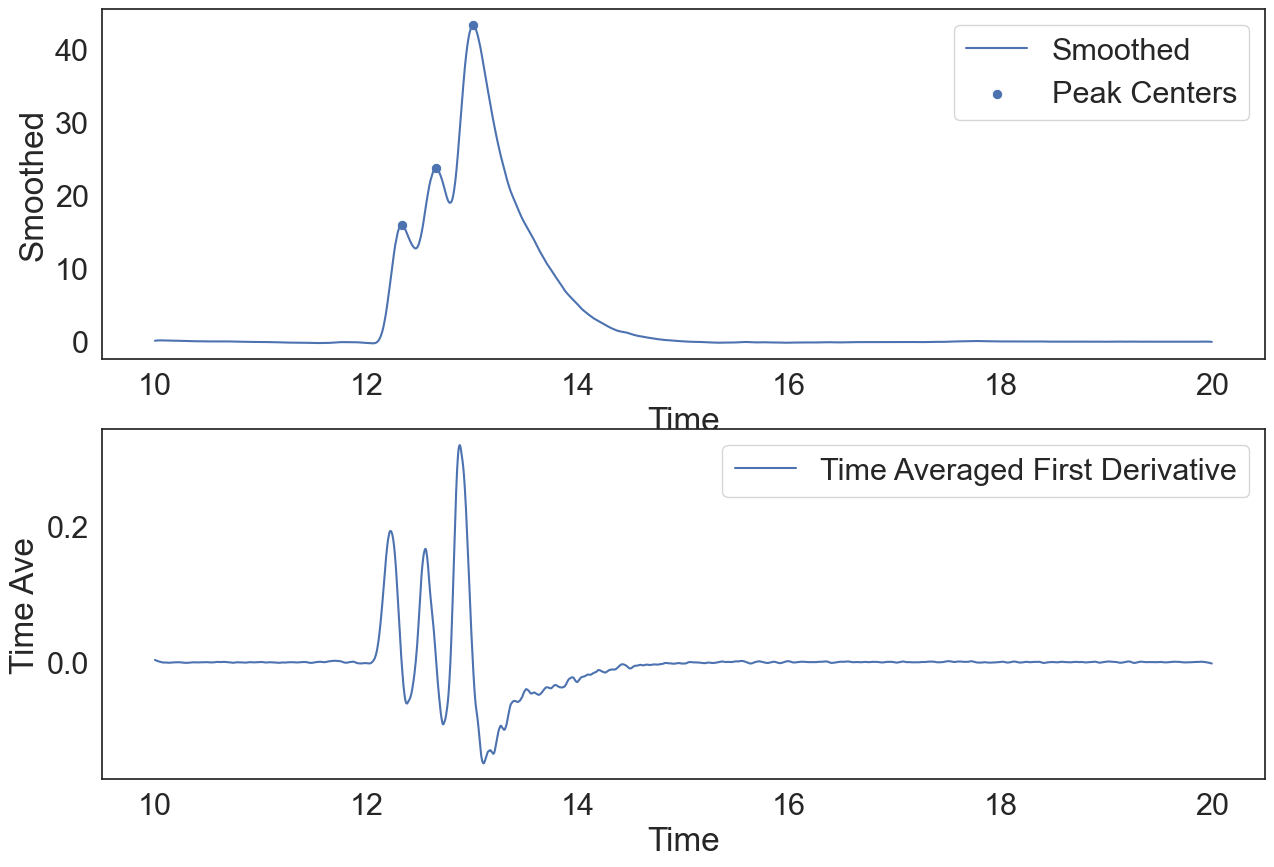

[[12.3358, 12.660967, 13.009667], [16.083282845930675, 23.640386851847733, 42.970716165618356], [10, 20]]
[[12.238760218228341, 0.05835242964547882, 8.425409059365515, 2.5195824653016445, 50.03187250831678], [12.569921935280075, 0.05733222771106755, 8.880163973511923, 2.3959424761207537, 52.737925546630876], [12.912520971810856, 0.06735088328245556, 19.91812984272501, 2.25518750005349, 118.28782250089274]]


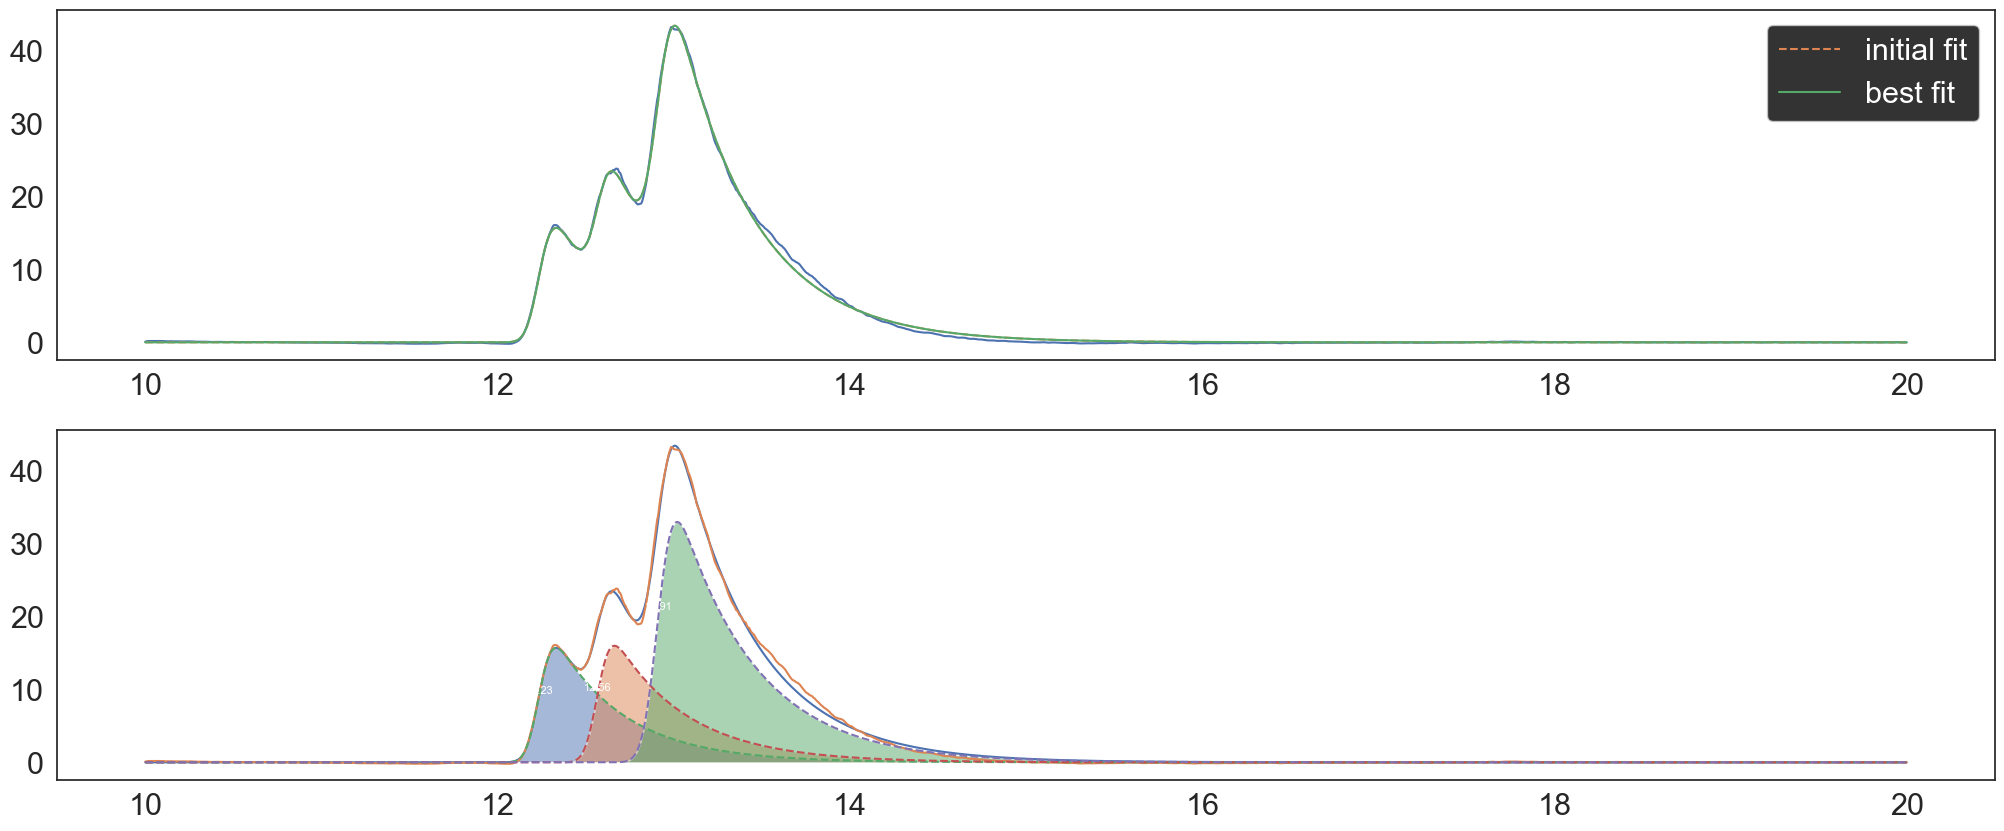

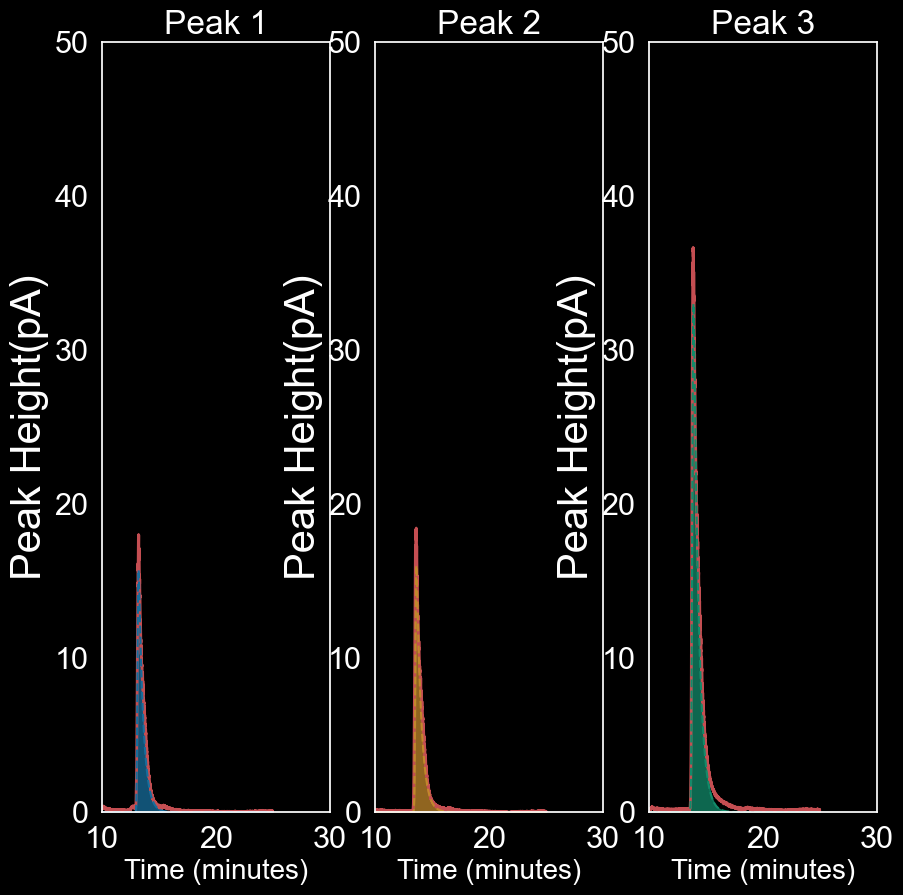

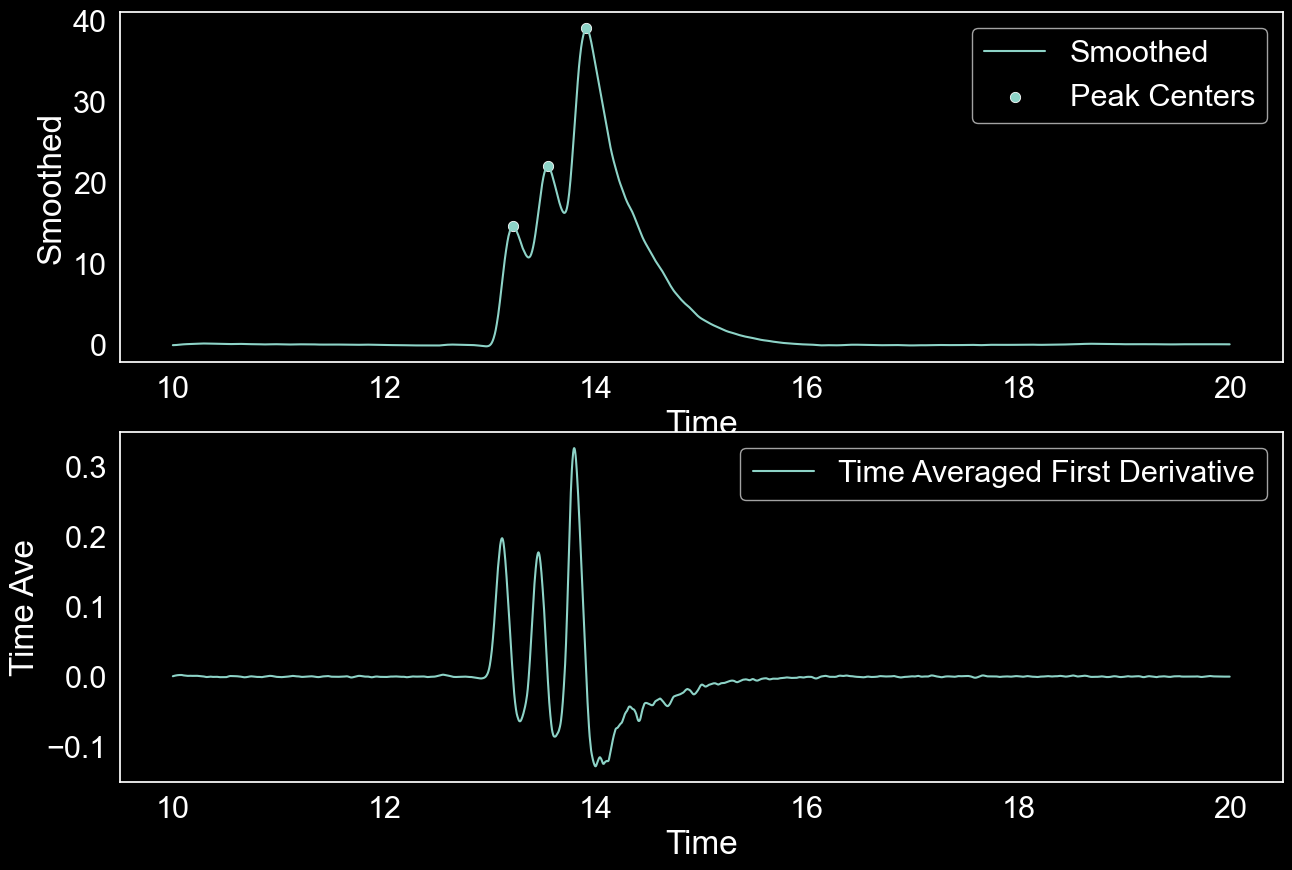

[[13.218967, 13.548933, 13.914483], [14.632010348769128, 22.082599495732804, 38.97952204591731], [10, 20]]
[[13.126440453541557, 0.05352147932869284, 7.244231004769443, 2.665765286551398, 43.02304061228524], [13.466526664263965, 0.05130939303126339, 8.079748398753031, 2.4801421817750335, 47.972308791151534], [13.819517772118846, 0.06217227043772772, 17.803903869036315, 2.2589295839167916, 105.73018126905383]]


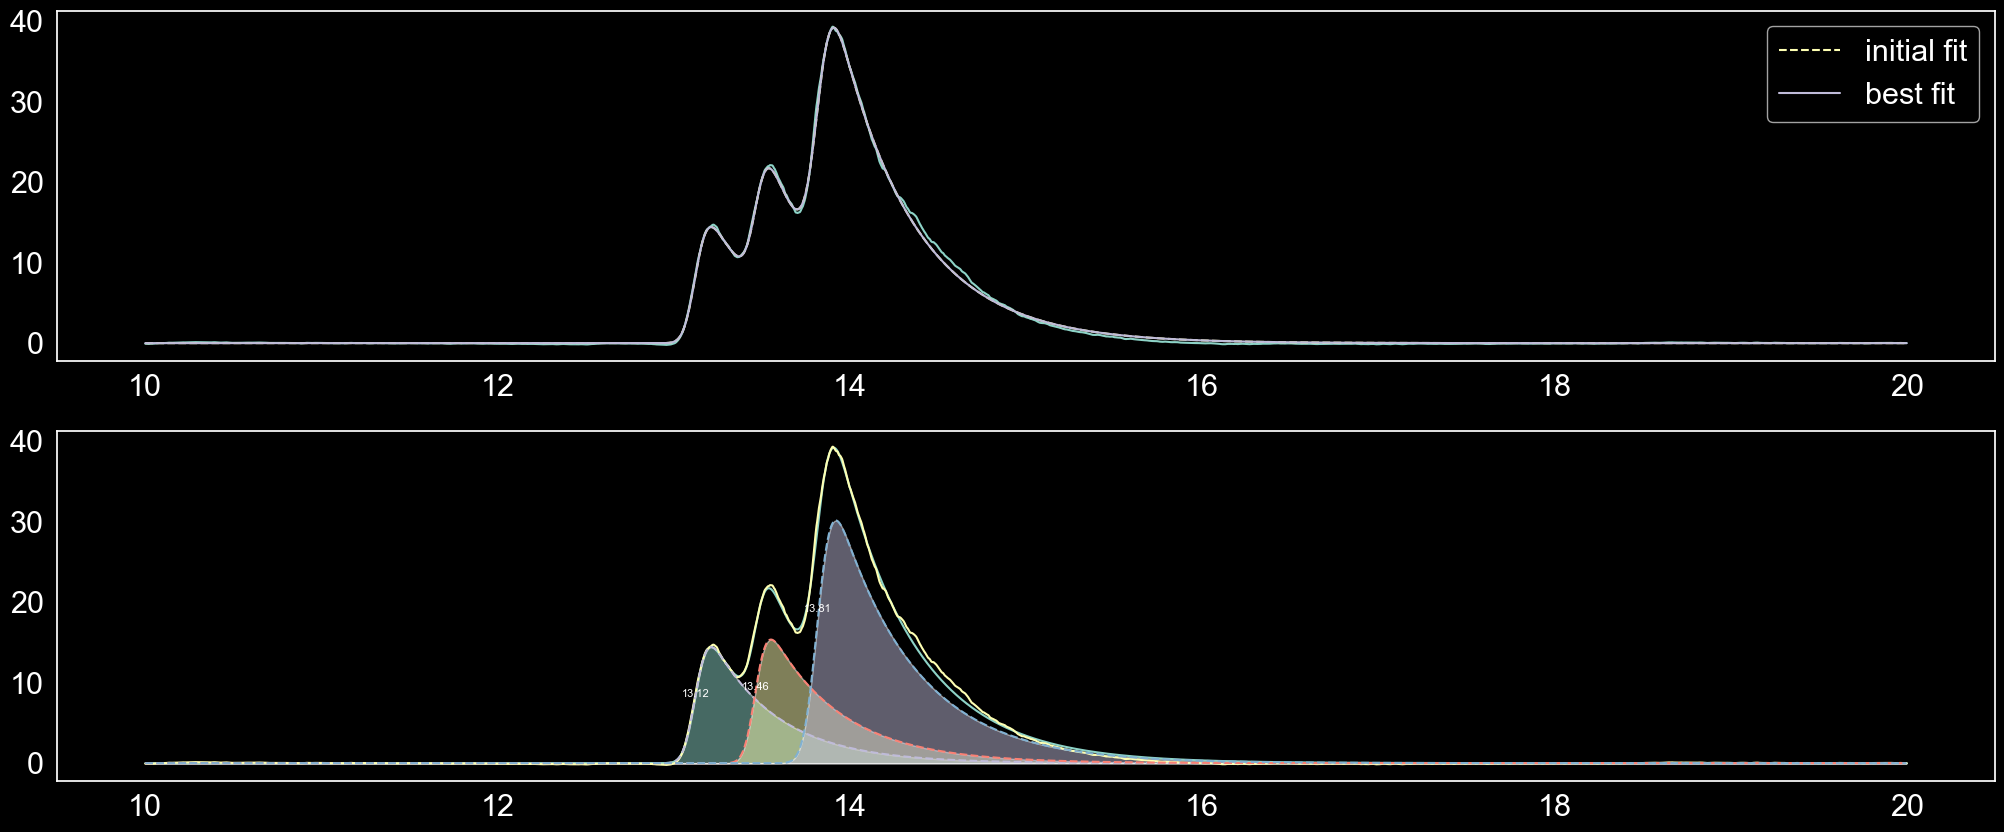

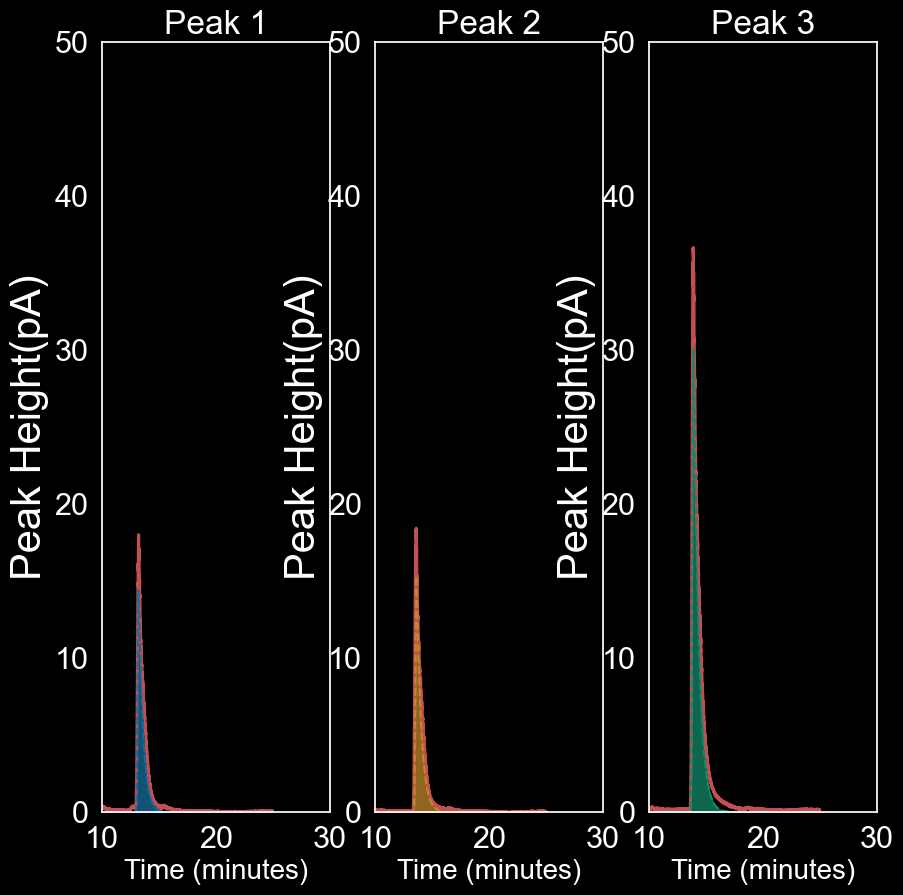

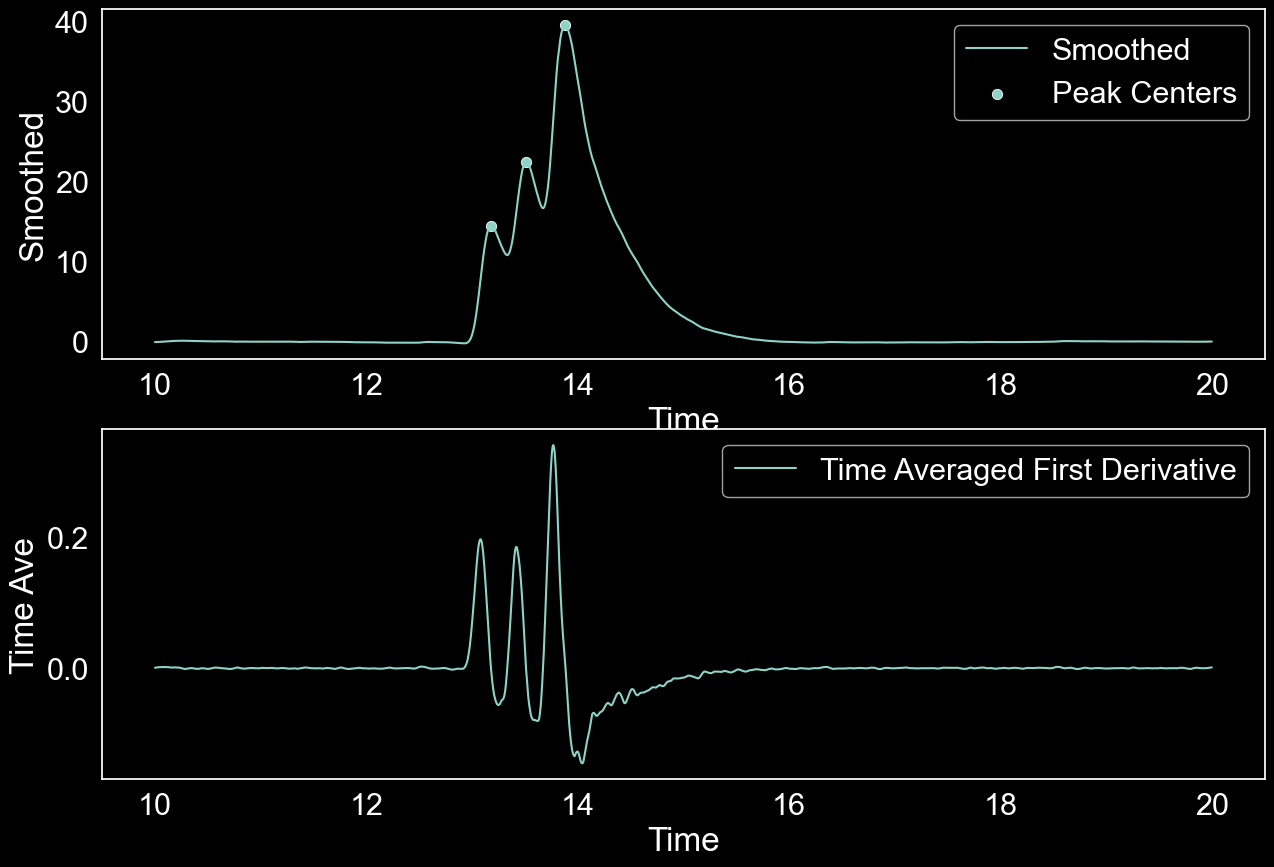

[[13.181567, 13.5112, 13.876533], [14.46843154882653, 22.732295552770914, 39.07342559058333], [10, 20]]
[[13.08956051699451, 0.05365044817935612, 7.441872159696296, 2.564840647516806, 44.1933233440311], [13.432058051043127, 0.05147991111737383, 8.322457625647239, 2.46409276387293, 49.435291445023104], [13.785636145470207, 0.06211926901671205, 17.94275075471653, 2.265348629942839, 106.57776097673786]]


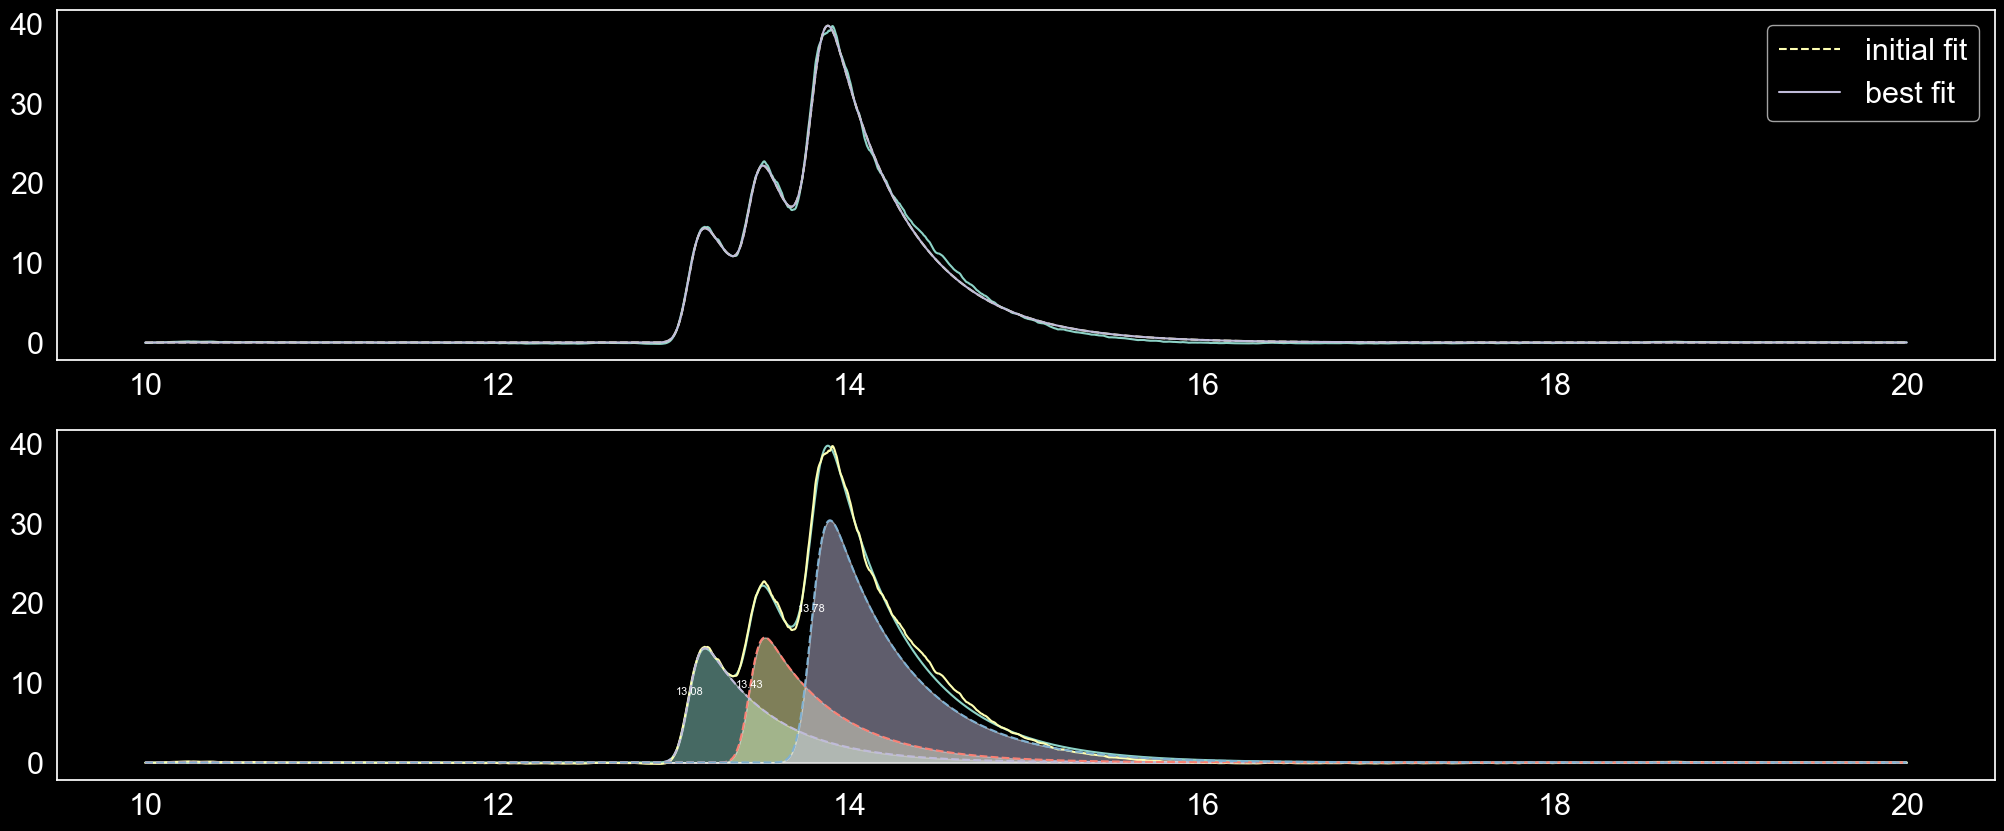

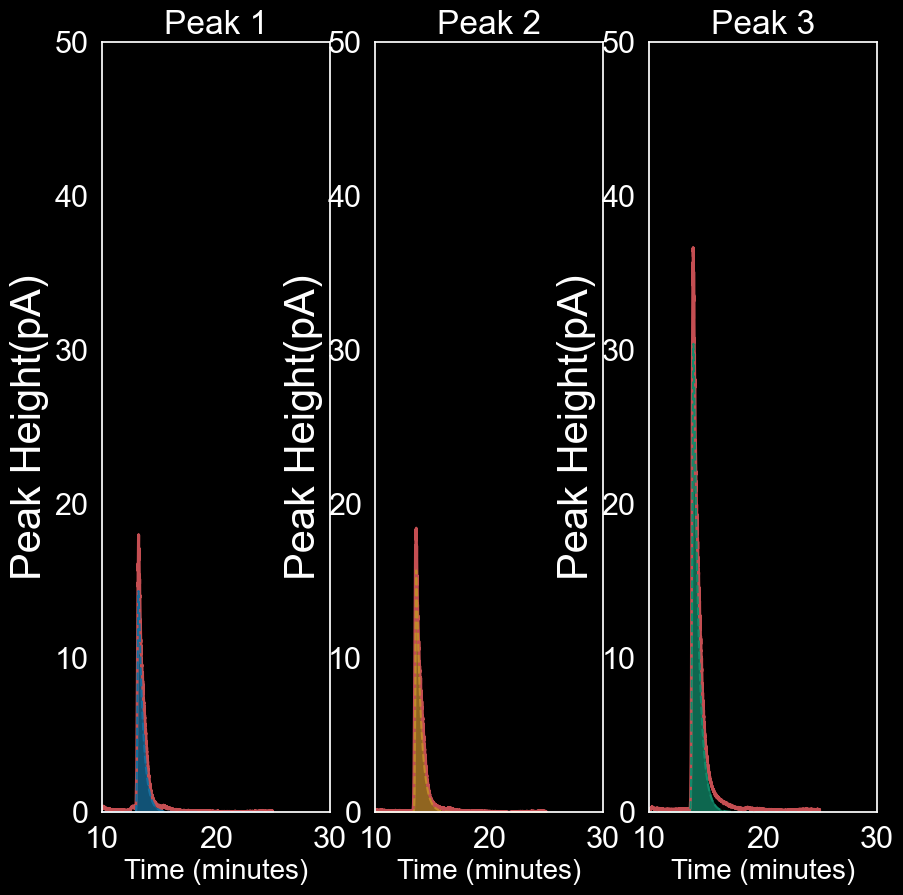

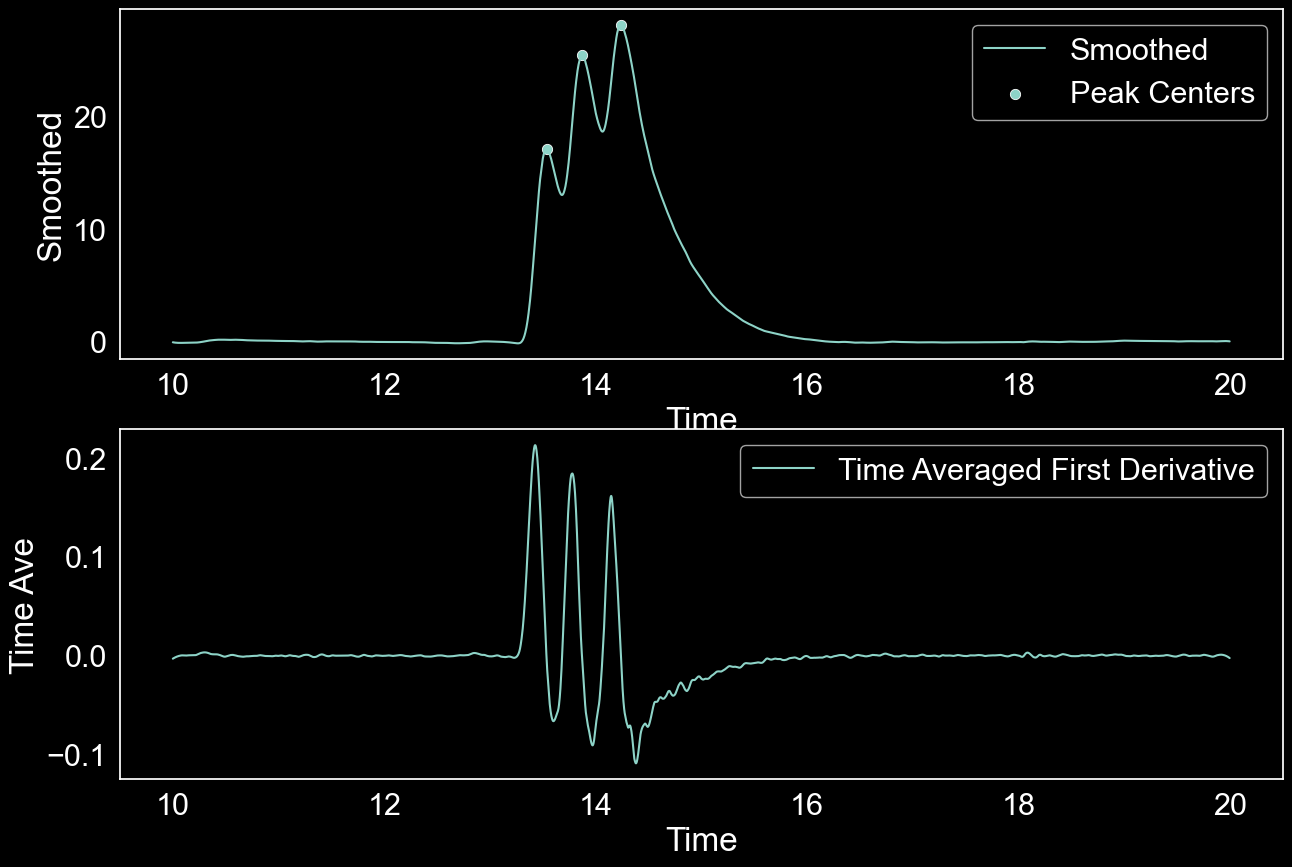

[[13.535867, 13.874417, 14.239917], [17.136934675071082, 25.33799438252613, 28.25516556762487], [10, 20]]
[[13.4388702188207, 0.0591438760197008, 8.68707763670577, 2.6773207307825286, 51.578445642229106], [13.78843430358259, 0.05970940480150595, 10.180061029931329, 2.3853829515594795, 60.43878842054079], [14.1627946722288, 0.06618219306802028, 10.018826006413327, 2.3859239146701126, 59.49521132095035]]


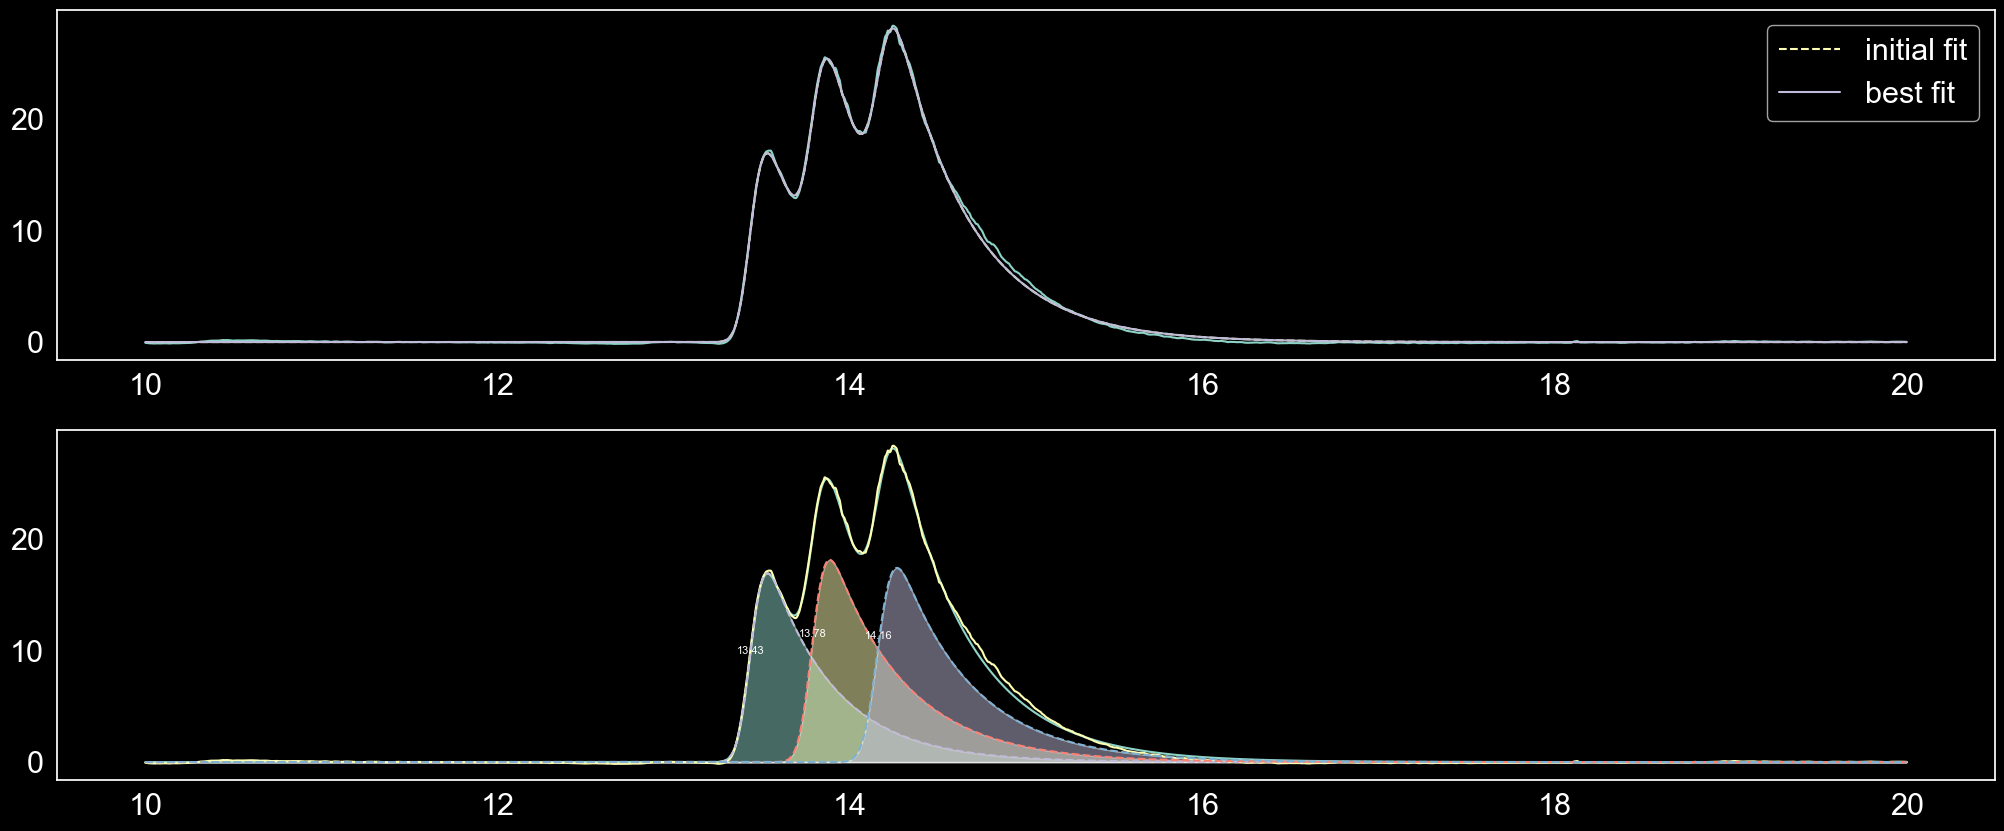

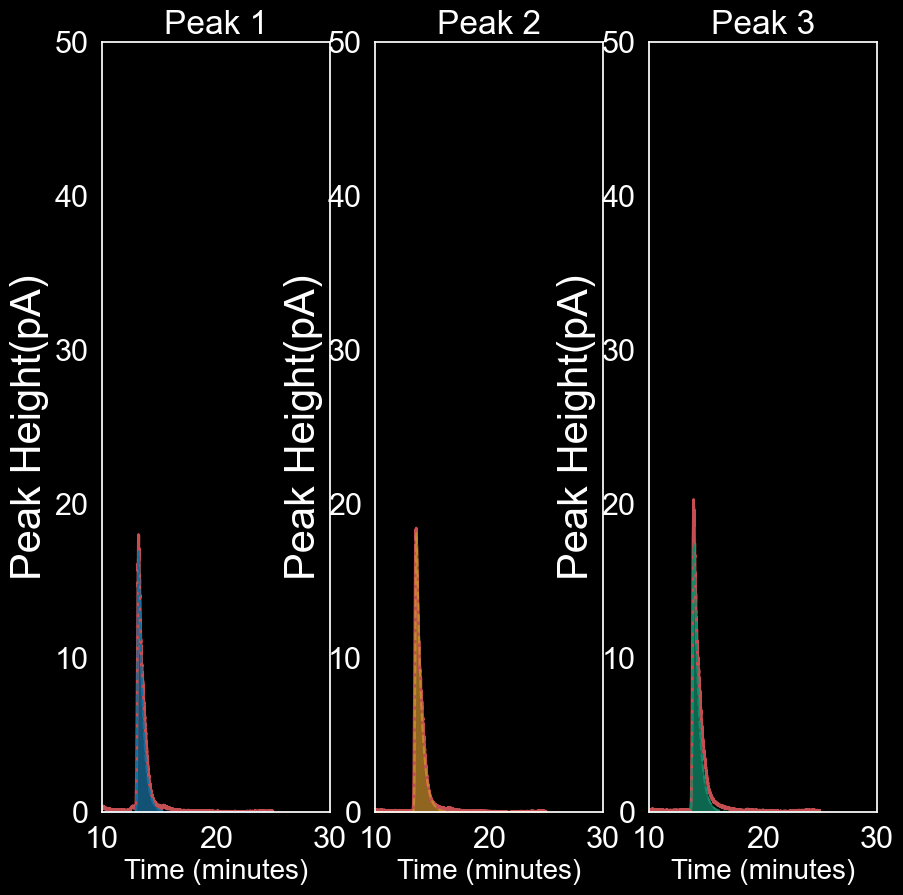

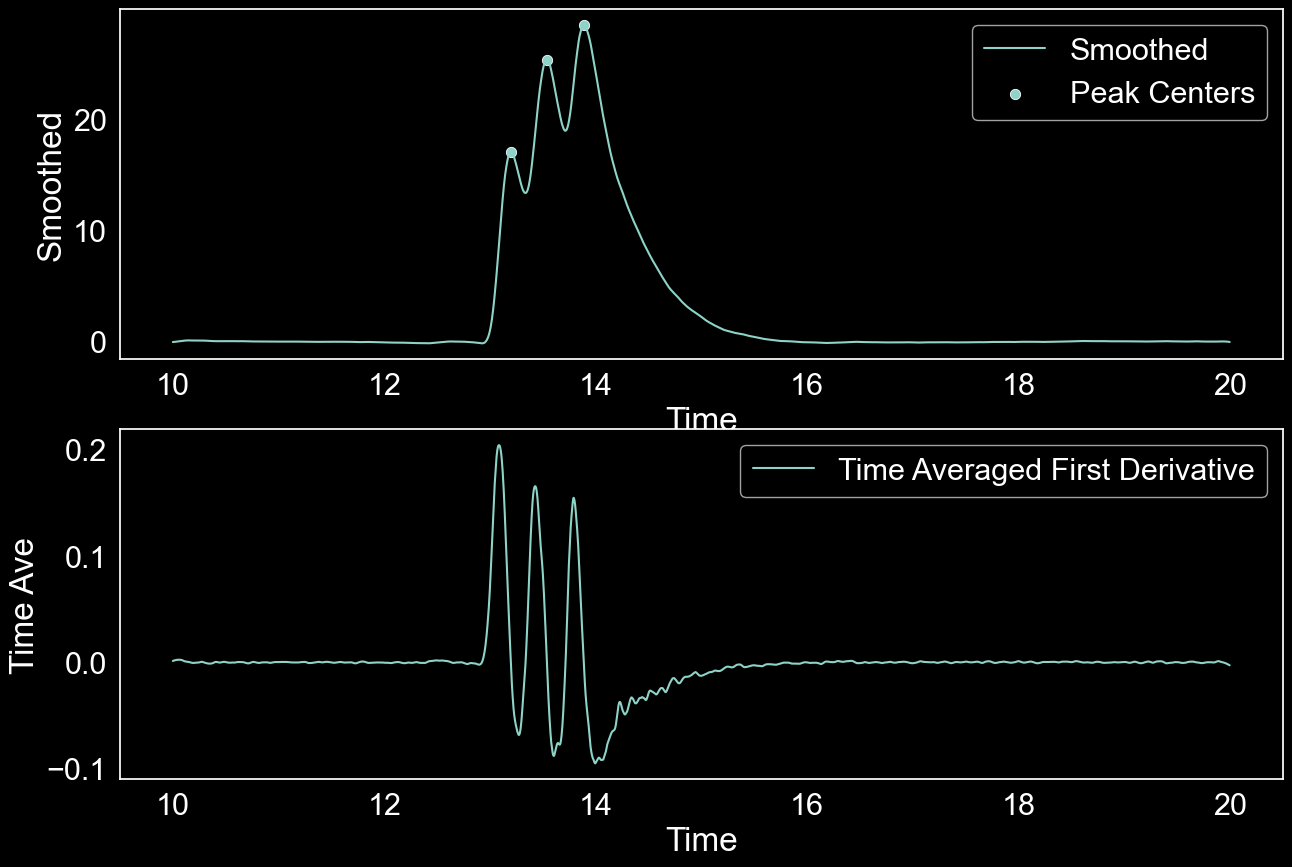

[[13.198267, 13.538483, 13.89065], [16.981159288067275, 25.46327776952422, 28.494265704573245], [10, 20]]
[[13.100636465068648, 0.06030509270826352, 8.583059710664372, 2.73214206333056, 50.947793224840474], [13.44733837688449, 0.06485477090090003, 10.236526274243865, 2.430334083658184, 60.76952405337505], [13.811664173158444, 0.06479127584844903, 10.14478407367646, 2.3556928450793606, 60.23809684320872]]


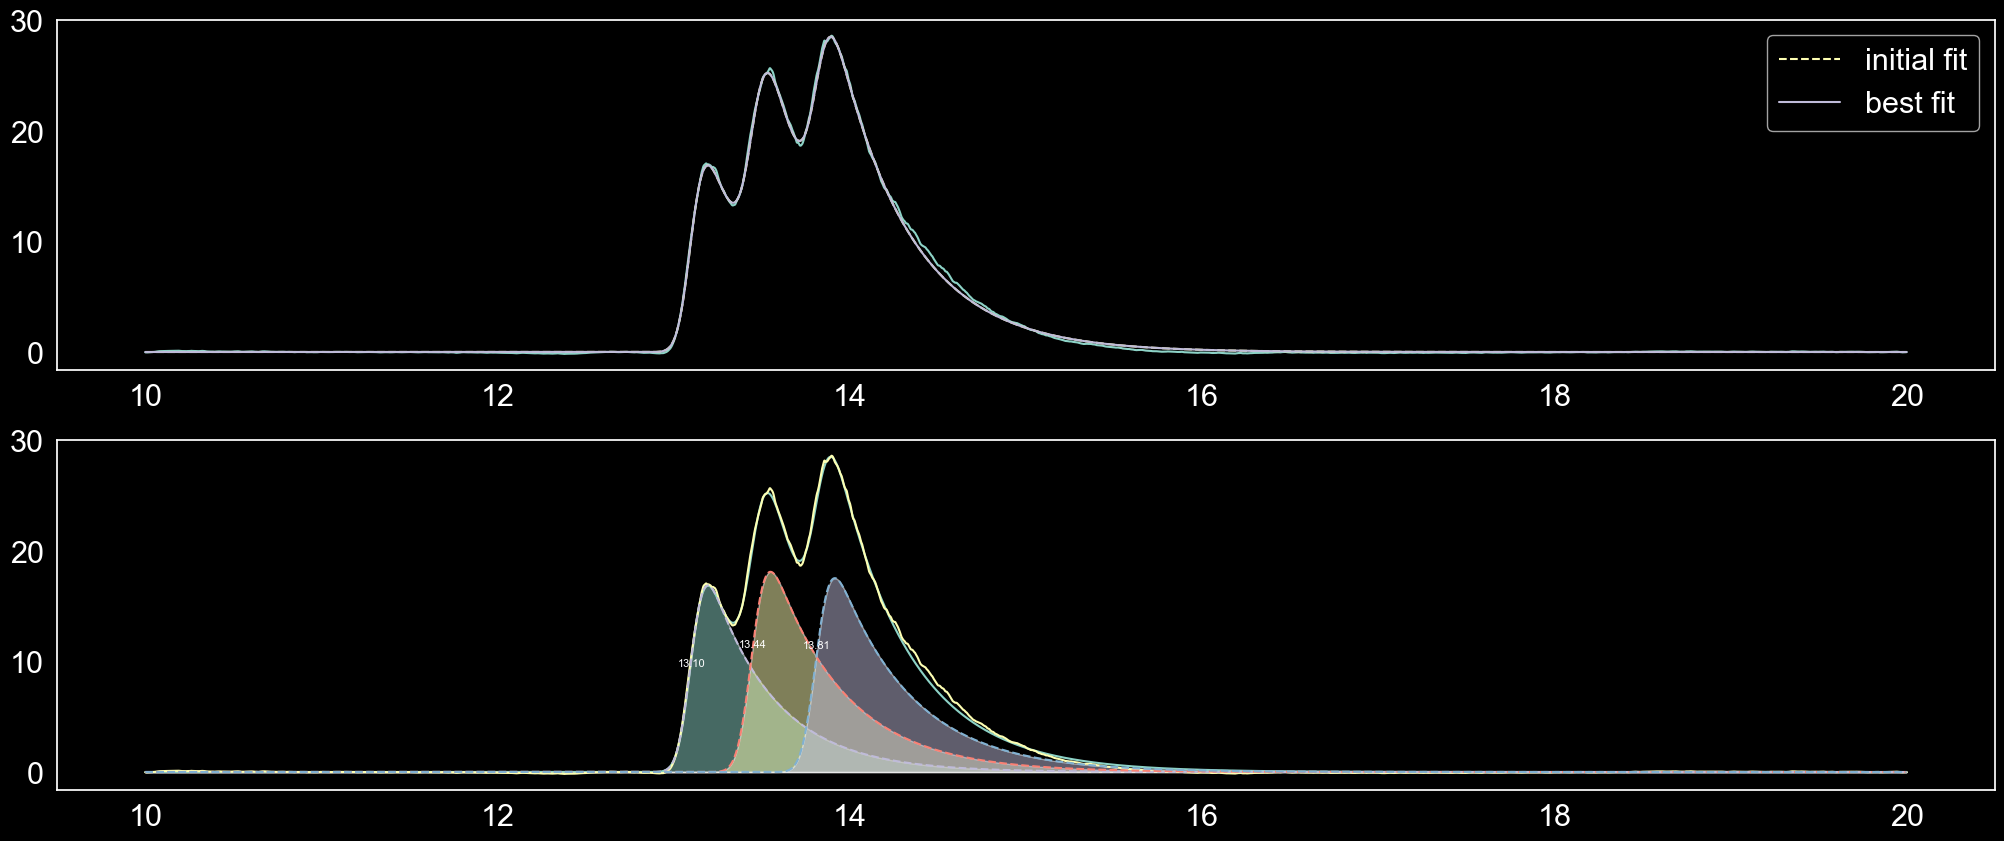

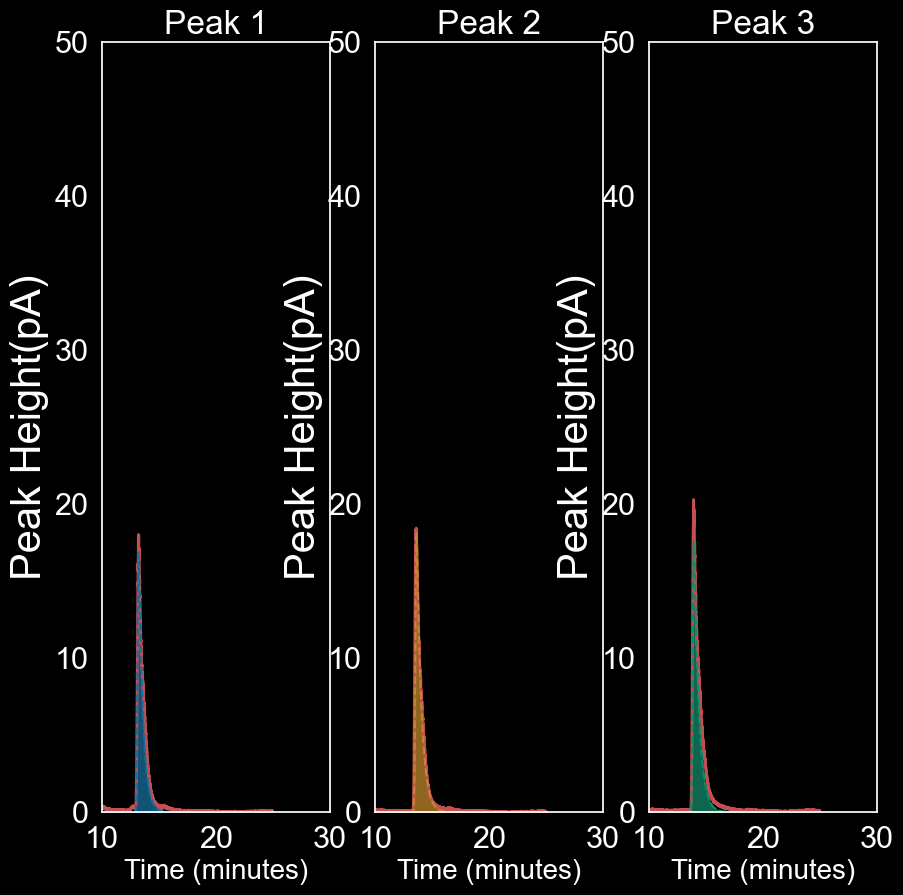

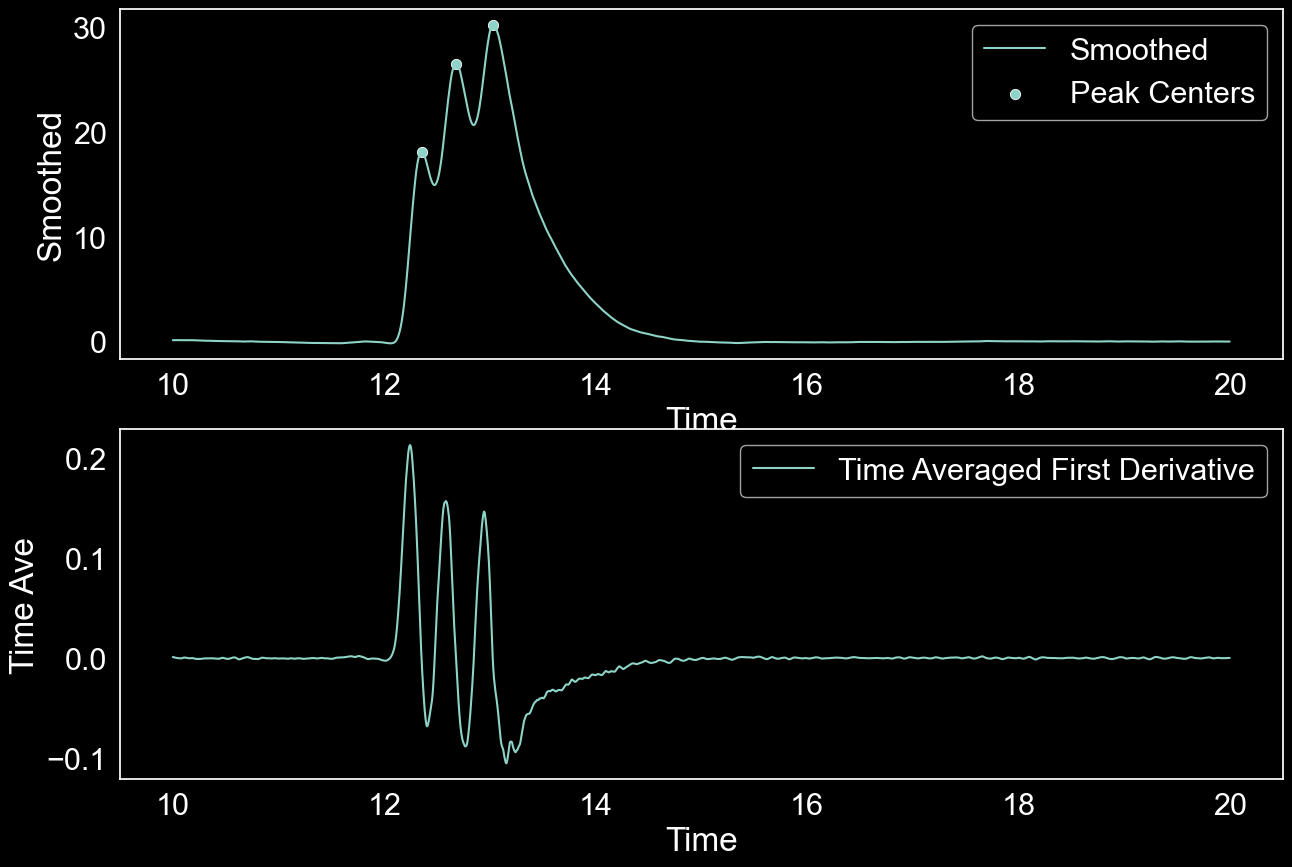

[[12.354433, 12.679517, 13.031467], [18.526443491204173, 26.650043853710685, 30.12843205591354], [10, 20]]
[[12.253906380626873, 0.062396038739884696, 9.468481395952292, 2.620799567466713, 56.221641994327705], [12.590238249714549, 0.06608952432934272, 10.426709763015905, 2.421434763935265, 61.90866137818963], [12.952833545551293, 0.07091967868233606, 10.986657470238146, 2.3689329577362486, 65.23790530234017]]


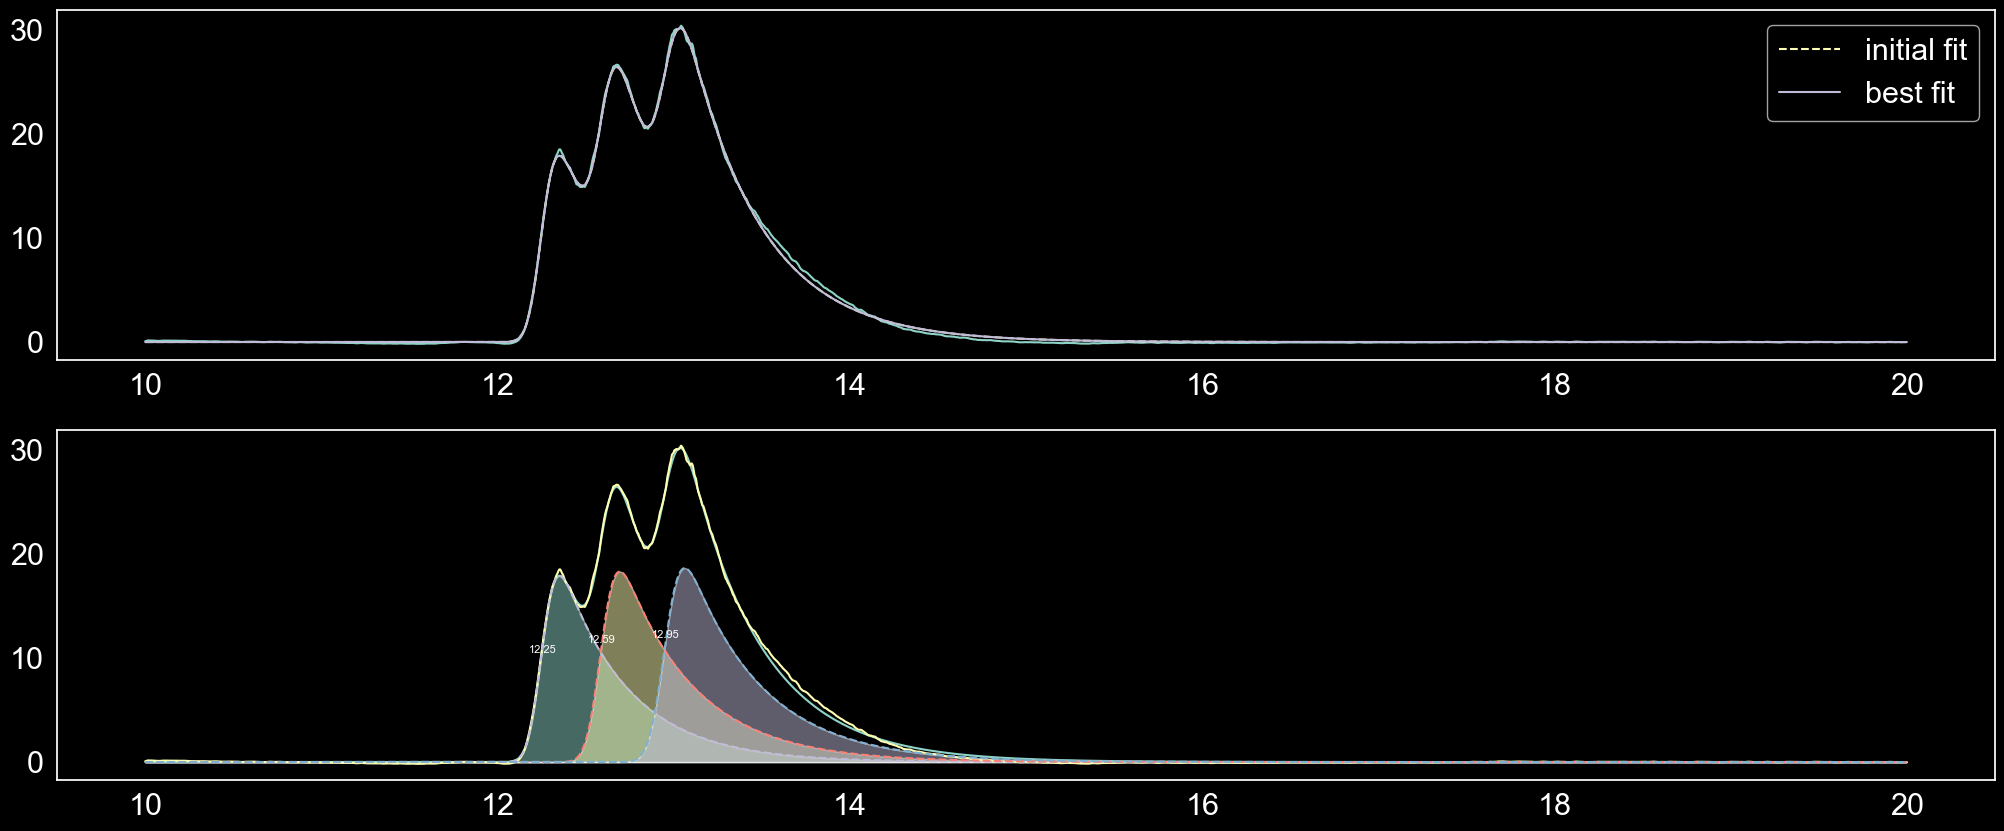

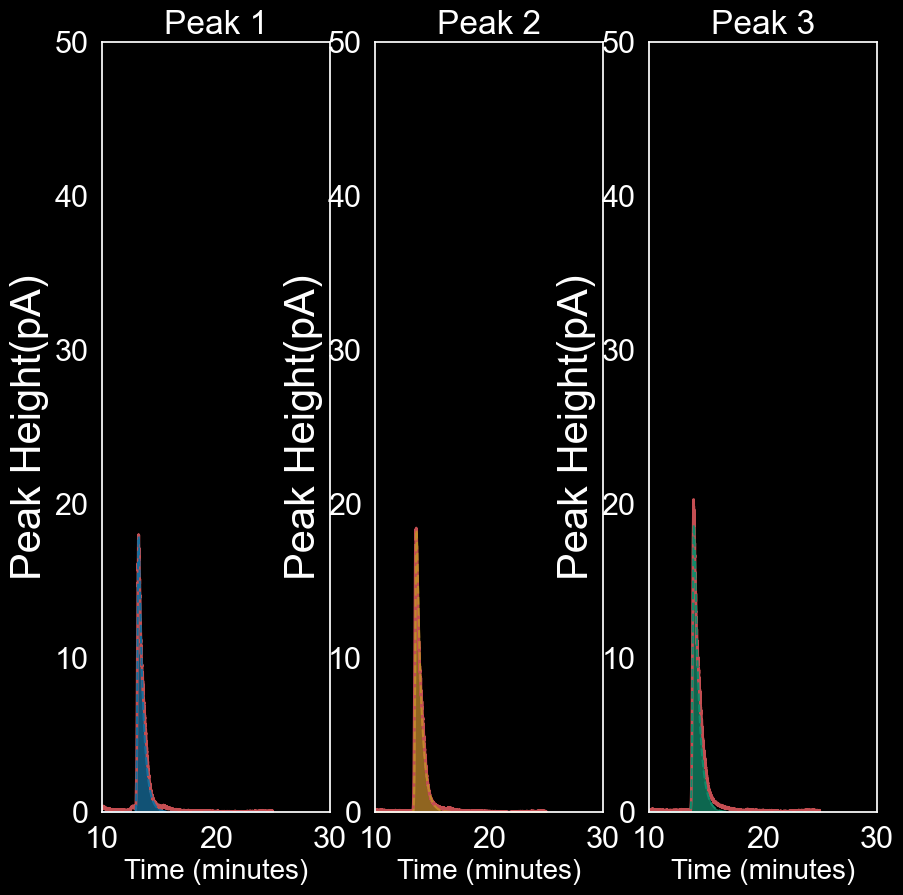

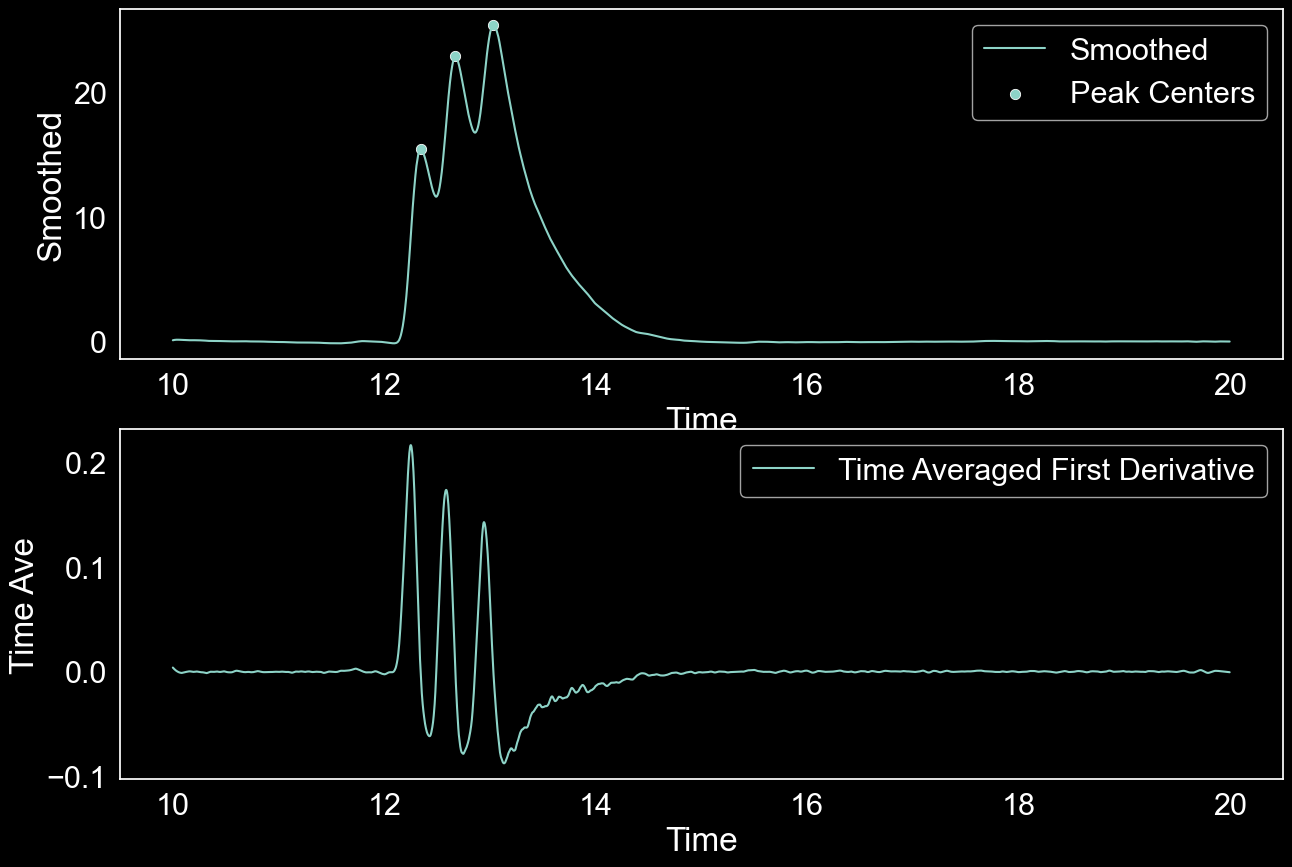

[[12.344467, 12.672633, 13.033133], [15.406637572797663, 22.873938412617175, 25.587234166169985], [10, 20]]
[[12.258088540136104, 0.05254310190423599, 7.737588202397962, 2.636011427573151, 45.94594041913449], [12.593746705831759, 0.05514803184980934, 8.915902982070323, 2.3557138172636223, 52.936950581977726], [12.956403886587976, 0.06213897044318623, 8.85397216350948, 2.35078963300766, 52.57080302464759]]


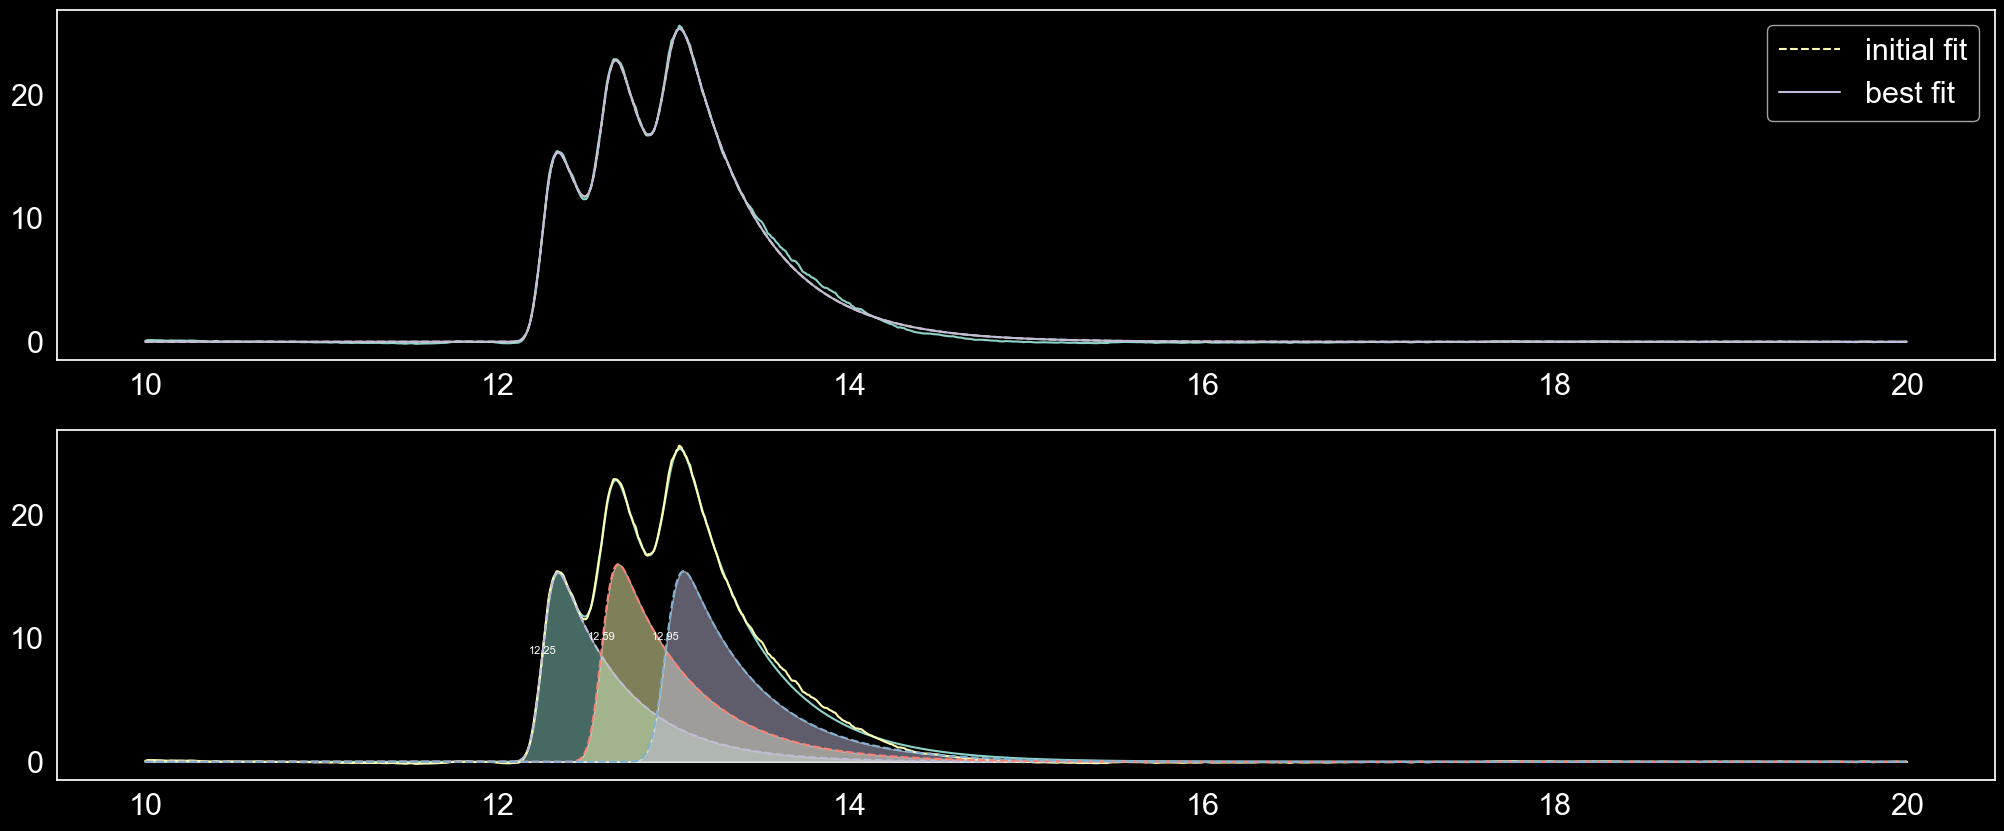

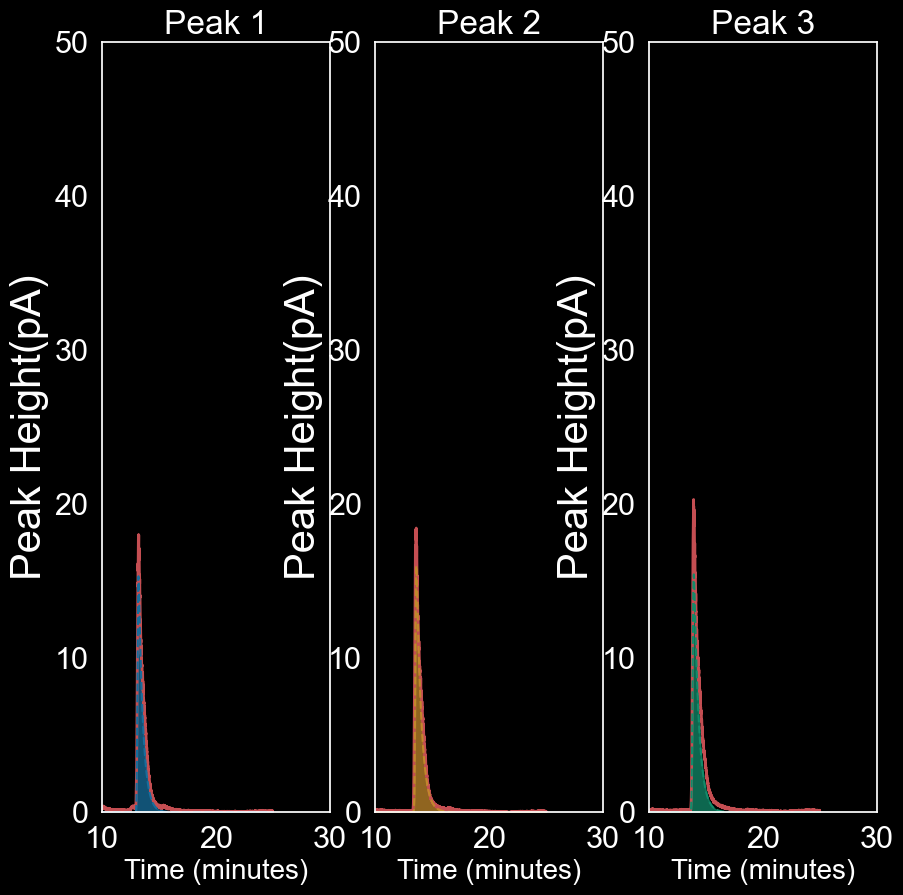

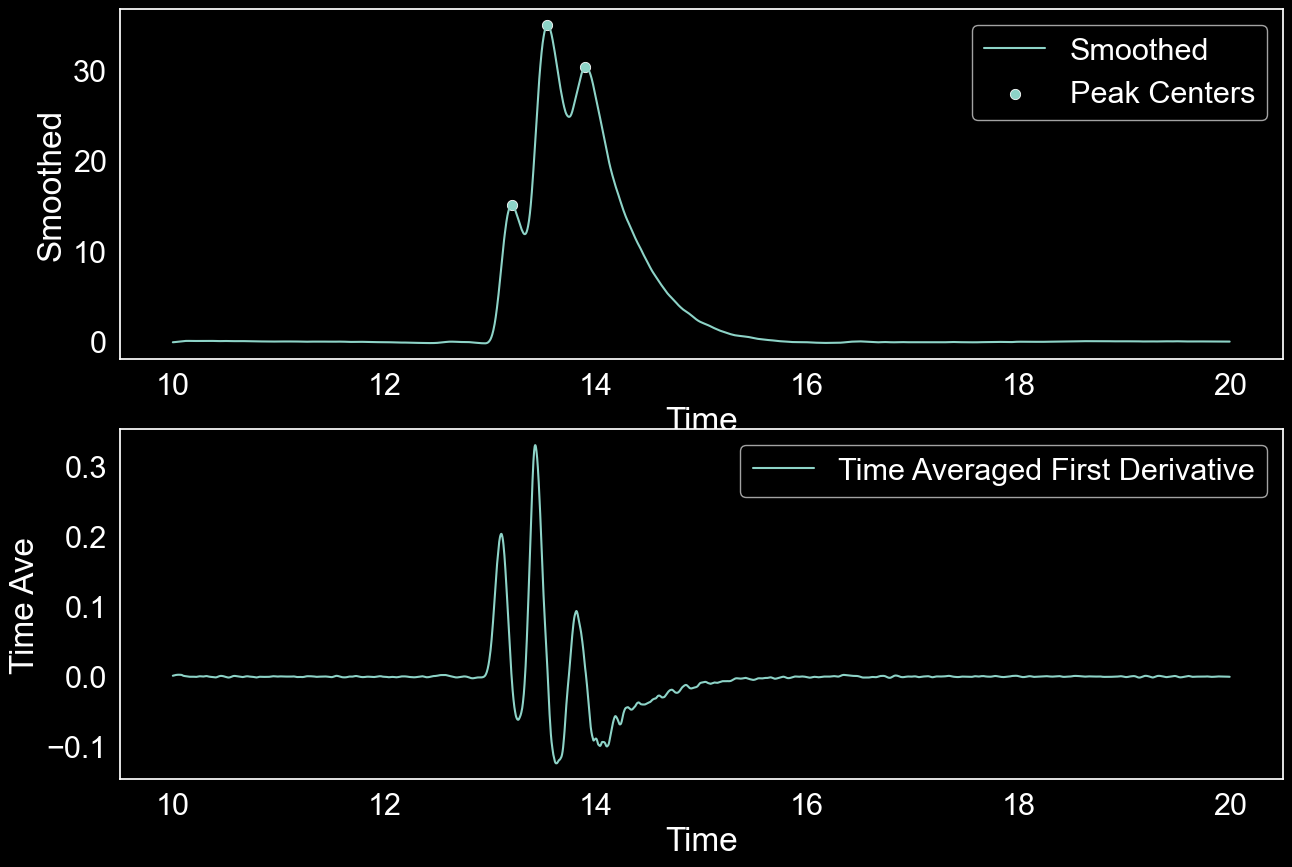

[[13.206483, 13.544933, 13.90365], [15.072474048476135, 35.042217182197604, 30.269375092357578], [10, 20]]
[[13.123039043526585, 0.05851755653875063, 5.762856649994507, 4.057757630002219, 34.2248365549624], [13.44817641730278, 0.06565271307578148, 16.955157213191924, 2.517286032815853, 100.68729733709746], [13.837158783589928, 0.07663791903585489, 9.517036814545323, 2.4977458815201334, 56.515936737608065]]


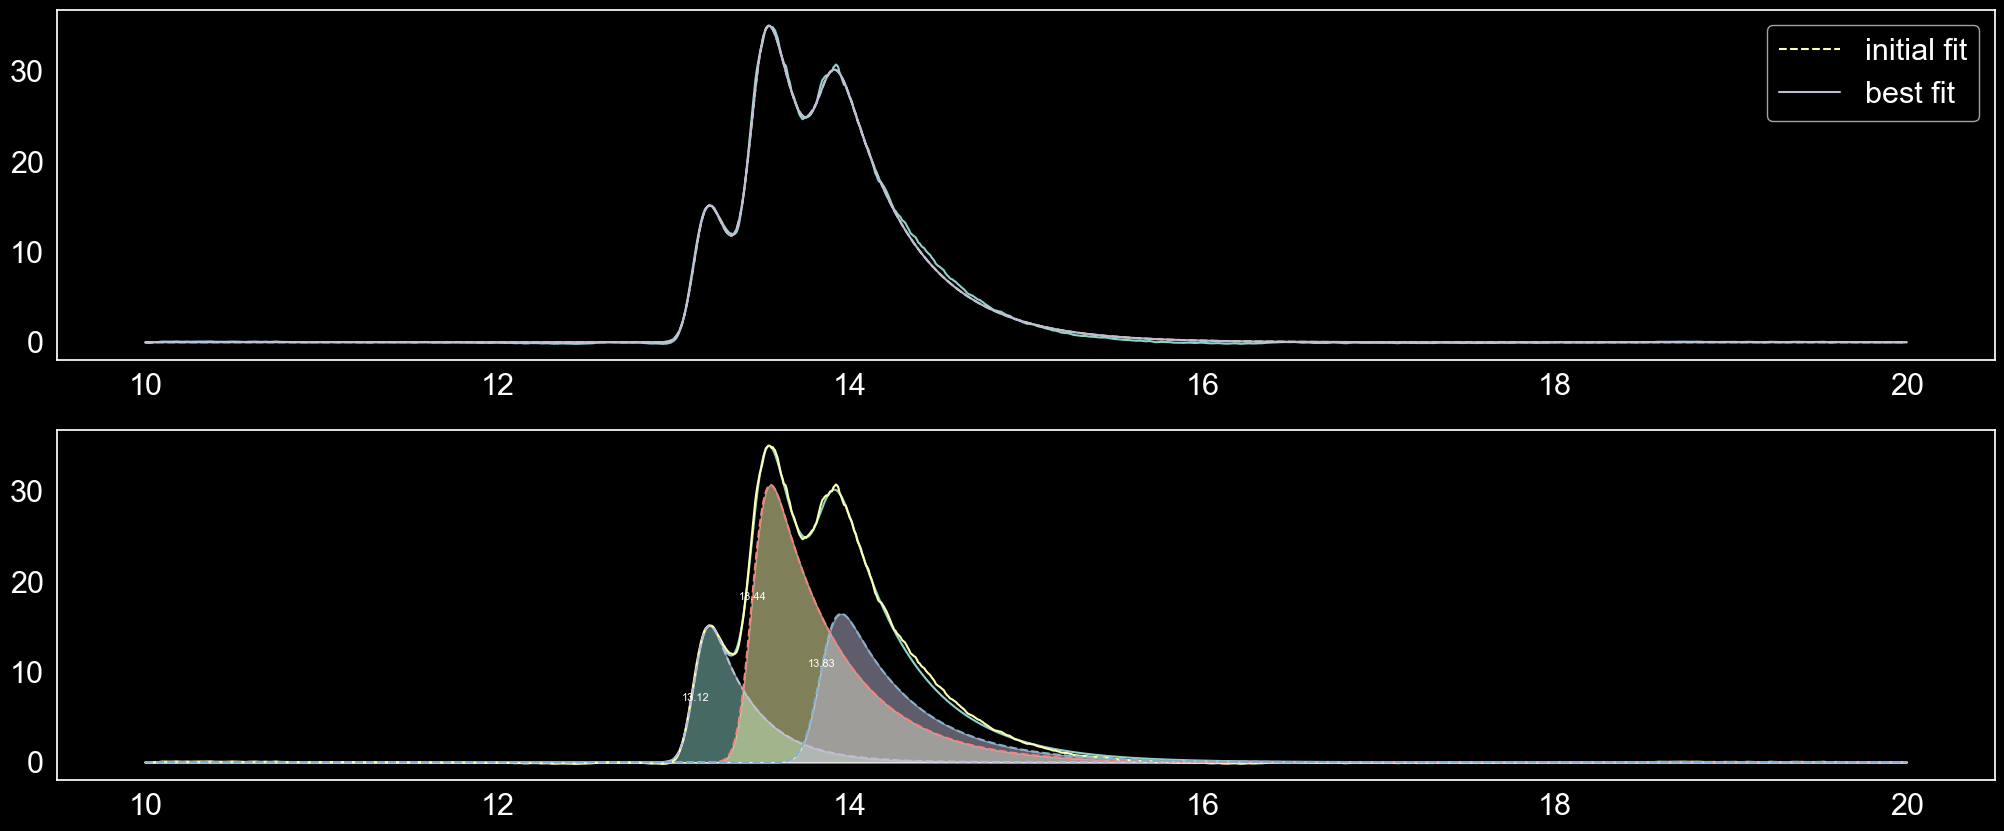

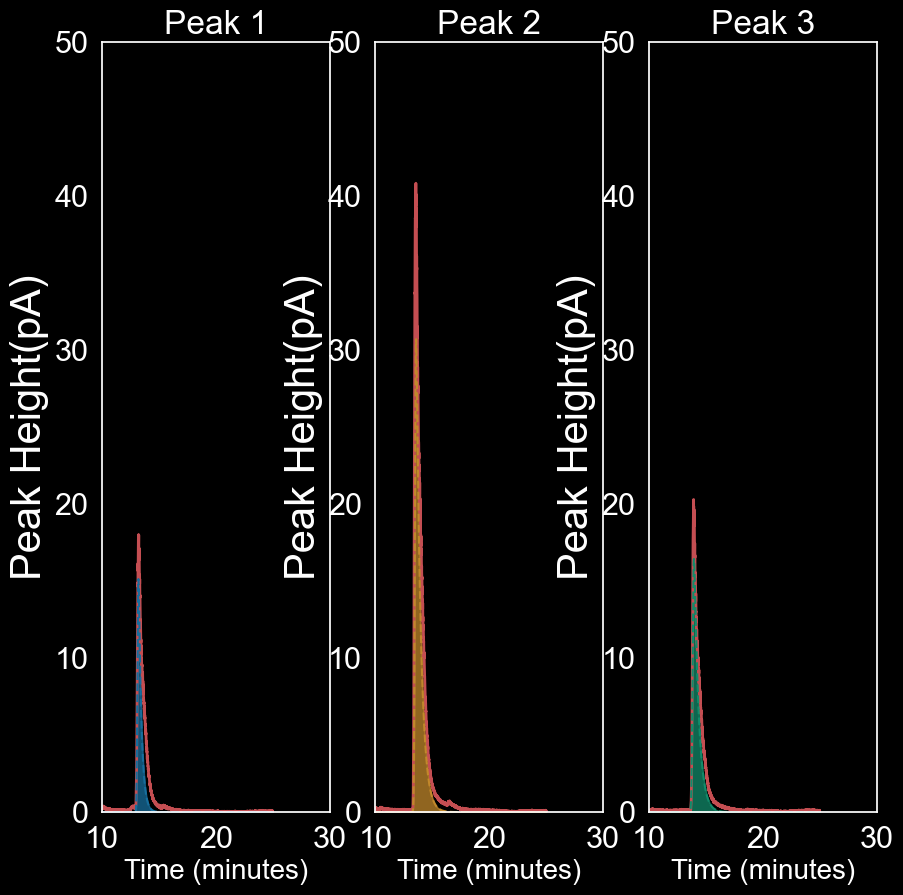

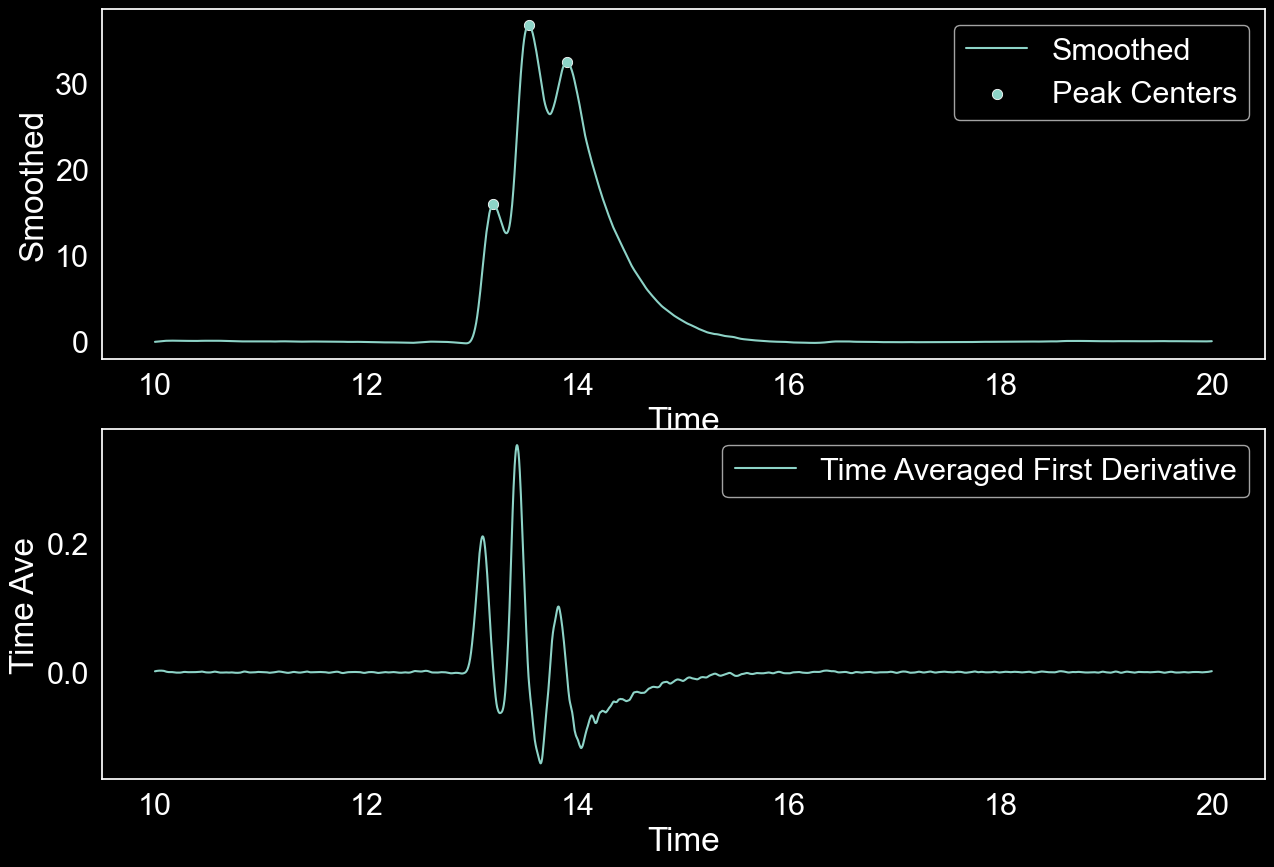

[[13.202983, 13.5349, 13.896983], [15.949596625886954, 36.84115318398428, 32.40551054545077], [10, 20]]
[[13.120192945700863, 0.06129368285434699, 5.828843629648639, 4.448953196931207, 34.6008546635808], [13.440325627238286, 0.06520890260284691, 18.249425277917638, 2.4802789675650128, 108.35570965956677], [13.828087563273858, 0.07767281810670762, 10.314269659169497, 2.477006316443326, 61.23563337315575]]


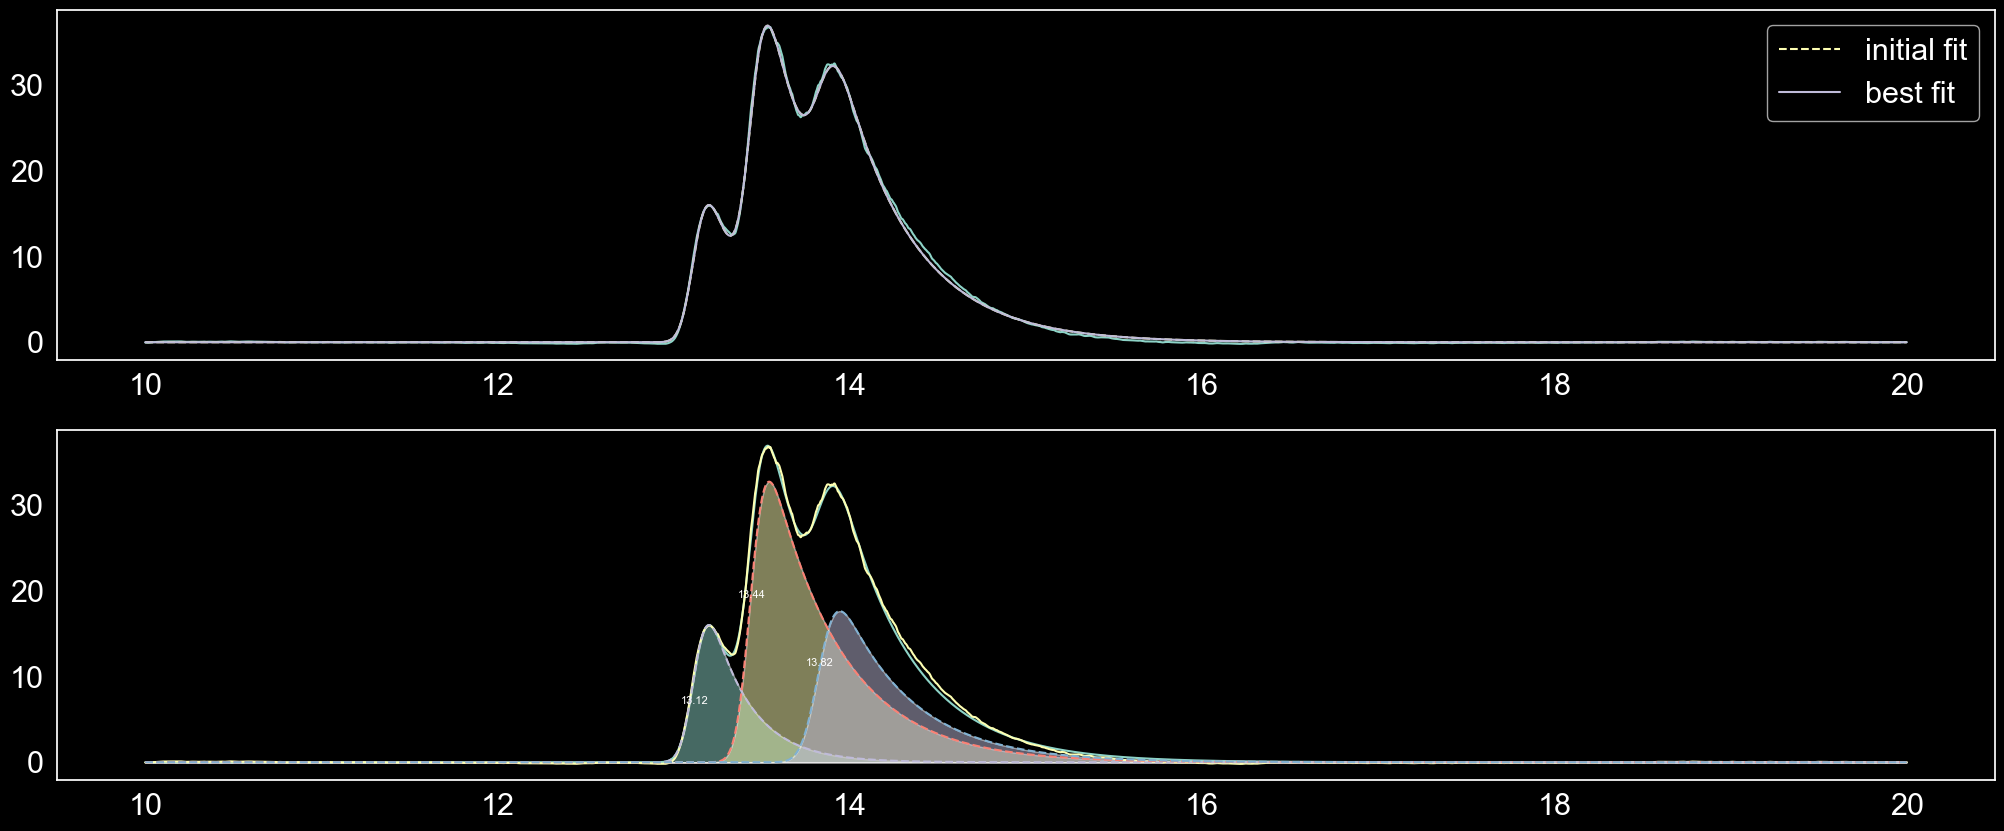

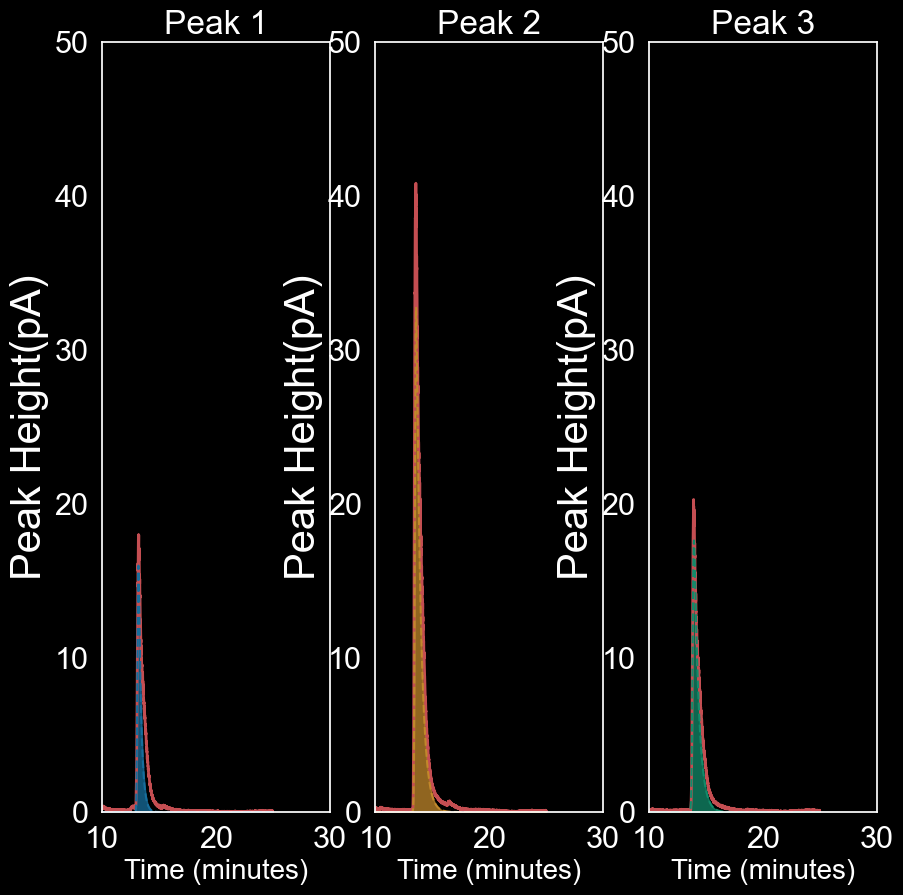

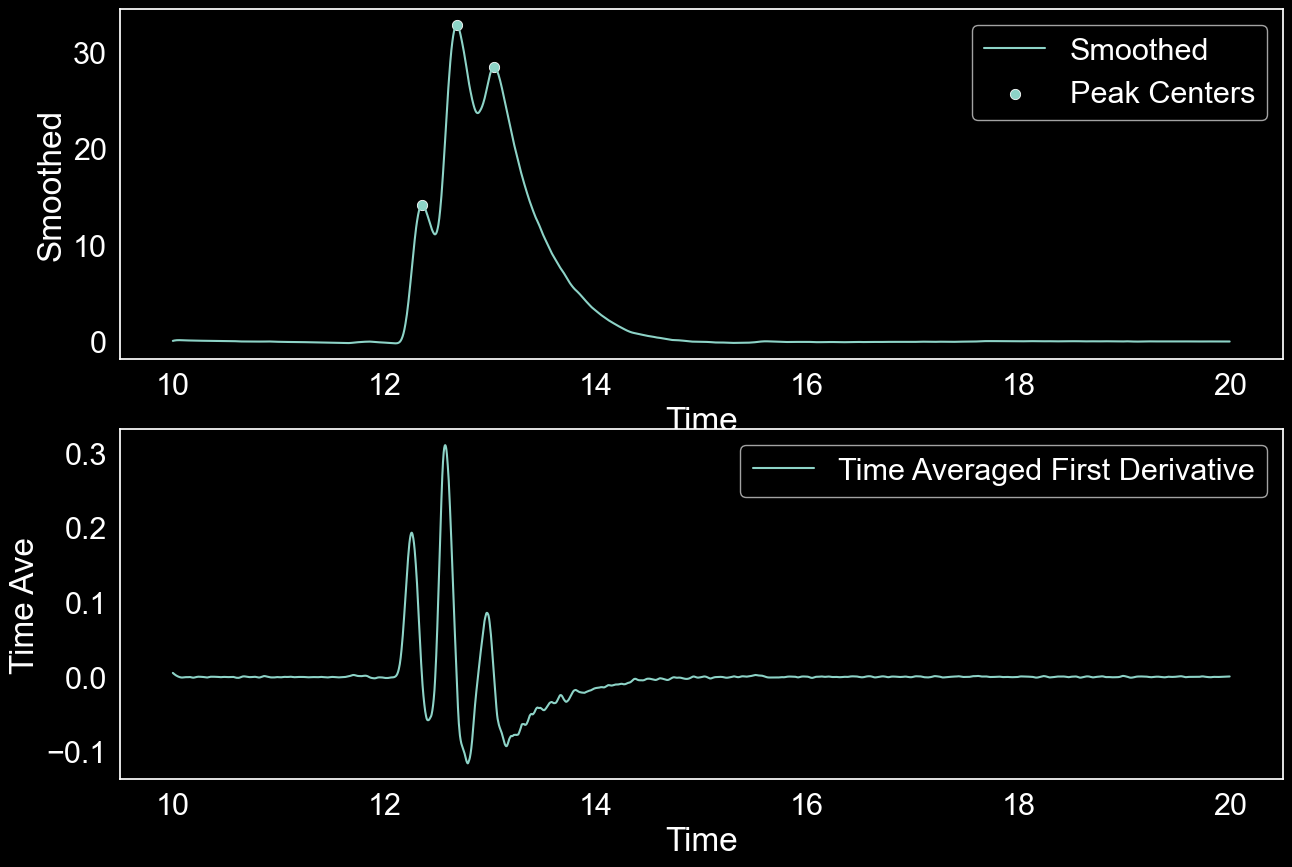

[[12.3593, 12.68605, 13.0411], [14.314614775517702, 32.852313328946195, 28.724214623562304], [10, 20]]
[[12.27210667674108, 0.053884528091092766, 6.148109823811517, 3.2244170533173886, 36.5158330242325], [12.594512546178084, 0.060025142750663146, 15.363020539381642, 2.4184160329068214, 91.23871003645273], [12.97441920963848, 0.07597150746178132, 8.59412681704316, 2.442241454133962, 51.0359177105511]]


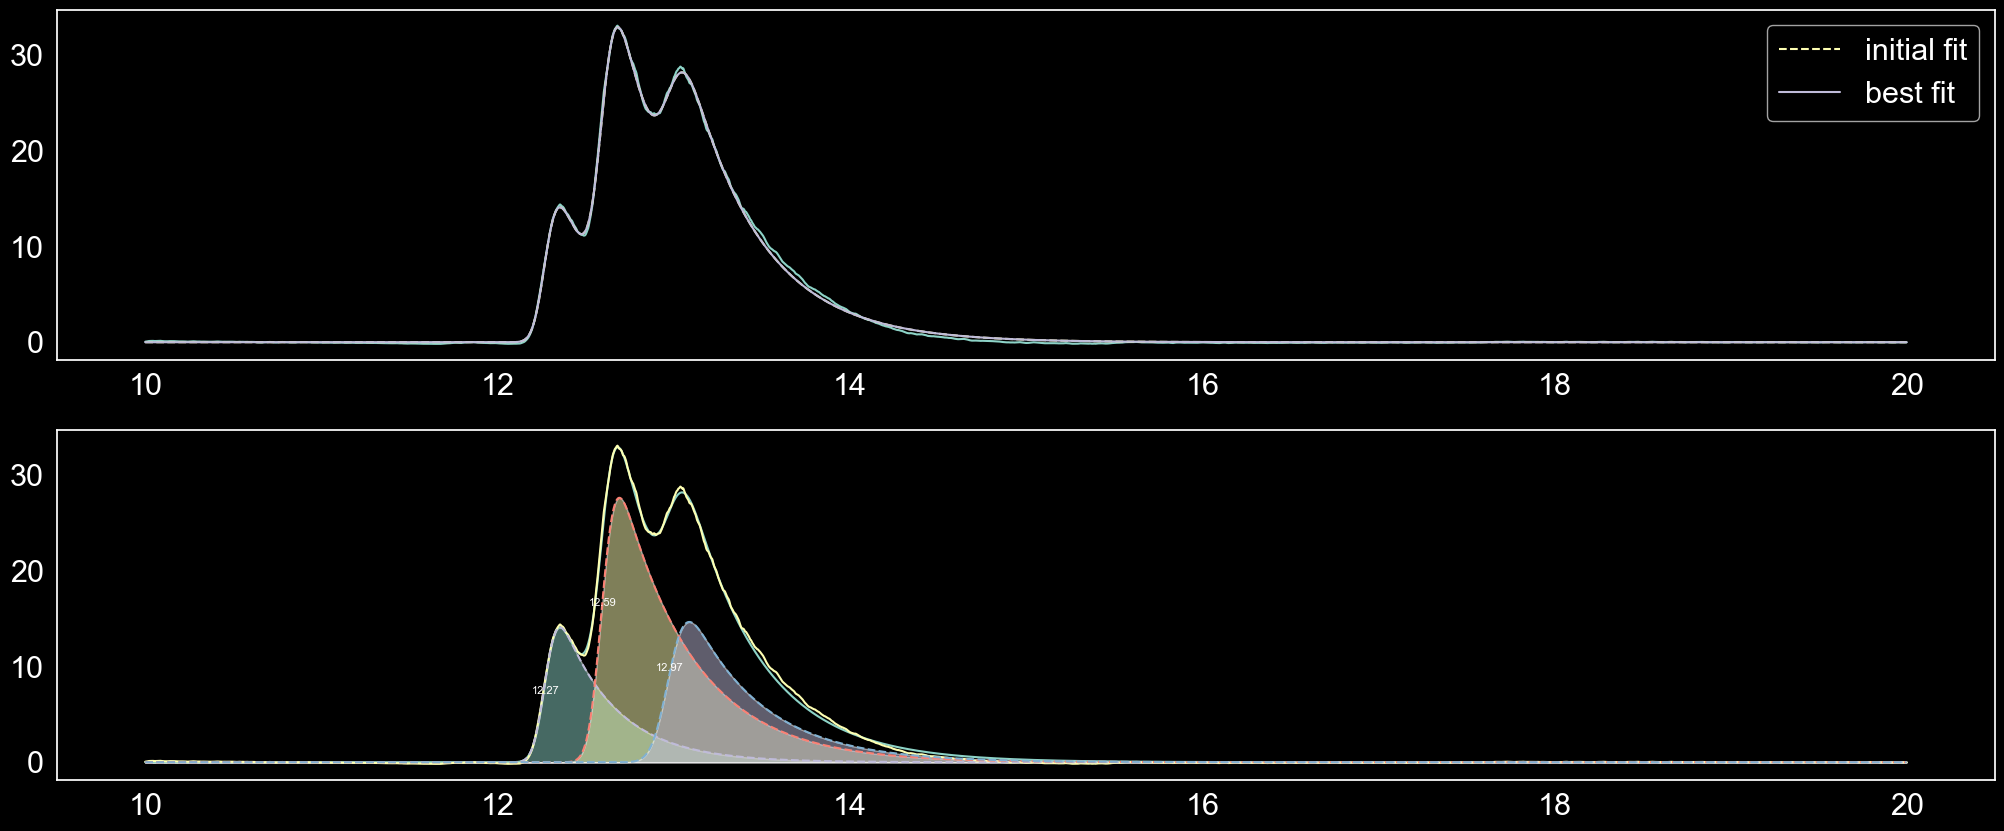

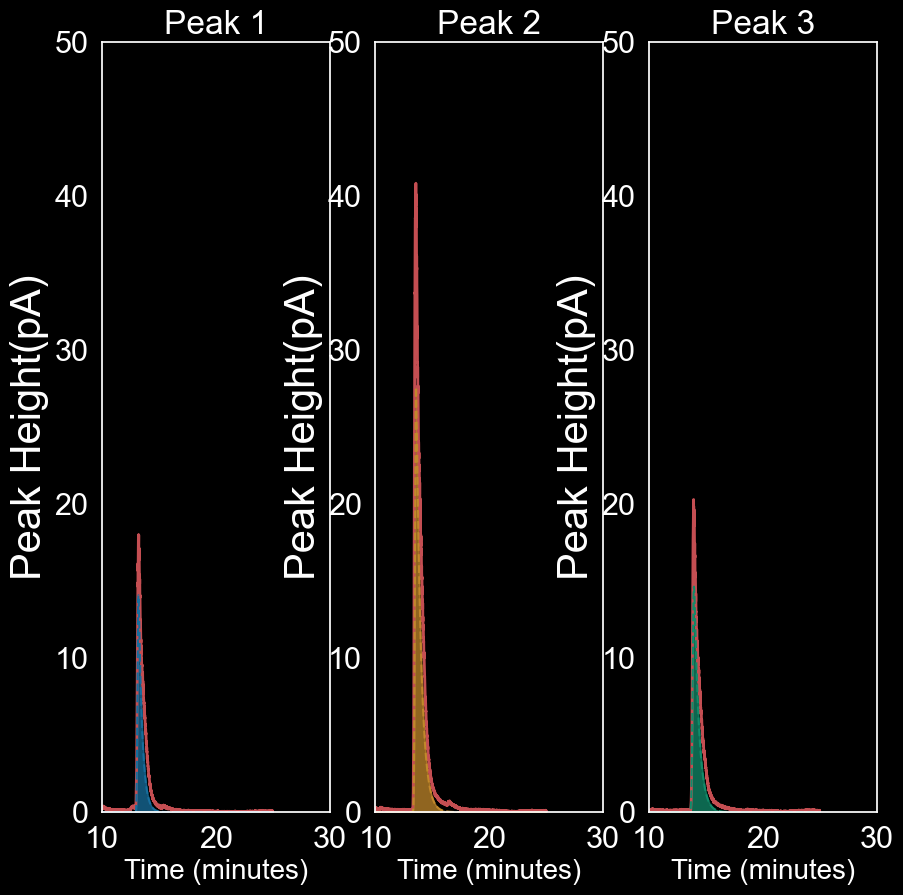

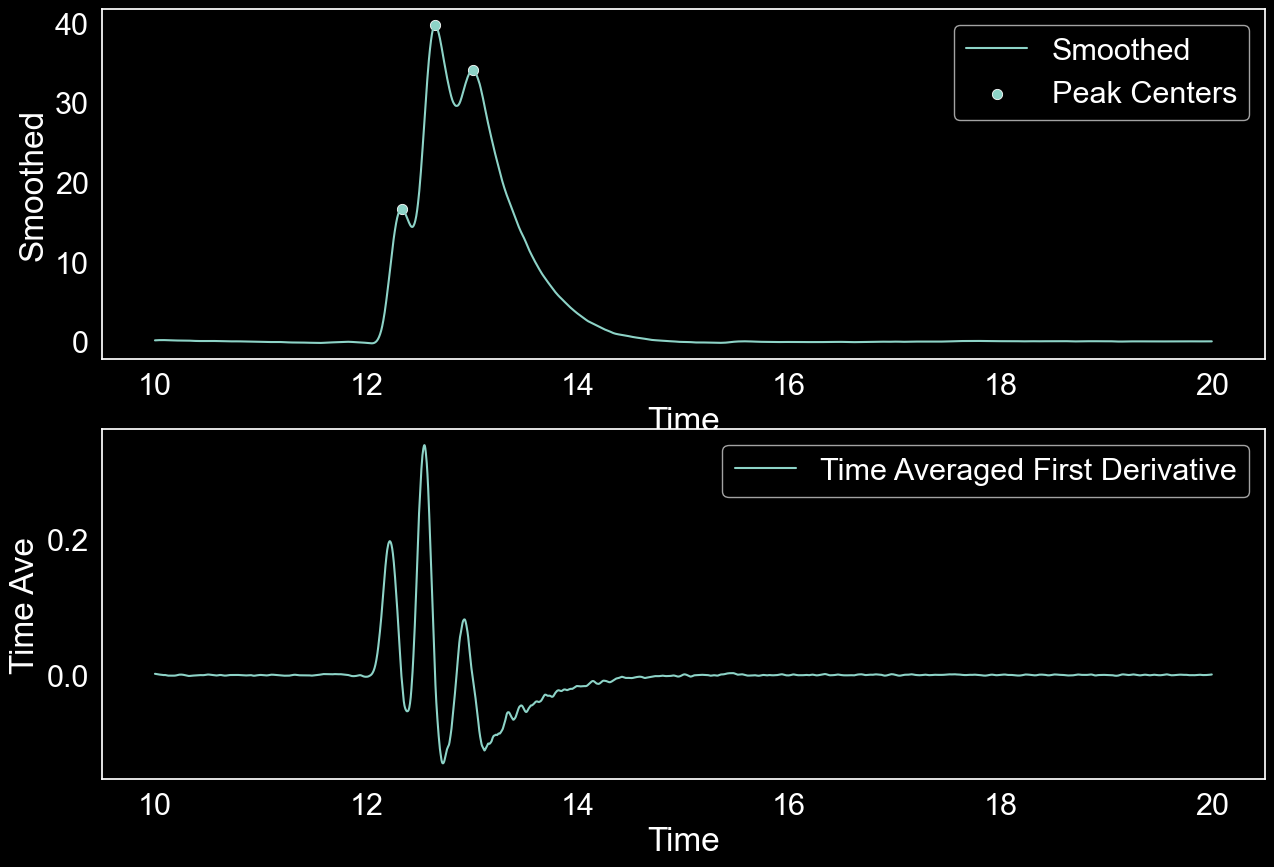

[[12.334767, 12.651083, 13.0082], [16.704319270542886, 39.827649075448704, 33.929374226308], [10, 20]]
[[12.234162847863029, 0.06100795571352185, 8.615478502787573, 2.6381287936369997, 51.1597209422271], [12.559519440674572, 0.06309405790842336, 17.66086980269459, 2.49017724342286, 104.8804888120507], [12.939015581537676, 0.08604301592684215, 10.57245526523243, 2.463075375426318, 62.76956941577031]]


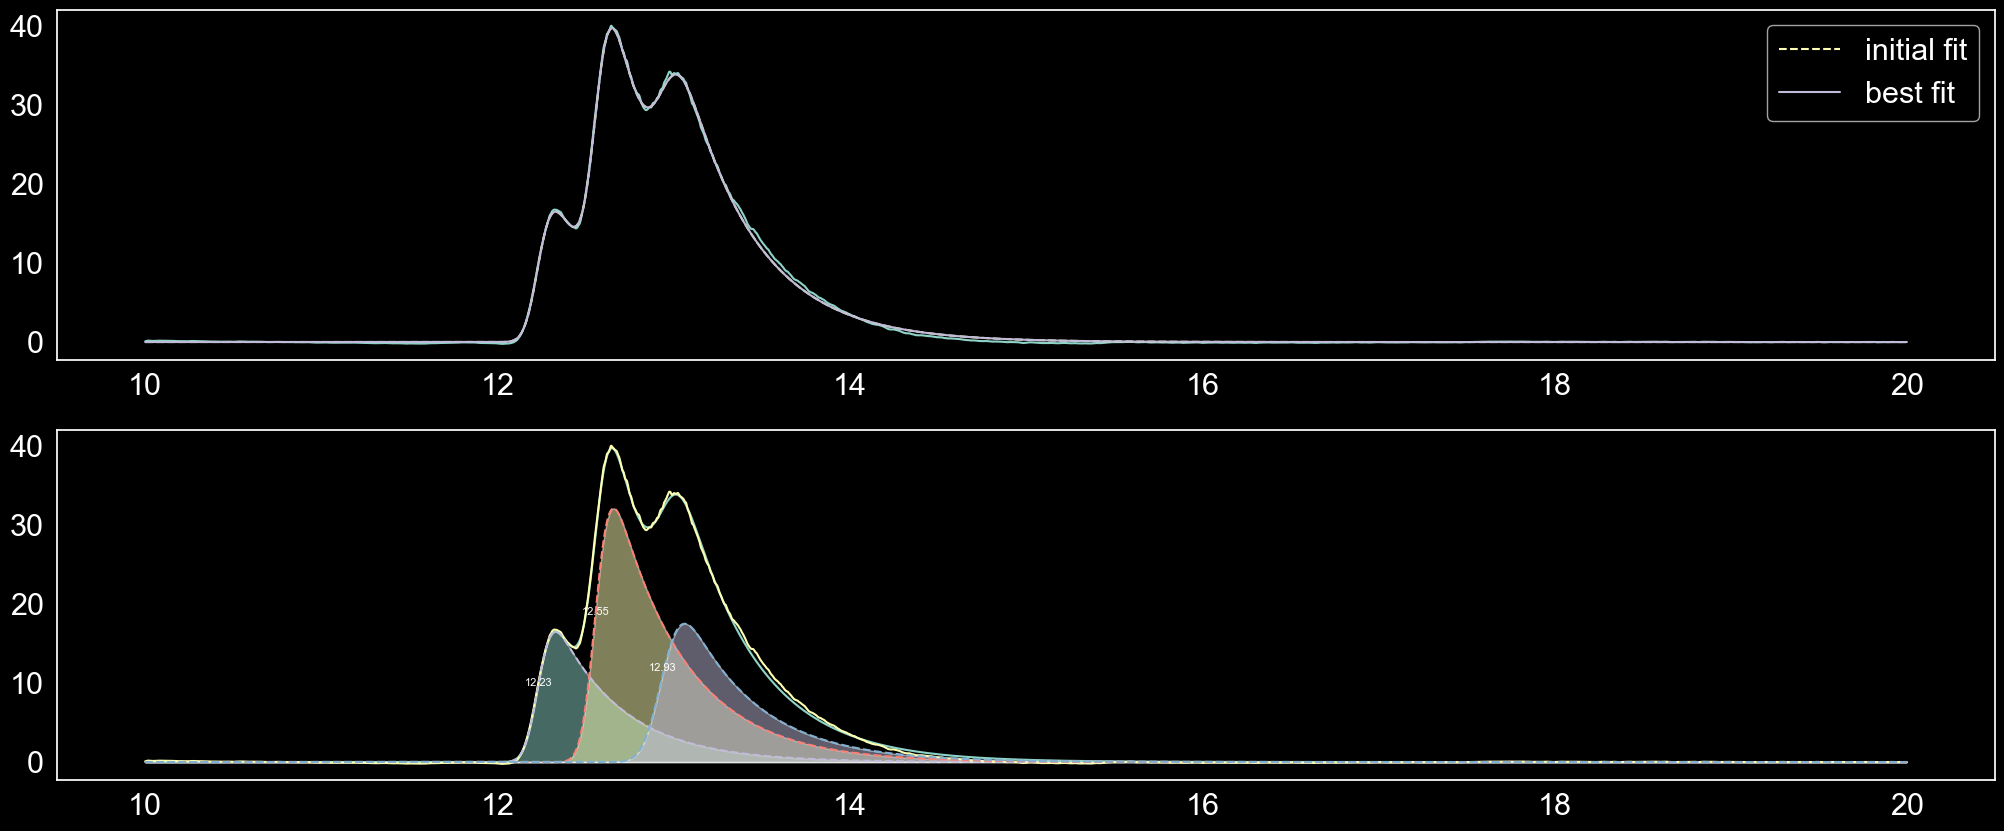

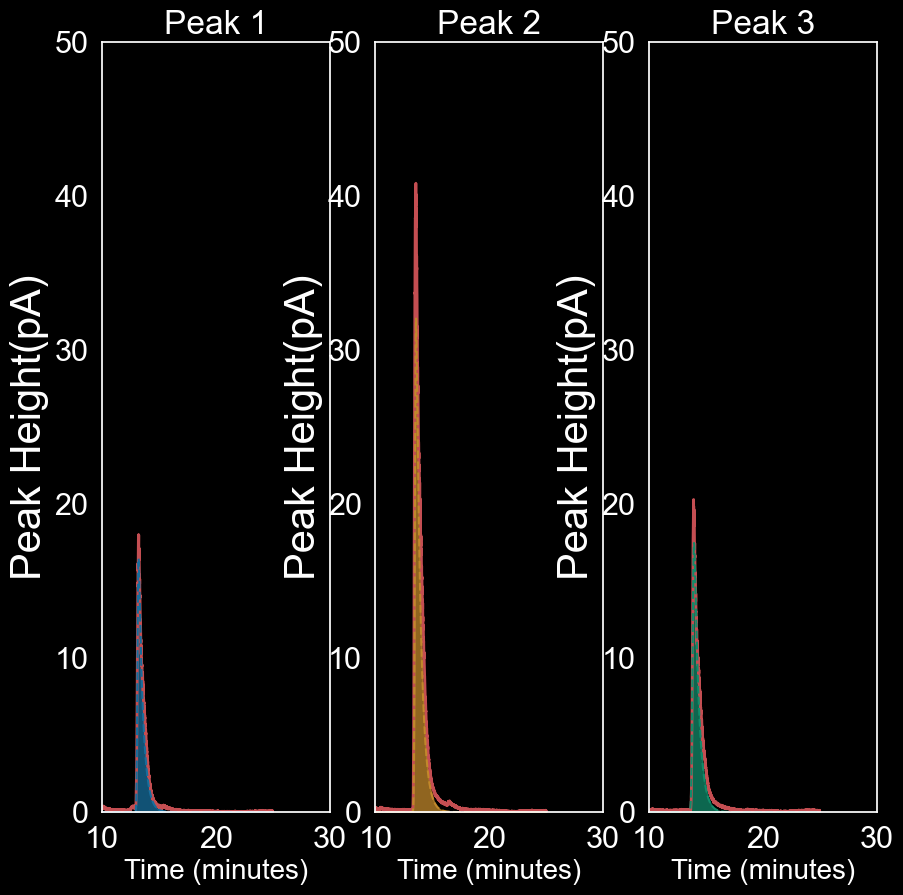

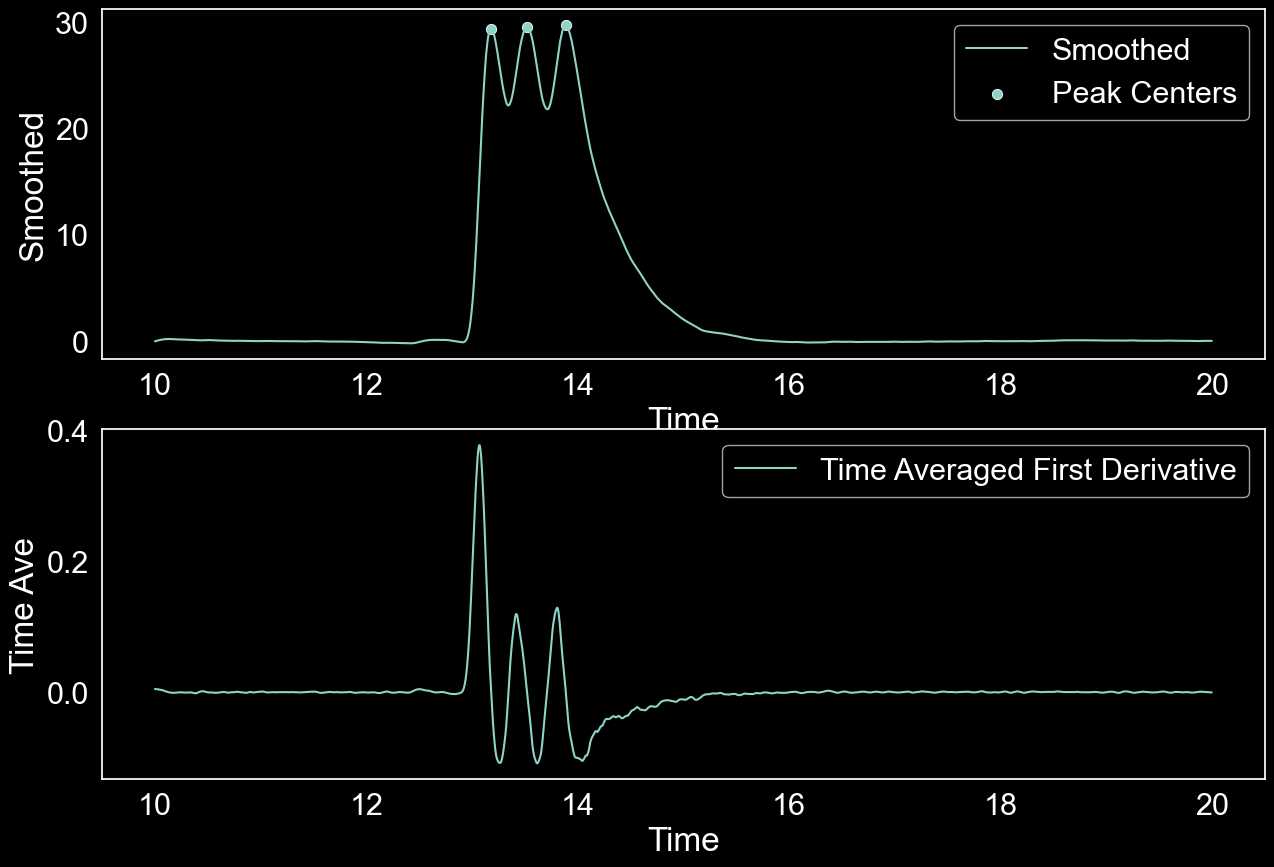

[[13.179667, 13.519883, 13.886917], [29.68118081699577, 29.74164259278345, 29.687060598322823], [10, 20]]
[[13.08284084750395, 0.05936378585041191, 15.32029273596402, 2.62186034797871, 90.95947078015381], [13.439906478199894, 0.0685005646000594, 9.37418606839873, 2.5423920986897106, 55.65926298740665], [13.809148985155952, 0.06843778963602822, 9.711436183752255, 2.4935015959117, 57.65129175375653]]


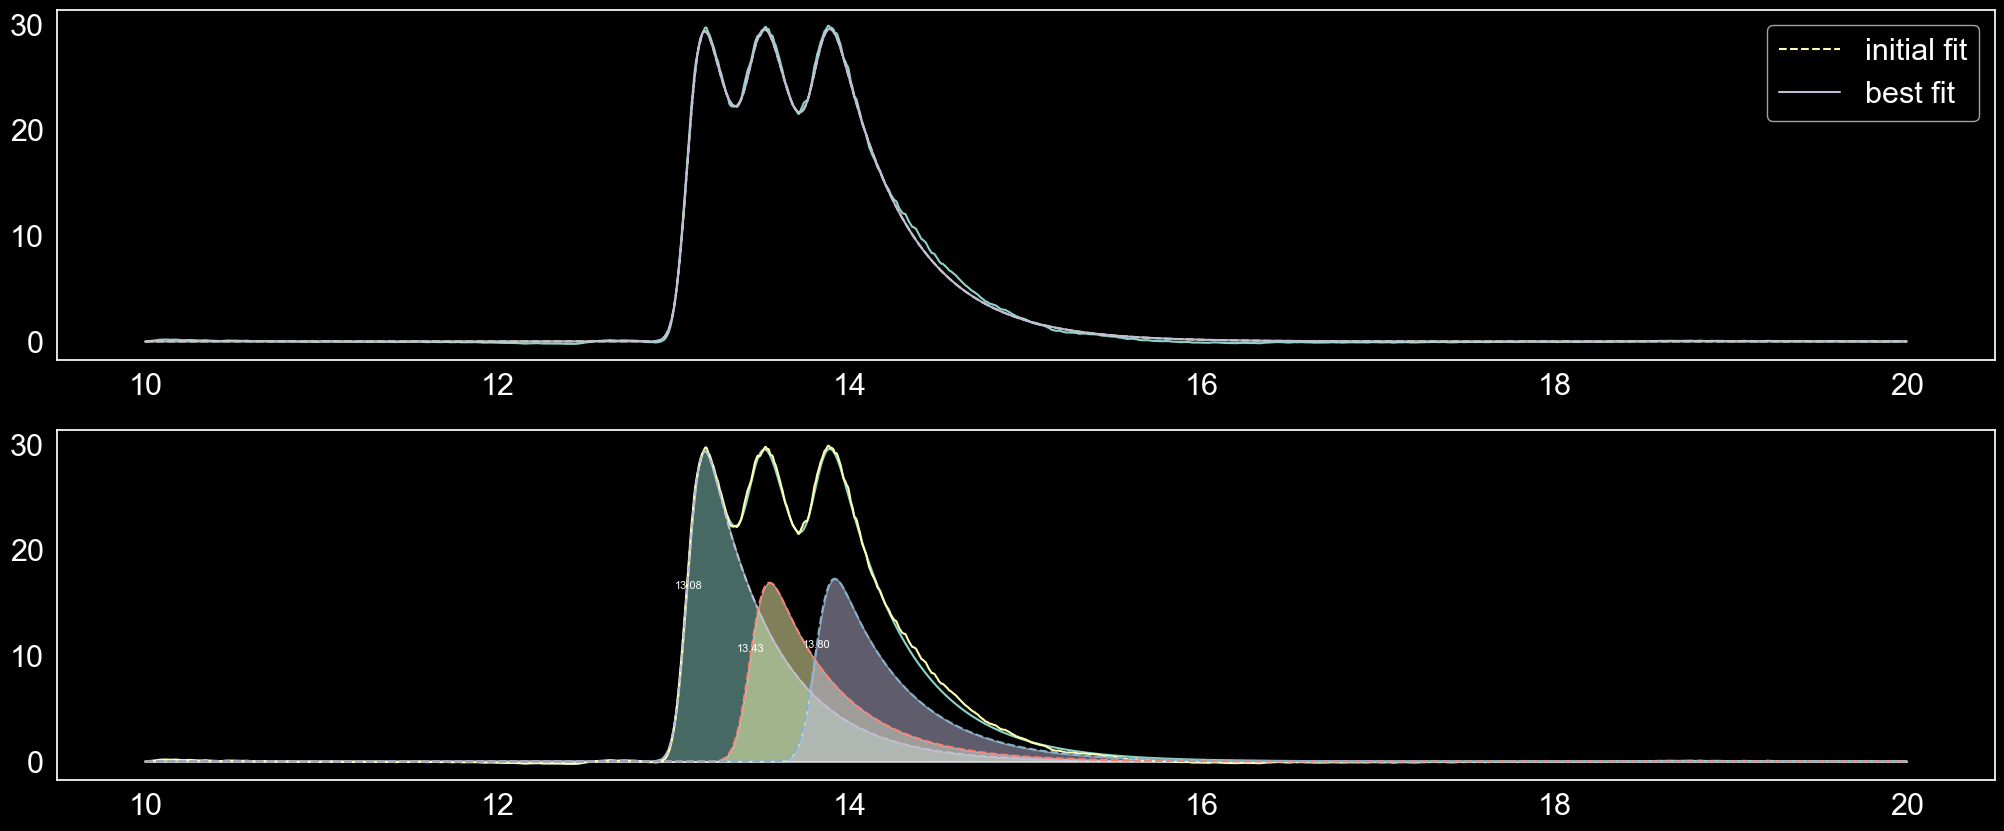

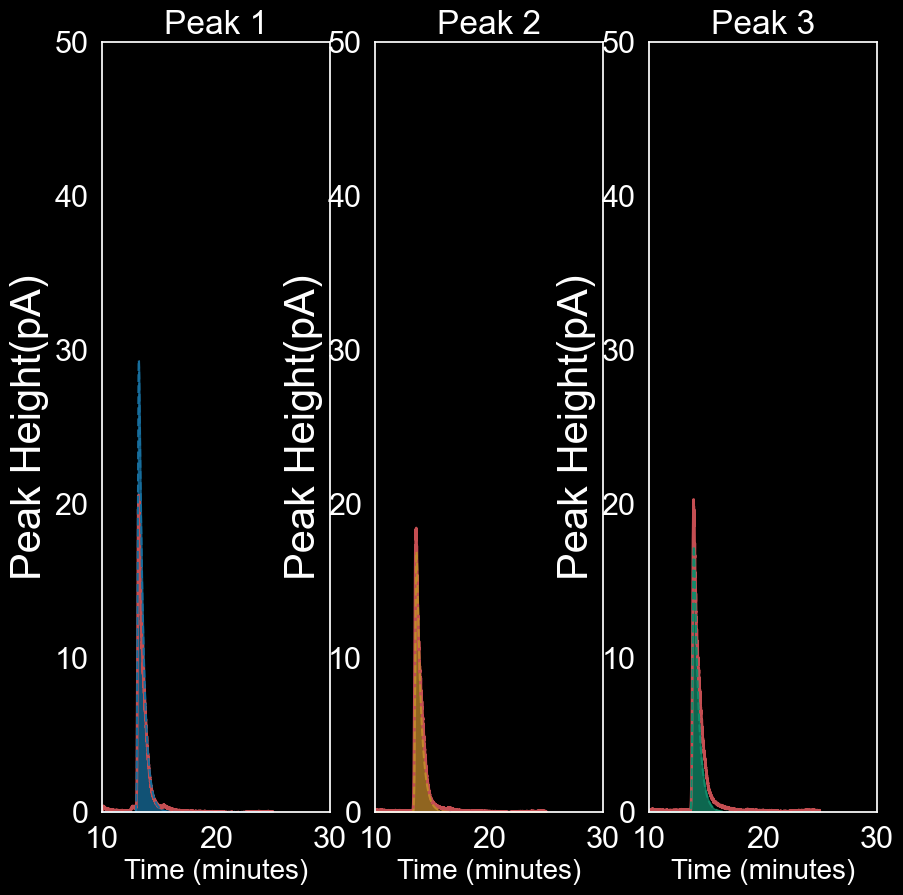

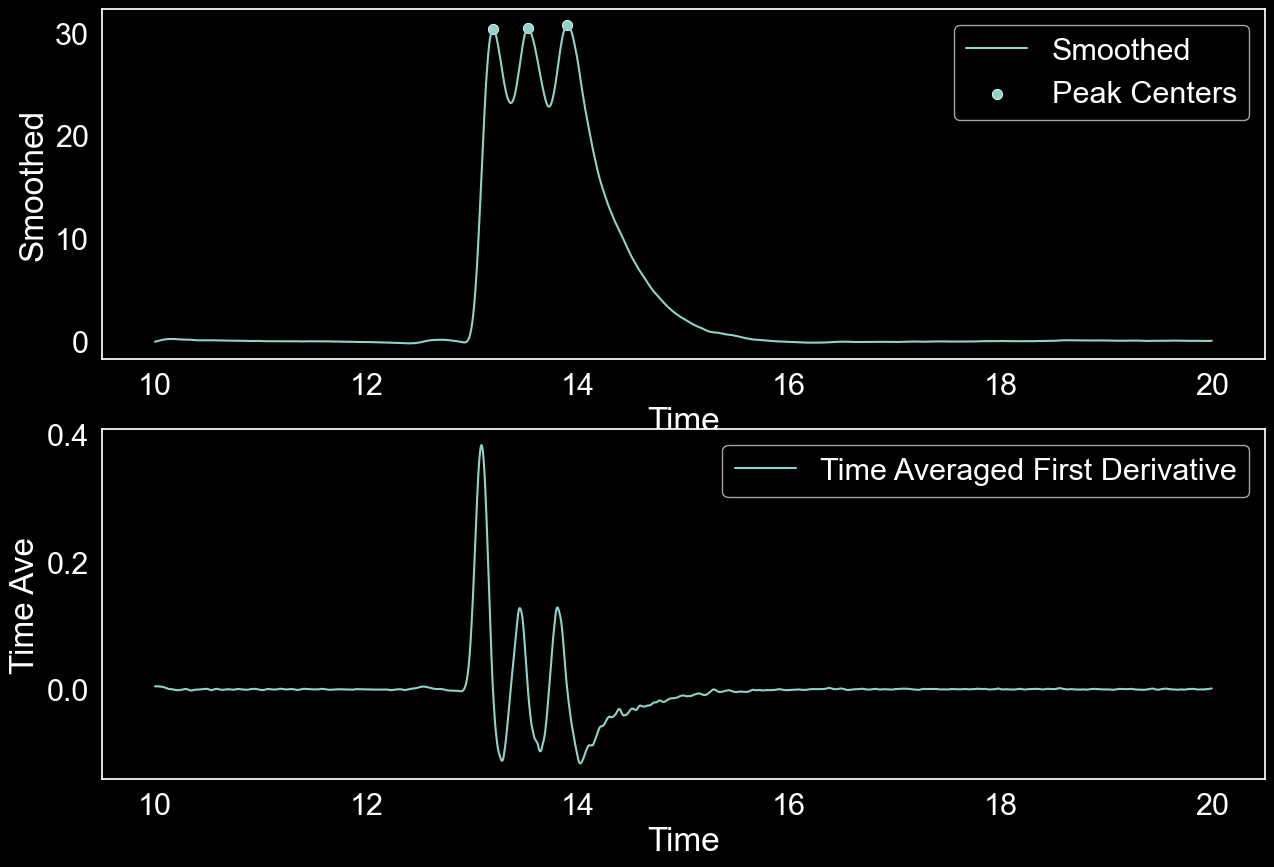

[[13.199817, 13.52835, 13.902117], [30.33783206745388, 30.514764532562253, 30.939006122184686], [10, 20]]
[[13.101174500006815, 0.059419311369547416, 16.20701404408942, 2.535635427506537, 96.24081046257669], [13.459827620260349, 0.06739341810056246, 9.34680544849605, 2.5420822621211046, 55.51060477280268], [13.825784222332185, 0.07159944139468301, 9.966423418210656, 2.562408249074496, 59.20019993646187]]


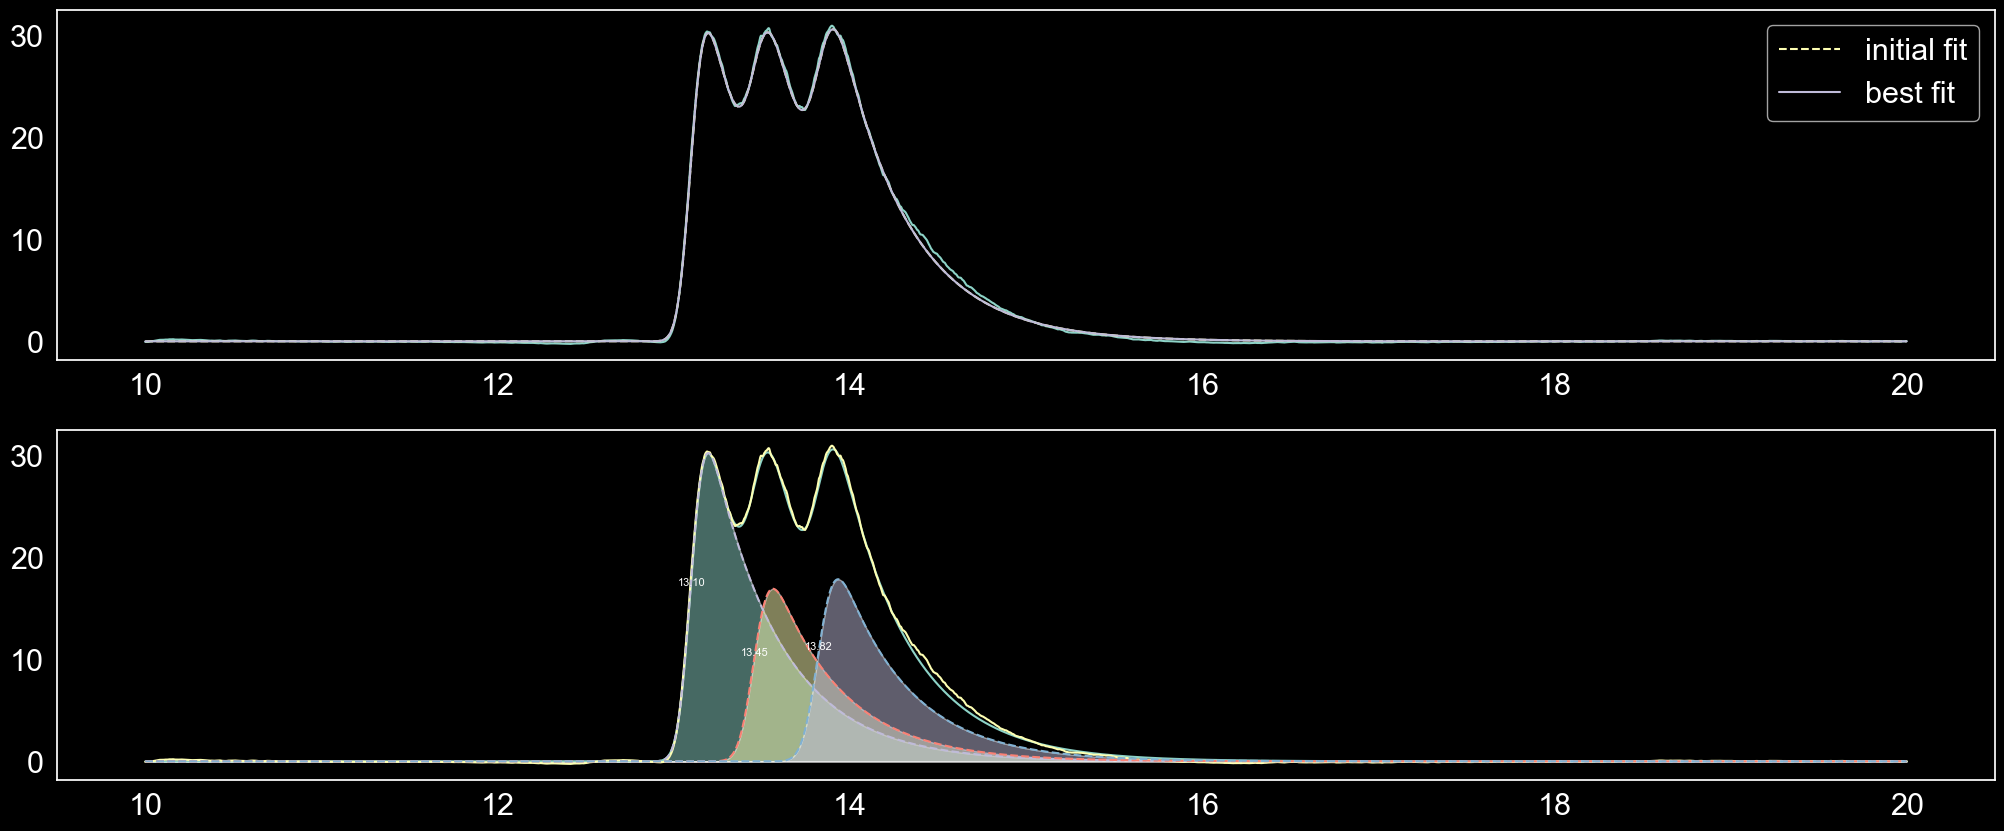

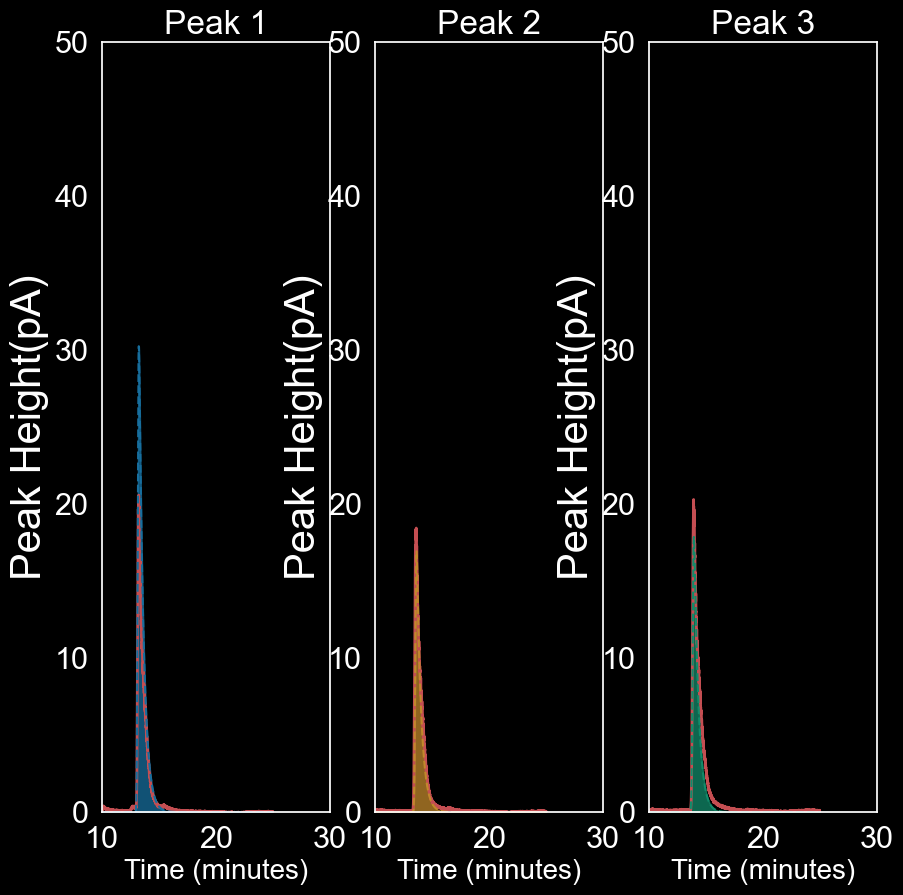

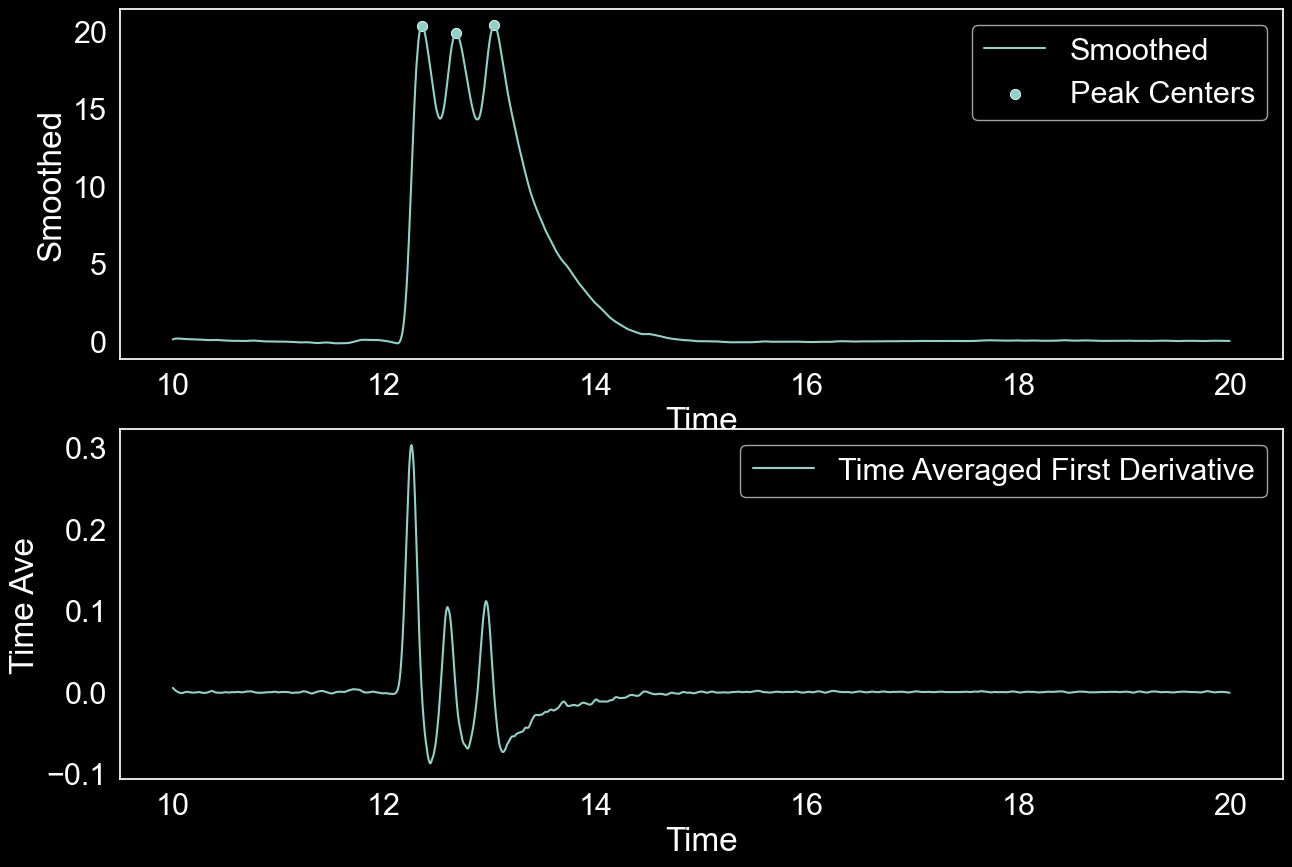

[[12.356833, 12.680333, 13.040617], [20.211351124217305, 19.983959868212466, 20.459948389729824], [10, 20]]
[[12.268460999088154, 0.04976609564259116, 10.356947696025163, 2.5643651137816112, 61.49463048161692], [12.614375721406915, 0.05321673804561693, 6.1126075841969545, 2.315434910850168, 36.28454448435455], [12.969371383875167, 0.056786911776577756, 6.331970855861222, 2.399069423185773, 37.59535565577067]]


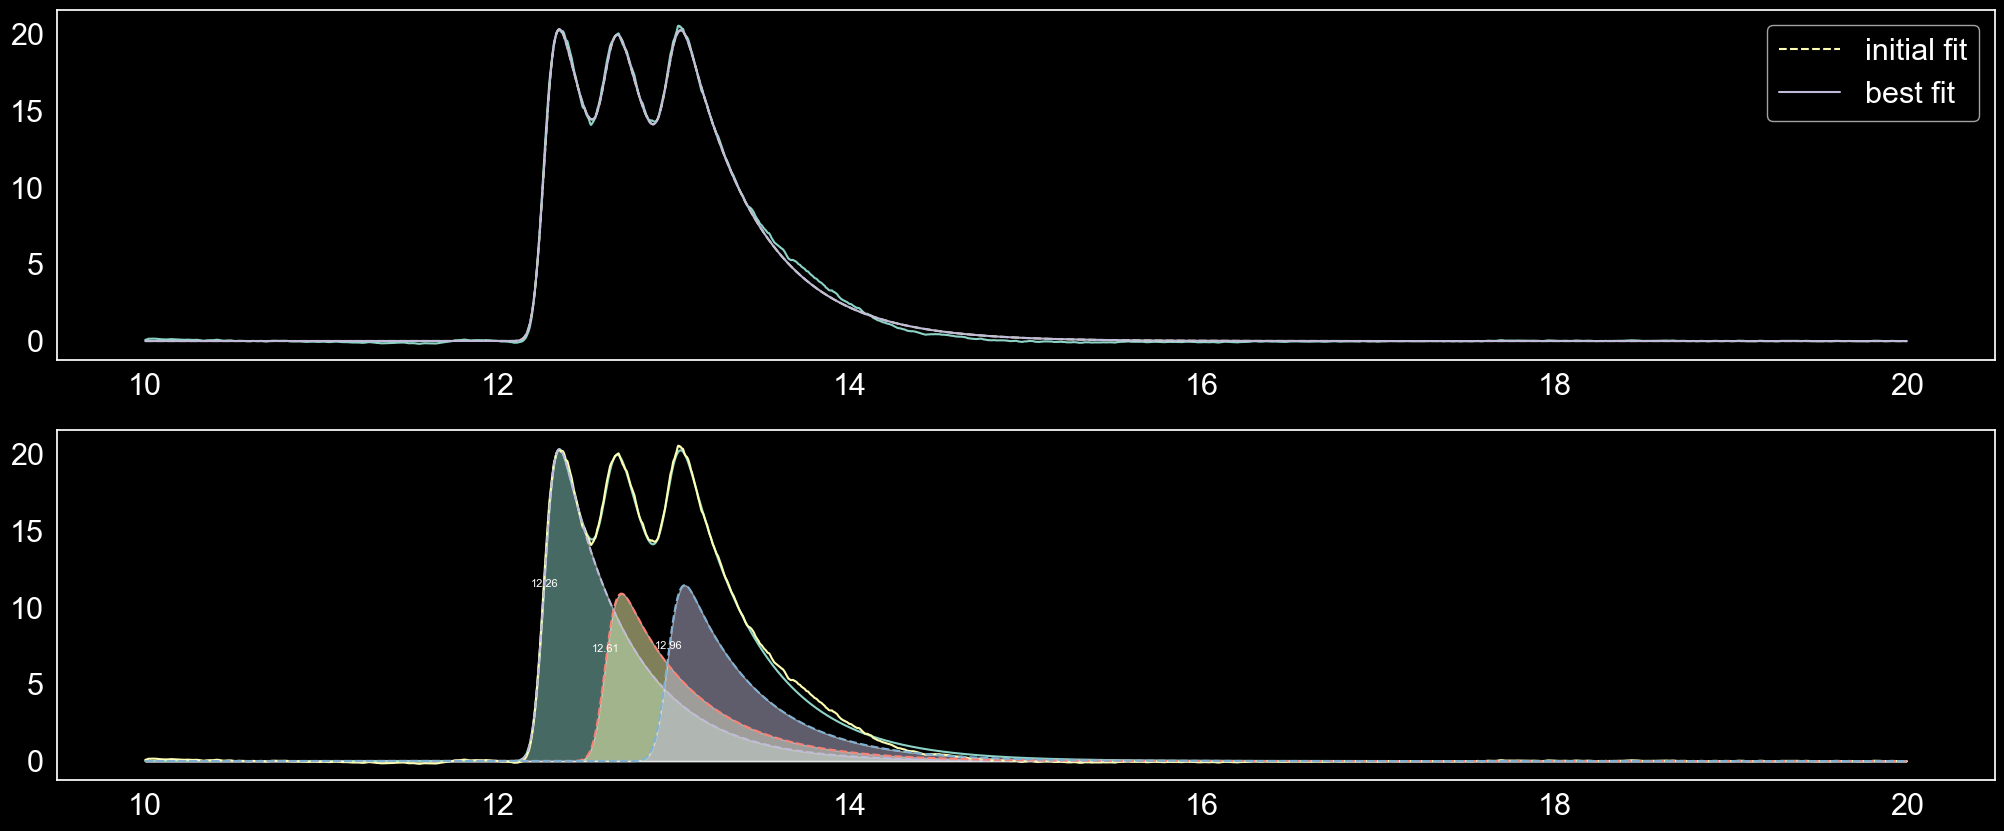

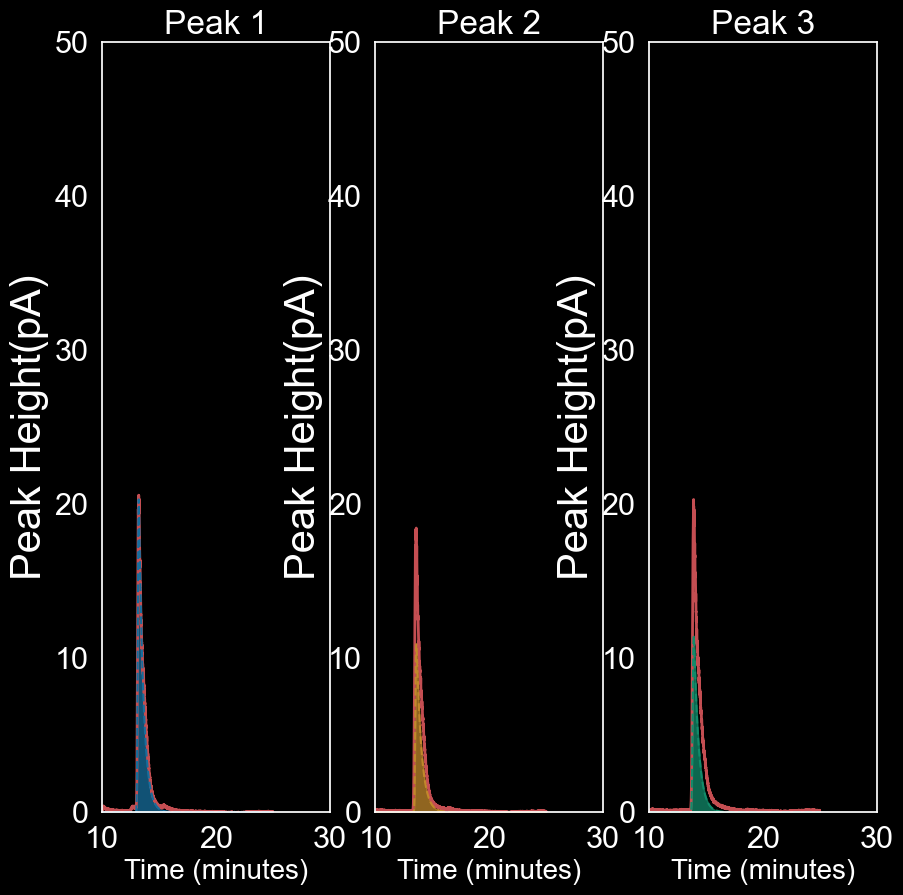

In [4]:
# Peak Climber
rmse_list=[]
for name in ["la_spike3","la_spike2","la_spike1",
            "equal1","equal2","equal3","equal4",
            "ara_spike1","ara_spike2","ara_spike3","ara_spike4",
            "dha_spike1","dha_spike2","dha_spike3"]:
    peak_size=[10,10,10]
    x=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']==name)]['Time']
    y=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']==name)]['Value']
    if "la_spike" in name:
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone10_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone10_4")]['Value']
        peak_size=[10,10,20]
    elif "equal" in name: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
    elif "ara" in name: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone10_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone10_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
        peak_size=[10,20,10]
    else: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone10_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone10_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
        peak_size=[20,10,10]
    #z=remove_noise(y,2000,1e11,20)
    df = pd.DataFrame()
    df["Time"]=x
    df["Value"]=y
    peaks=find_peak_areas(df,10,20,graph=True)
    centers=[p[q.idxmax()-50],z[w.idxmax()-50],j[k.idxmax()-50]]
    #centers=[]
    sigmas=[]
    amplitudes=[]
    gamma=[]
    for i in peaks[2]:
        #centers.append(i[0])
        sigmas.append(i[1])
        amplitudes.append(i[2])
        gamma.append(i[3])
    model=''
    for n in range(0,3):
        gaus=ExponentialGaussianModel(prefix='p'+str(n)+"_")
        #addition of first model for first peak
        if model=='':
            model=gaus
            pars=gaus.make_params(prefix='p'+str(n)+"_")
            #peak locations can vary by 1 min 
            pars['p'+str(n)+'_center'].set(value=centers[n],vary=False)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=sigmas[n],vary=False)
            #amplitude can only be so small to be a real peak 
            pars['p'+str(n)+'_amplitude'].set(value=amplitudes[n],vary=False)
            #gamma 
            pars['p'+str(n)+'_gamma'].set(value=gamma[n],vary=False)

        #all subsequent peaks    
        else:
            model+=gaus
            pars.update(gaus.make_params(prefix='p'+str(n)+"_"))
            pars['p'+str(n)+'_center'].set(value=centers[n],vary=False)
            pars['p'+str(n)+'_sigma'].set(value=sigmas[n],vary=False)
            pars['p'+str(n)+'_amplitude'].set(value=amplitudes[n],vary=False)
            pars['p'+str(n)+'_gamma'].set(value=gamma[n],vary=False)
    init = model.eval(pars, x=x)
    out = model.fit(y, pars, x=x)
    comps=out.eval_components(x=x)
    fig,ax2=plt.subplots(1,3,figsize=(10,10))

    colors=['#176E9D','#C2882B','#128B6A']
    ax2[0].plot(p,q,color='r',linewidth=2)
    ax2[1].plot(z,w,color='r',linewidth=2)
    ax2[2].plot(j,k,color='r',linewidth=2)
    sub_list=[q,w,k]
    for n in range(0,3):
        ax2[n].plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n),color=colors[n])
        ax2[n].fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.75,color=colors[n]) 
        summm=0
        for a, b in zip(sub_list[n],comps['p'+str(n)+"_"]):

           summm+=(a-b)*(a-b)
        rmse_list.append({"Peak Number":n+1,"RMSE":math.sqrt(summm/len(sub_list[n]))/(peak_size[n]/10),"Algorithm":"PeakClimber","Peak Mass(ug)":peak_size[n]})
        #adds peak location on the actual output graph 
        #ax.text(out.params['p'+str(n)+"_center"].value, out.params['p'+str(n)+"_amplitude"].value+1, str(out.params['p'+str(n)+"_center"].value)[0:5], fontsize=8,horizontalalignment='center')
        #calculates the area which is amplitude(SD)/(1/sqrt(2*pi))
        area=sum(comps['p'+str(n)+"_"])*0.01
        ax2[n].set_xlabel("Time (minutes)",size=20)
        ax2[n].set_ylabel("Peak Height(pA)",size=30)
        ax2[n].set(ylim=[0,50])
        ax2[n].set(xlim=[10,30])
        ax2[n].set_title("Peak "+str(n+1))
        #ax2[n].text(centers[n]+1,20, str(centers2[n]), fontsize = 22)


peakclimber_error=pd.DataFrame(rmse_list)   

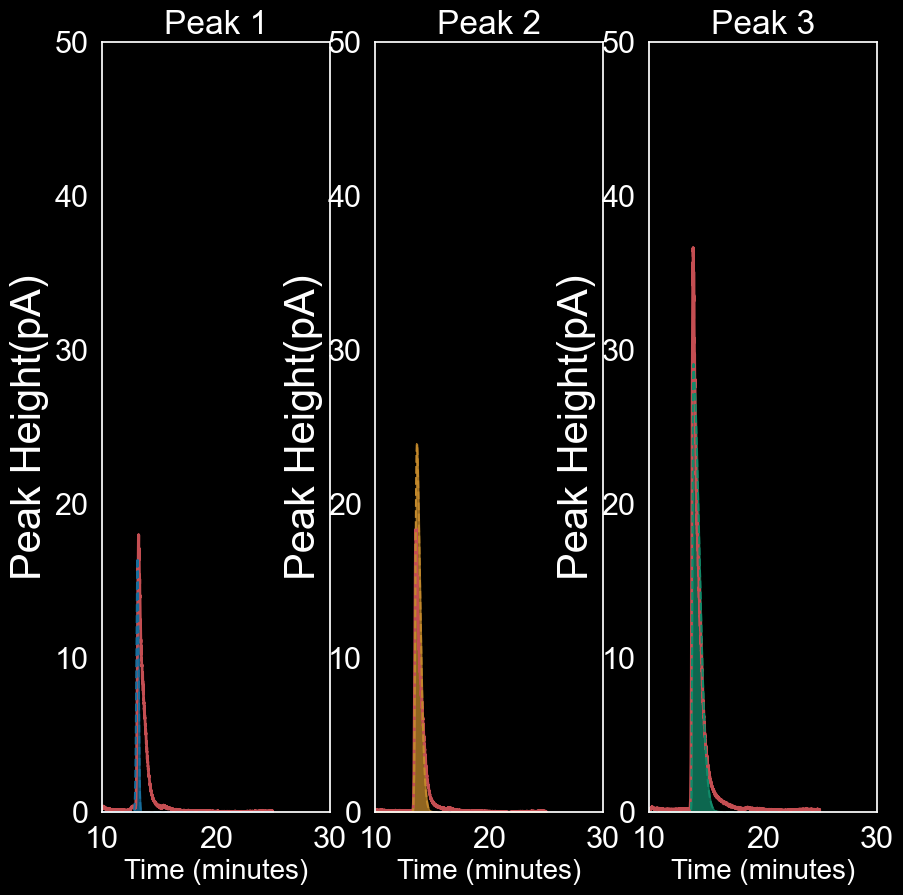

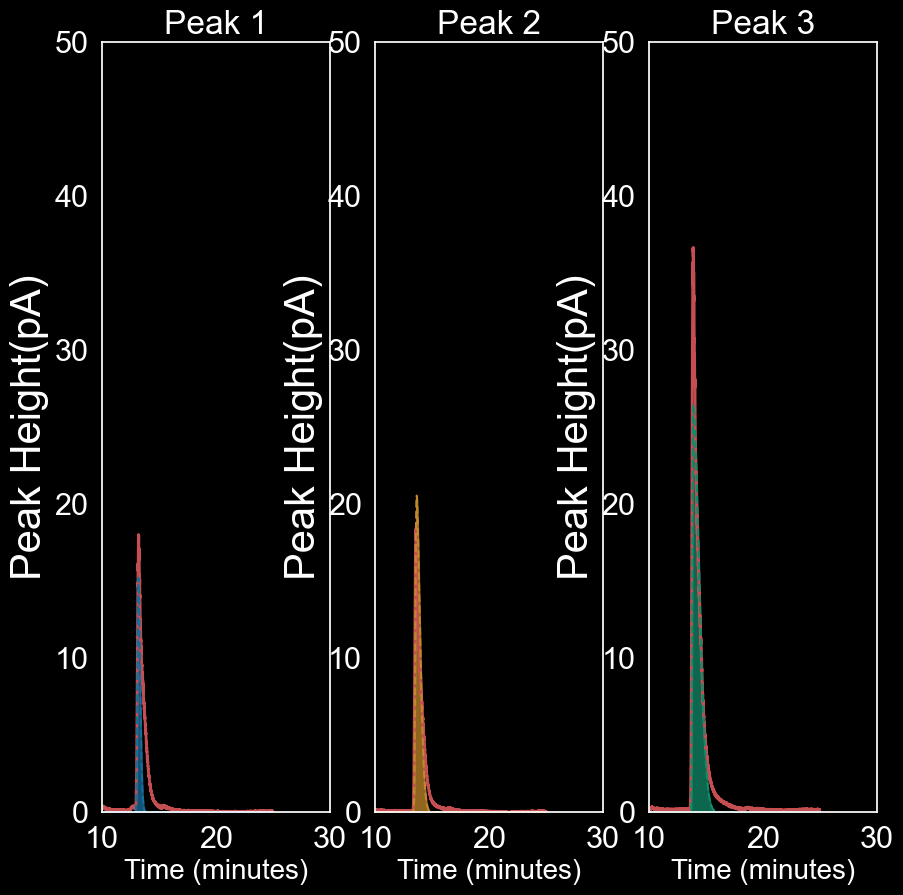

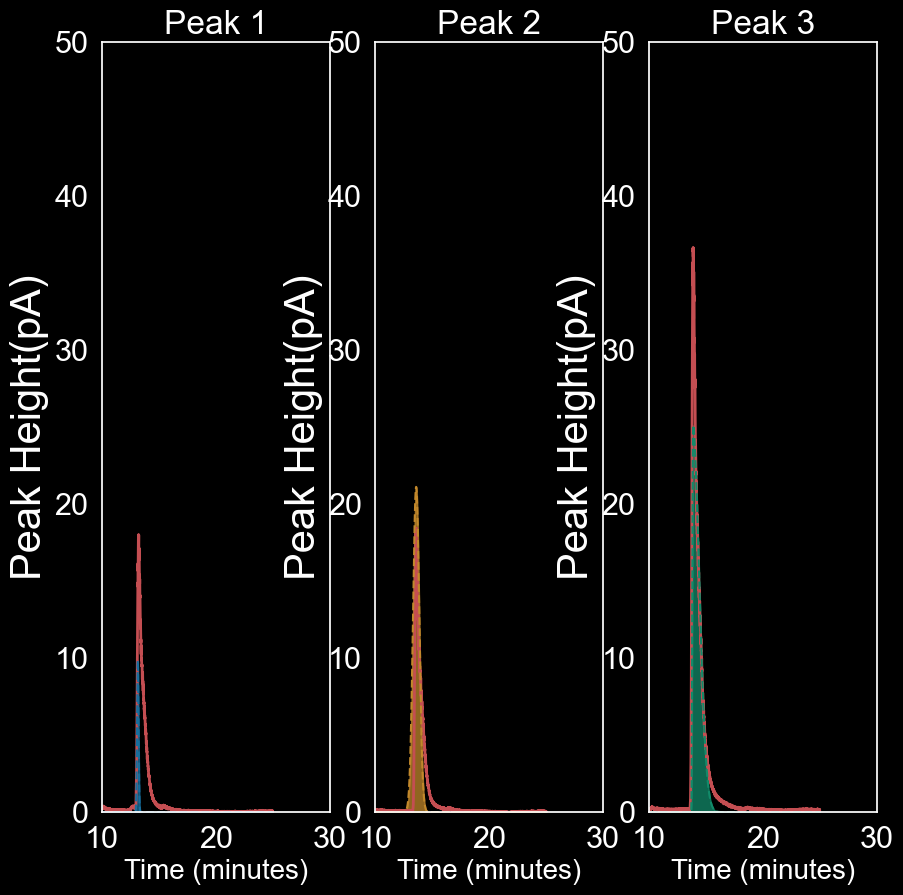

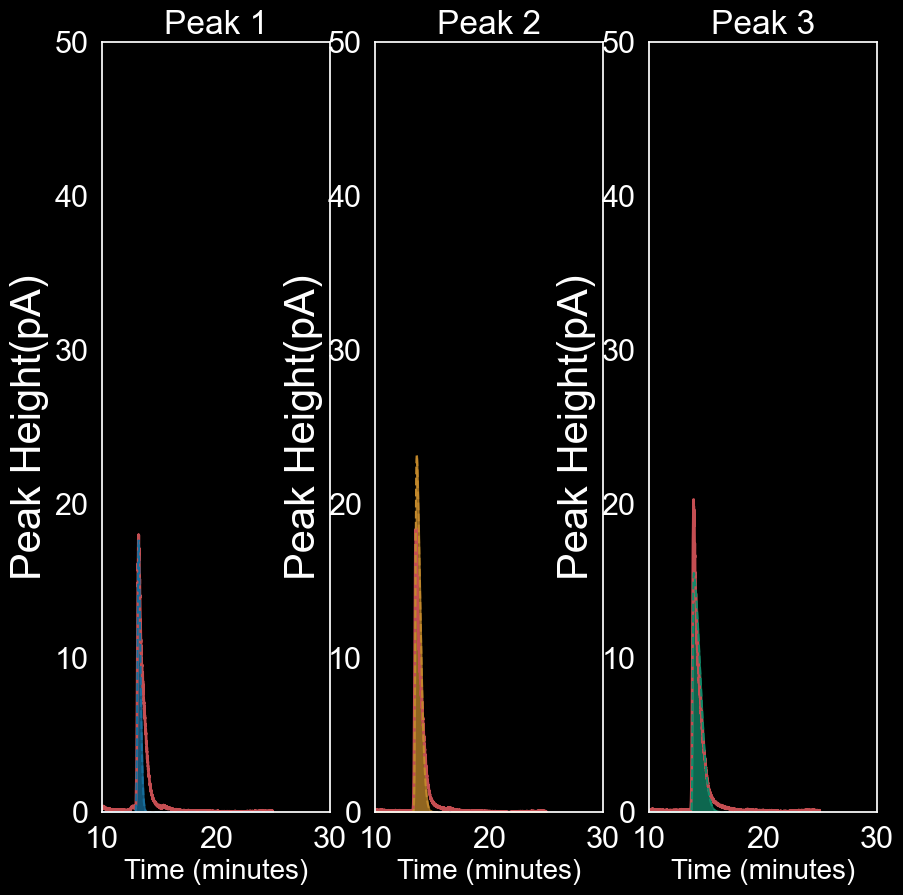

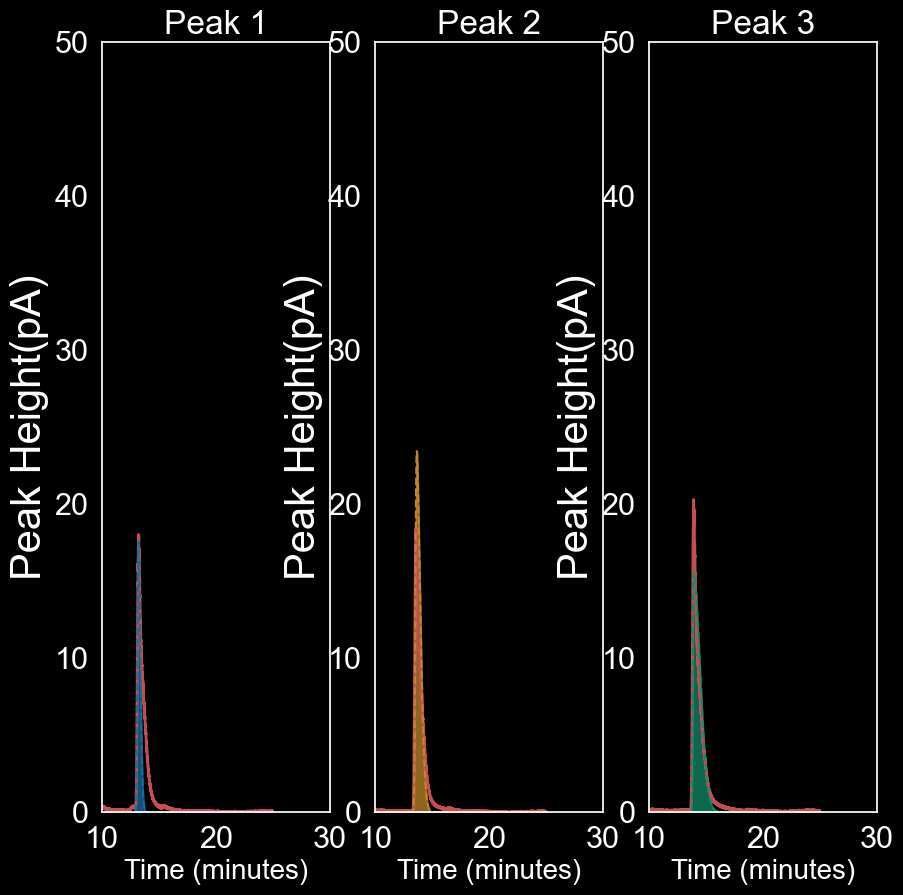

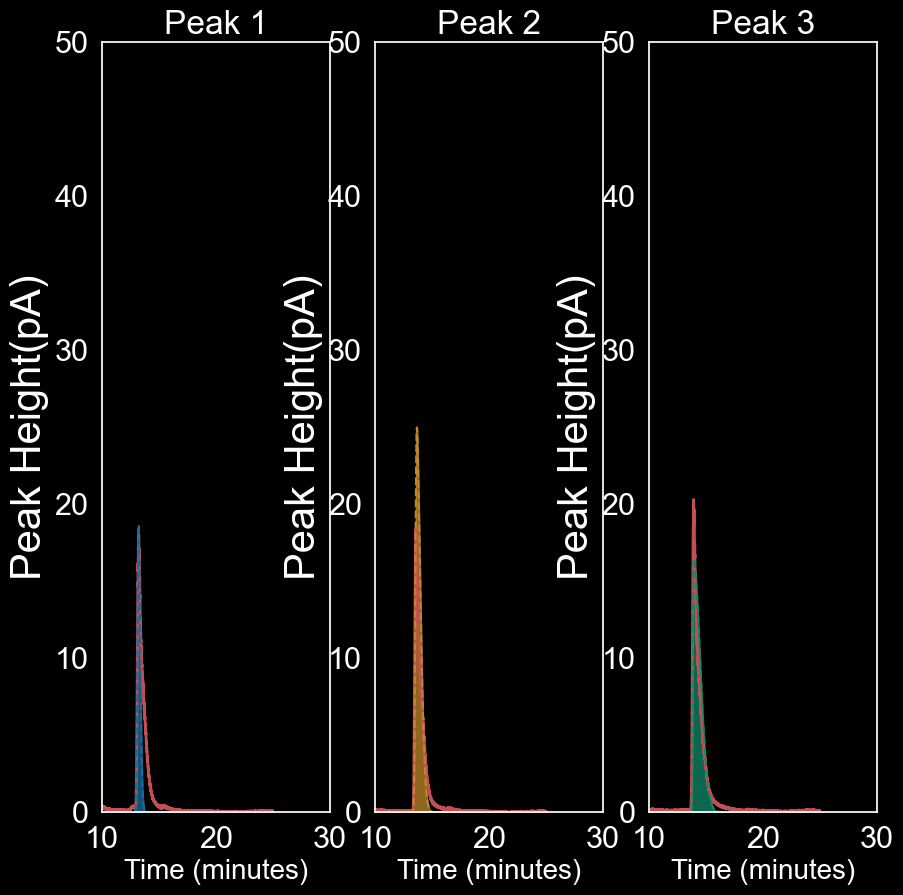

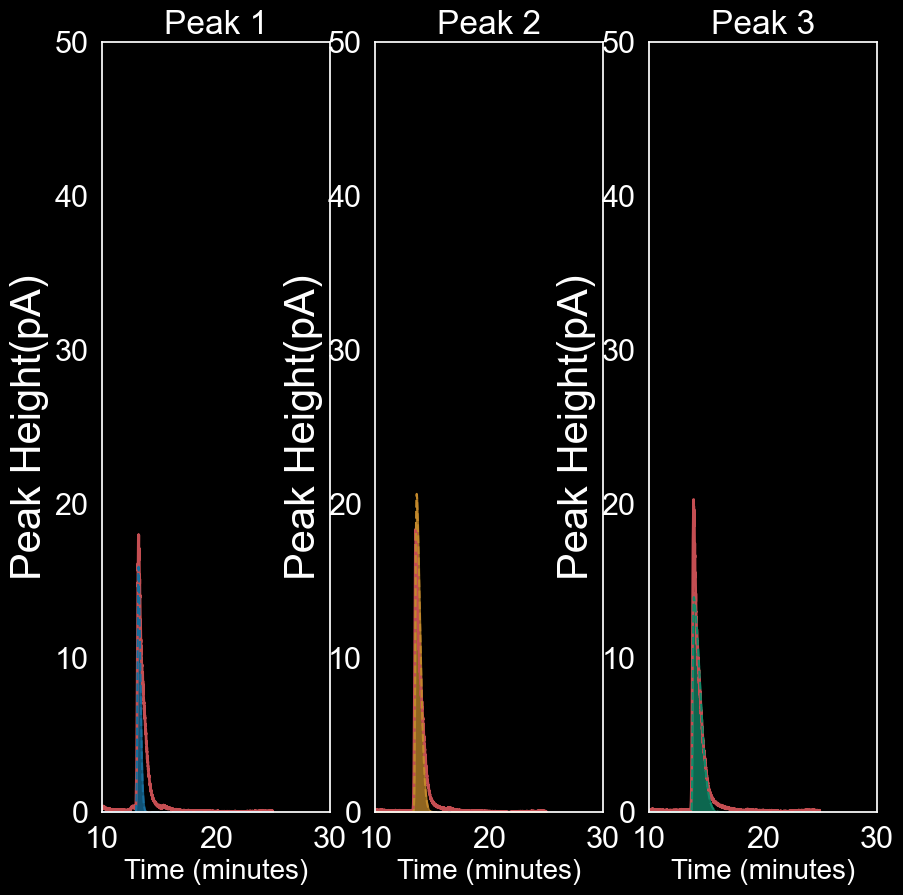

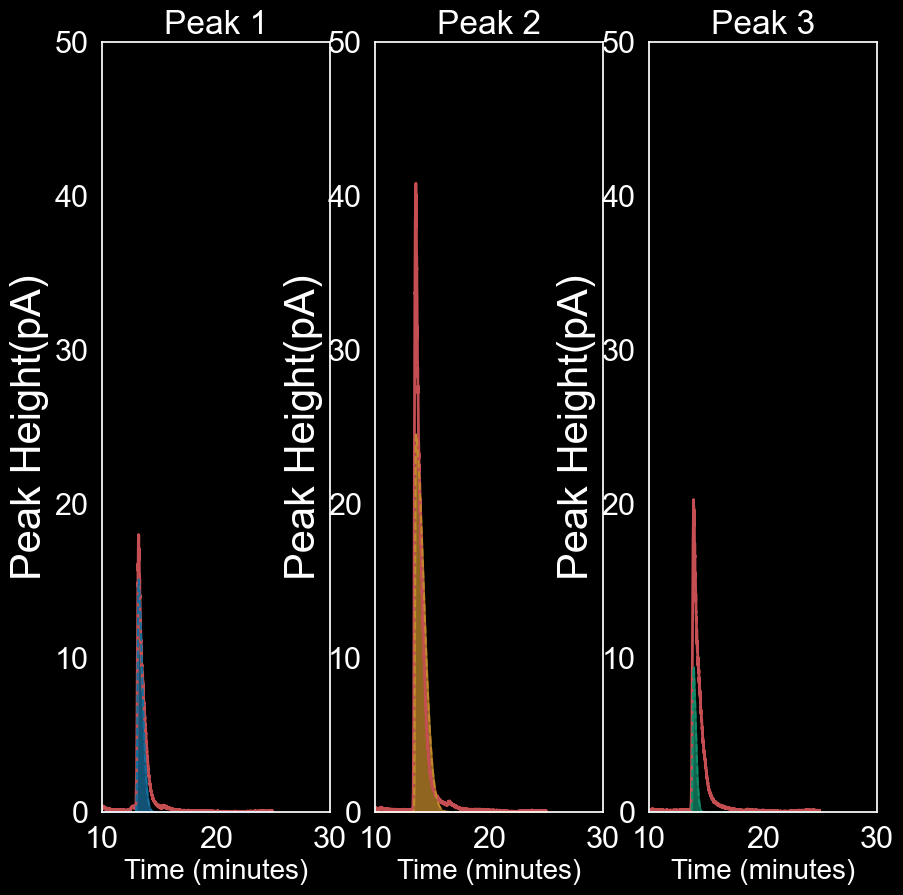

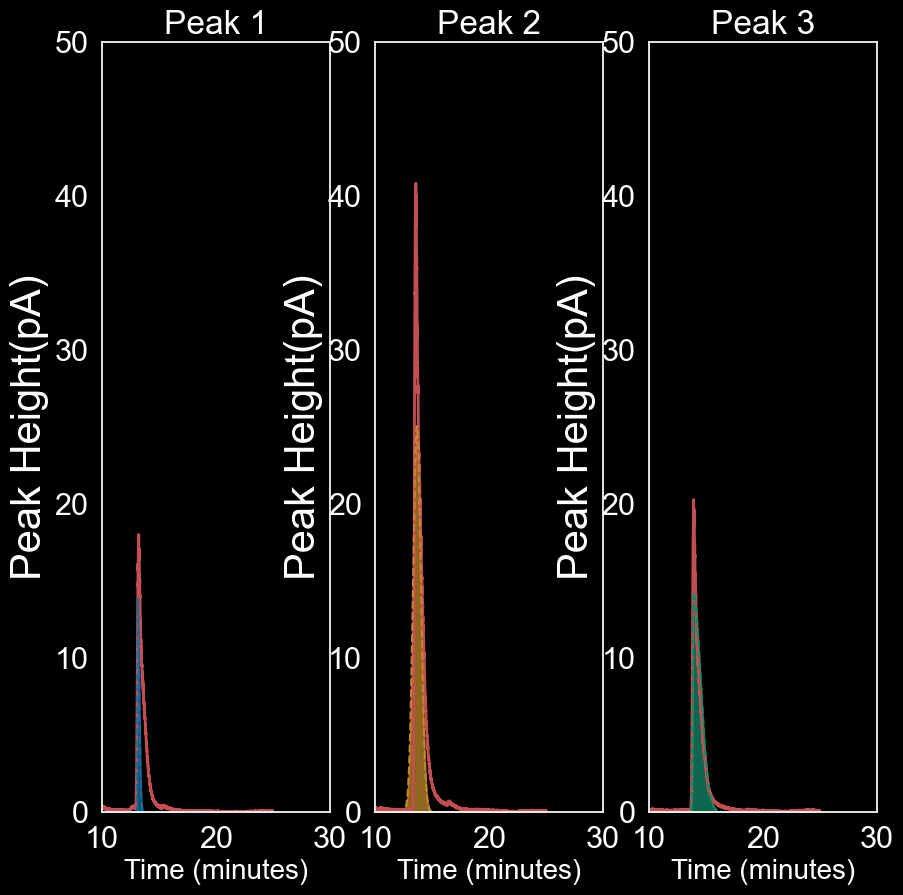

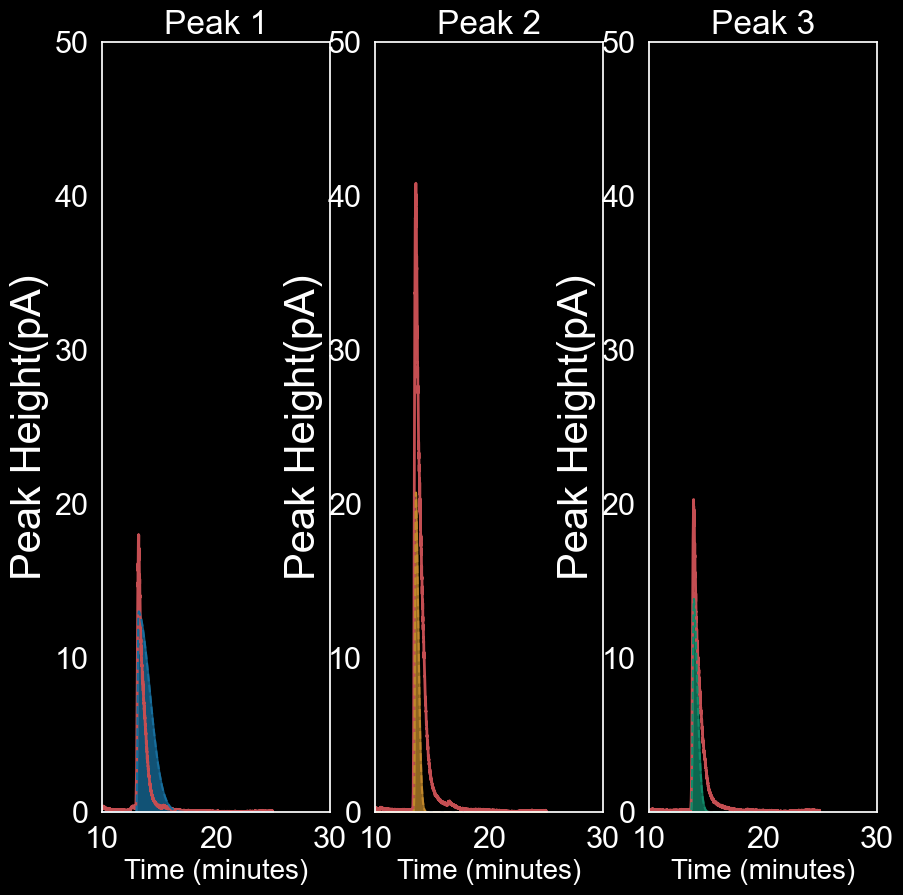

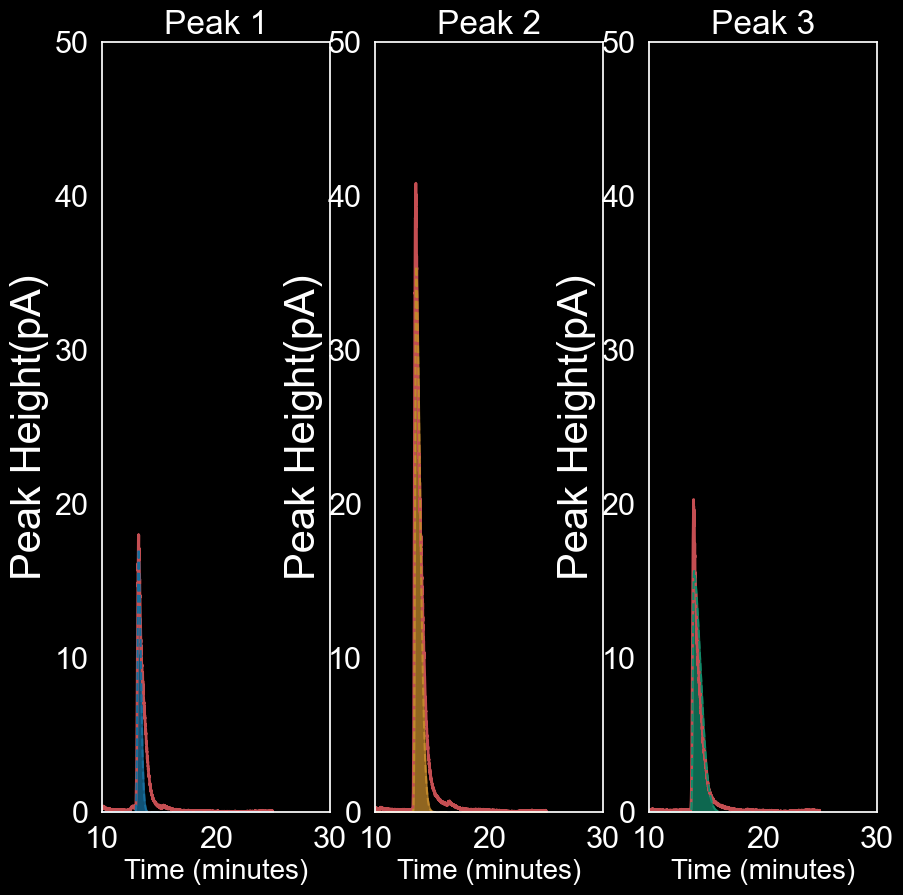

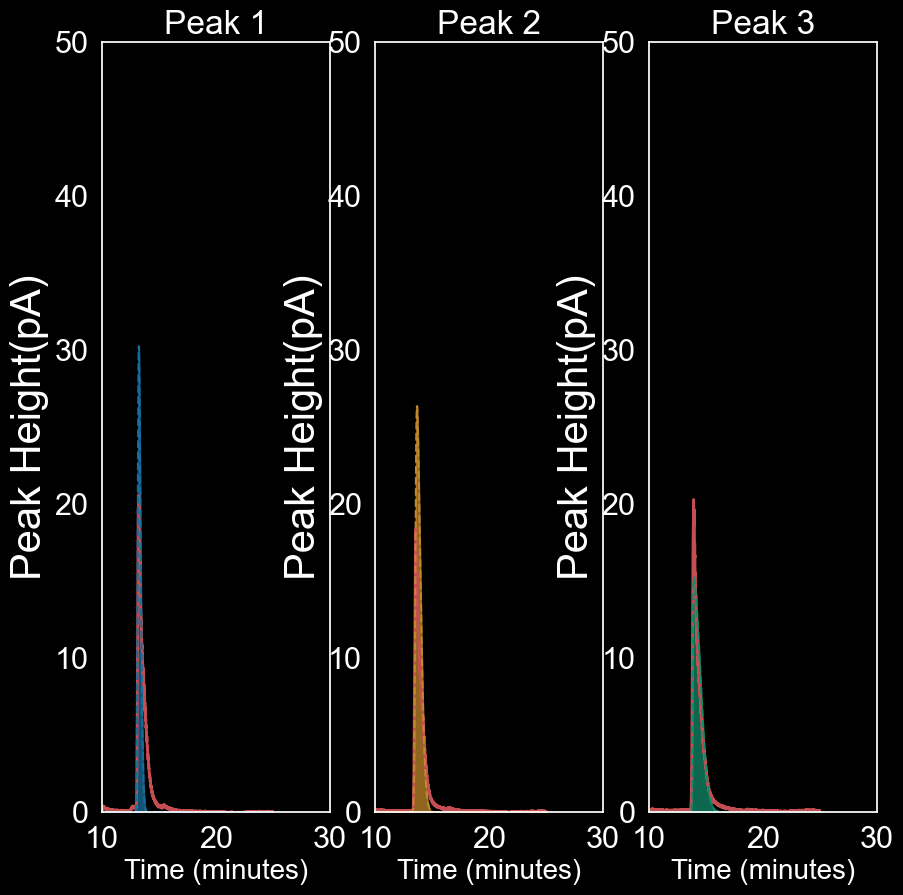

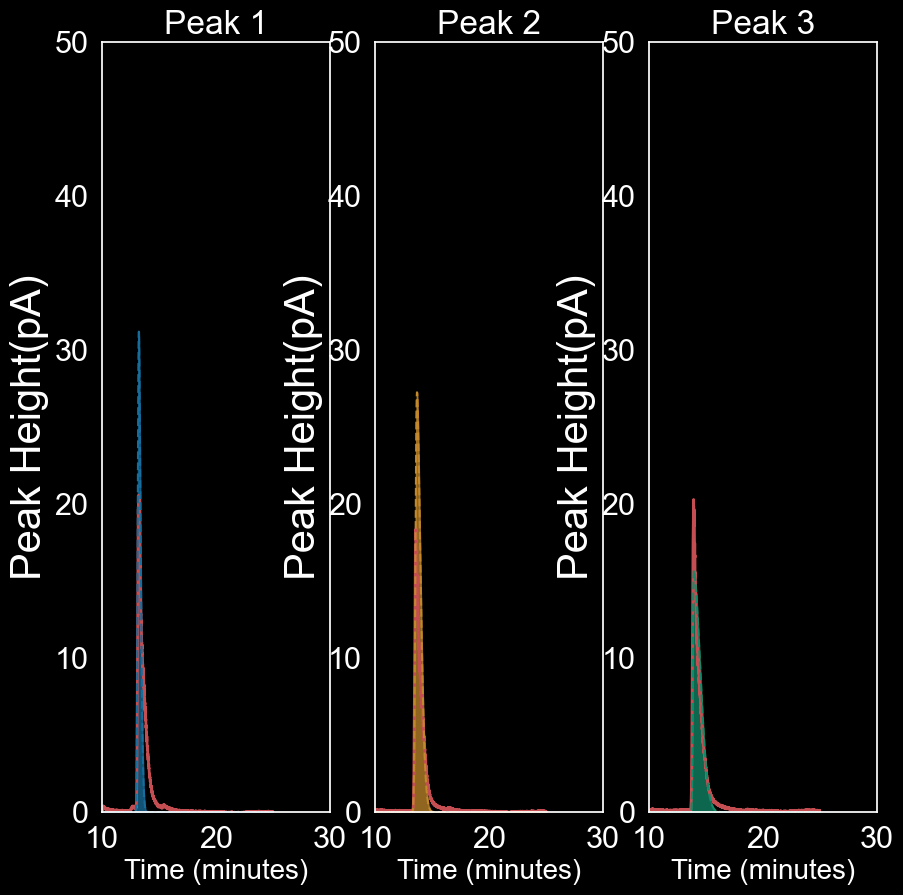

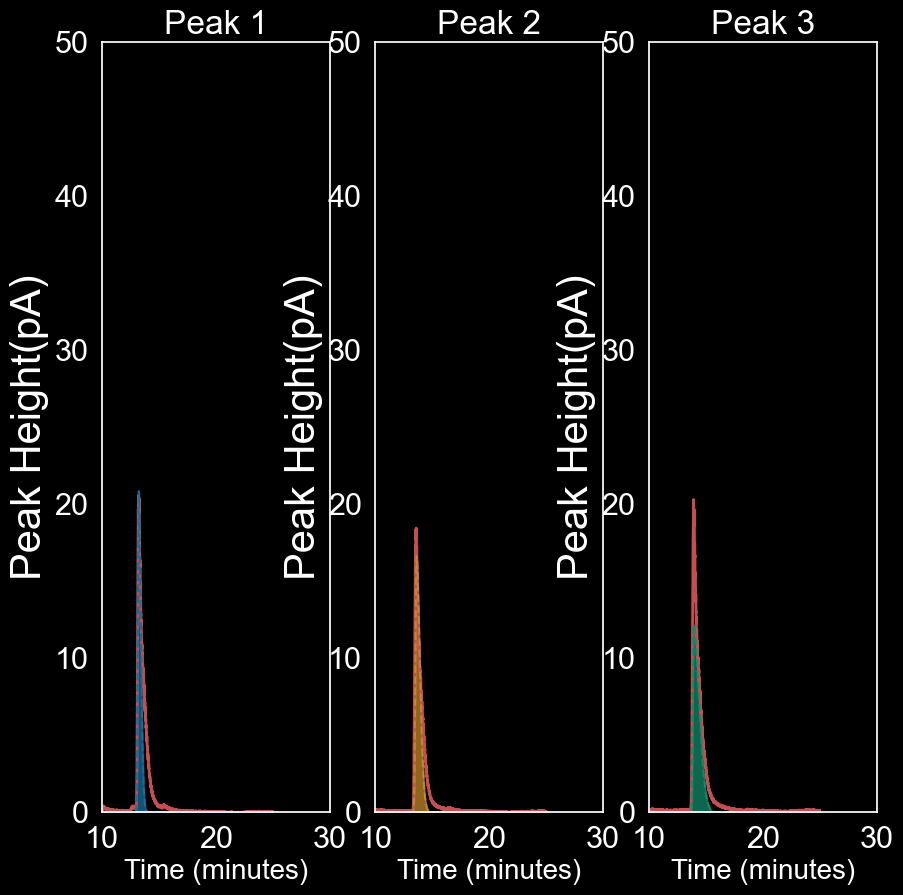

In [5]:
#hplc.io
rmse_list=[]
parameters=pd.read_excel("hplc_io_parameters.xlsx")
for name in ["la_spike3","la_spike2","la_spike1",
            "equal1","equal2","equal3","equal4",
            "ara_spike1","ara_spike2","ara_spike3","ara_spike4",
            "dha_spike1","dha_spike2","dha_spike3"]:
    peak_size=[10,10,10]
    x=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']==name)]['Time']
    y=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']==name)]['Value']
    if "la_spike" in name:
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone10_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone10_4")]['Value']
        peak_size=[10,10,20]
    elif "equal" in name: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
    elif "ara" in name: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone10_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone10_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
        peak_size=[10,20,10]
    else: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone10_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone10_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
        peak_size=[20,10,10]
    #z=remove_noise(y,2000,1e11,20)
    df = pd.DataFrame()
    centers=[p[q.idxmax()-50],z[w.idxmax()-50],j[k.idxmax()-50]]
    #centers=[]
    sigmas=[]
    amplitudes=[]
    gamma=[]
    for i in (1,2,3):
        #centers.append(i[0])
        sigmas.append(float(parameters[(parameters["Name"]==name)&(parameters["Peak"]==i)]["sigma"]))
        amplitudes.append(float(parameters[(parameters["Name"]==name)&(parameters["Peak"]==i)]["amplitude"]))
        gamma.append(float(parameters[(parameters["Name"]==name)&(parameters["Peak"]==i)]["skew"]))
    model=''
    for n in range(0,3):
        gaus=SkewedGaussianModel(prefix='p'+str(n)+"_")
        #addition of first model for first peak
        if model=='':
            model=gaus
            pars=gaus.make_params(prefix='p'+str(n)+"_")
            #peak locations can vary by 1 min 
            pars['p'+str(n)+'_center'].set(value=centers[n],vary=False)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=sigmas[n],vary=False)
            #amplitude can only be so small to be a real peak 
            pars['p'+str(n)+'_amplitude'].set(value=amplitudes[n],vary=False)
            #gamma 
            pars['p'+str(n)+'_gamma'].set(value=gamma[n],vary=False)

        #all subsequent peaks    
        else:
            model+=gaus
            pars.update(gaus.make_params(prefix='p'+str(n)+"_"))
            pars['p'+str(n)+'_center'].set(value=centers[n],vary=False)
            pars['p'+str(n)+'_sigma'].set(value=sigmas[n],vary=False)
            pars['p'+str(n)+'_amplitude'].set(value=amplitudes[n],vary=False)
            pars['p'+str(n)+'_gamma'].set(value=gamma[n],vary=False)
    init = model.eval(pars, x=x)
    out = model.fit(y, pars, x=x)
    comps=out.eval_components(x=x)
    fig,ax2=plt.subplots(1,3,figsize=(10,10))

    colors=['#176E9D','#C2882B','#128B6A']
    ax2[0].plot(p,q,color='r',linewidth=2)
    ax2[1].plot(z,w,color='r',linewidth=2)
    ax2[2].plot(j,k,color='r',linewidth=2)
    sub_list=[q,w,k]
    for n in range(0,3):
        ax2[n].plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n),color=colors[n])
        ax2[n].fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.75,color=colors[n]) 
        summm=0
        for a, b in zip(sub_list[n],comps['p'+str(n)+"_"]):

           summm+=(a-b)*(a-b)
        rmse_list.append({"Peak Number":n+1,"RMSE":math.sqrt(summm/len(sub_list[n]))/(peak_size[n]/10),"Algorithm":"hplc.io","Peak Mass(ug)":peak_size[n]})
        #adds peak location on the actual output graph 
        #ax.text(out.params['p'+str(n)+"_center"].value, out.params['p'+str(n)+"_amplitude"].value+1, str(out.params['p'+str(n)+"_center"].value)[0:5], fontsize=8,horizontalalignment='center')
        #calculates the area which is amplitude(SD)/(1/sqrt(2*pi))
        area=sum(comps['p'+str(n)+"_"])*0.01
        ax2[n].set_xlabel("Time (minutes)",size=20)
        ax2[n].set_ylabel("Peak Height(pA)",size=30)
        ax2[n].set(ylim=[0,50])
        ax2[n].set(xlim=[10,30])
        ax2[n].set_title("Peak "+str(n+1))
        #ax2[n].text(centers[n]+1,20, str(centers2[n]), fontsize = 22)


hplc_error=pd.DataFrame(rmse_list)   

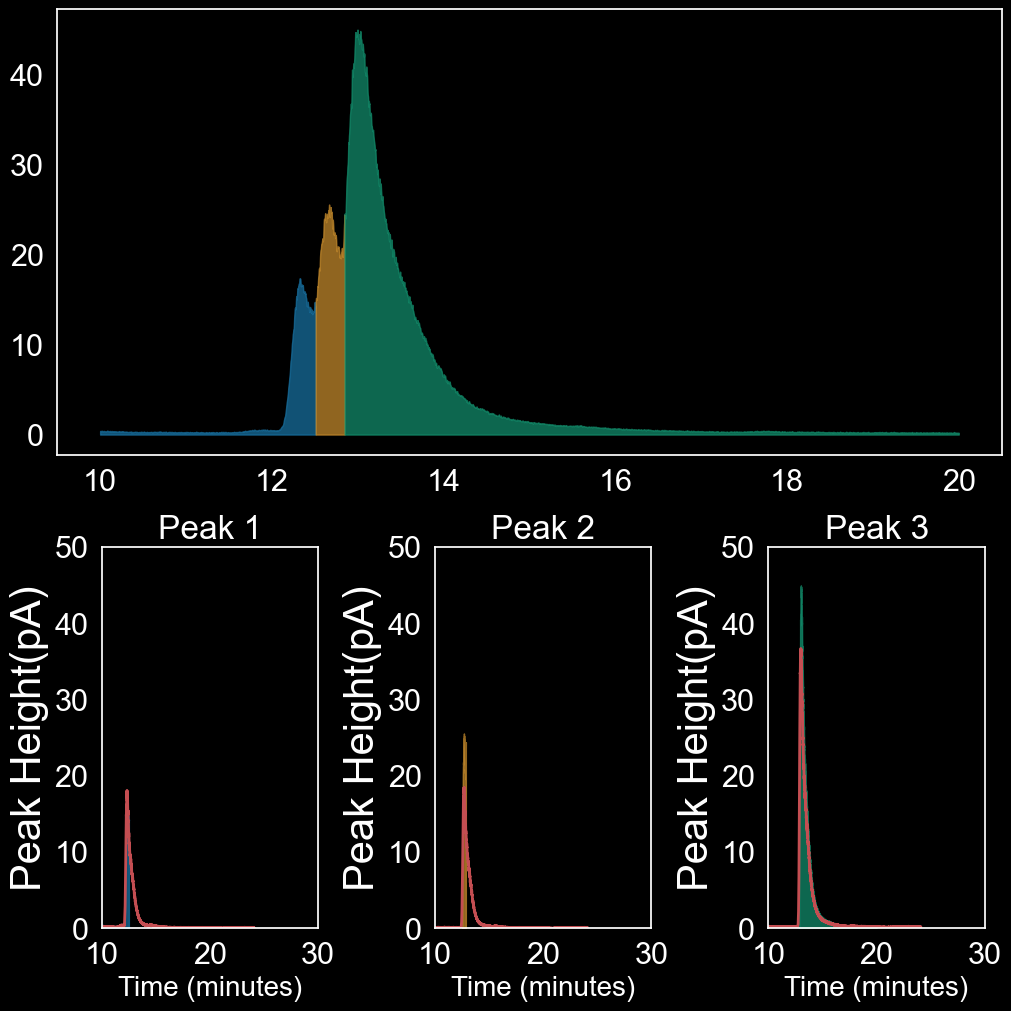

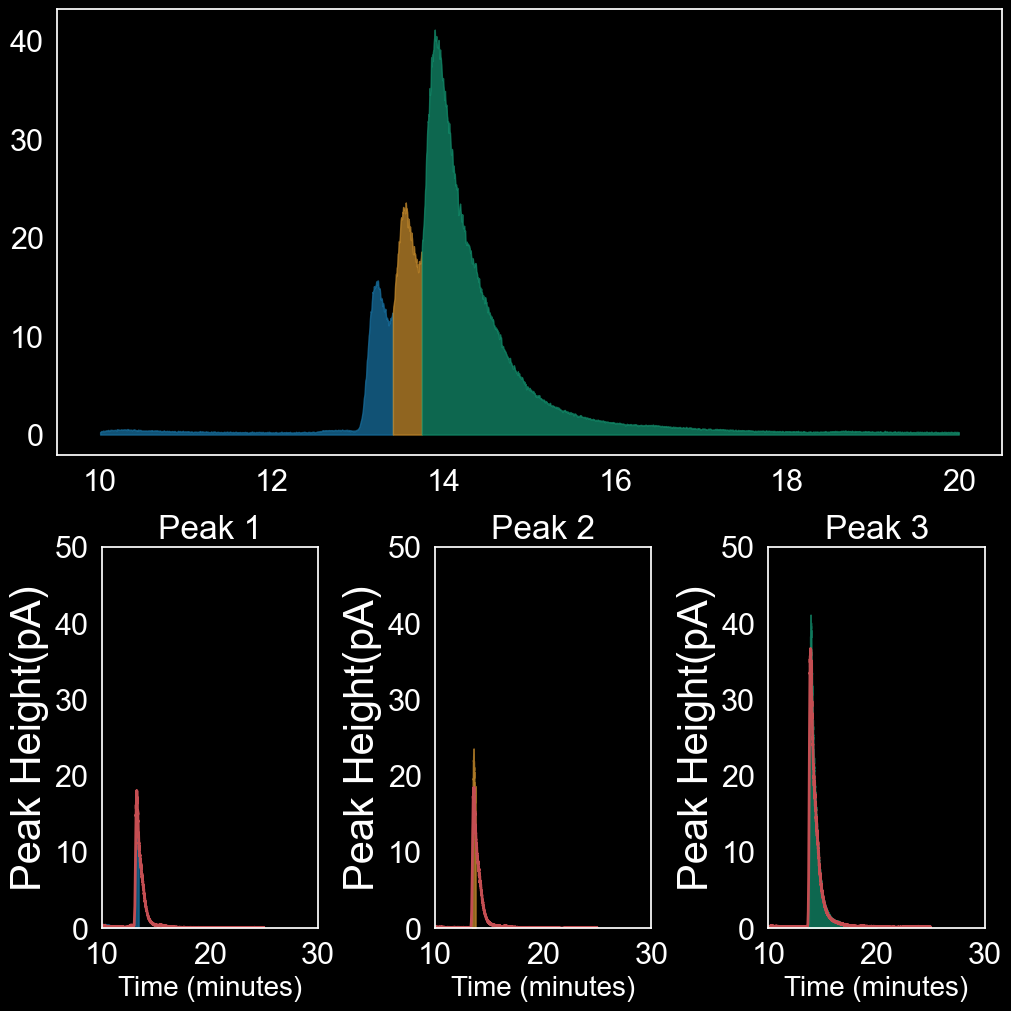

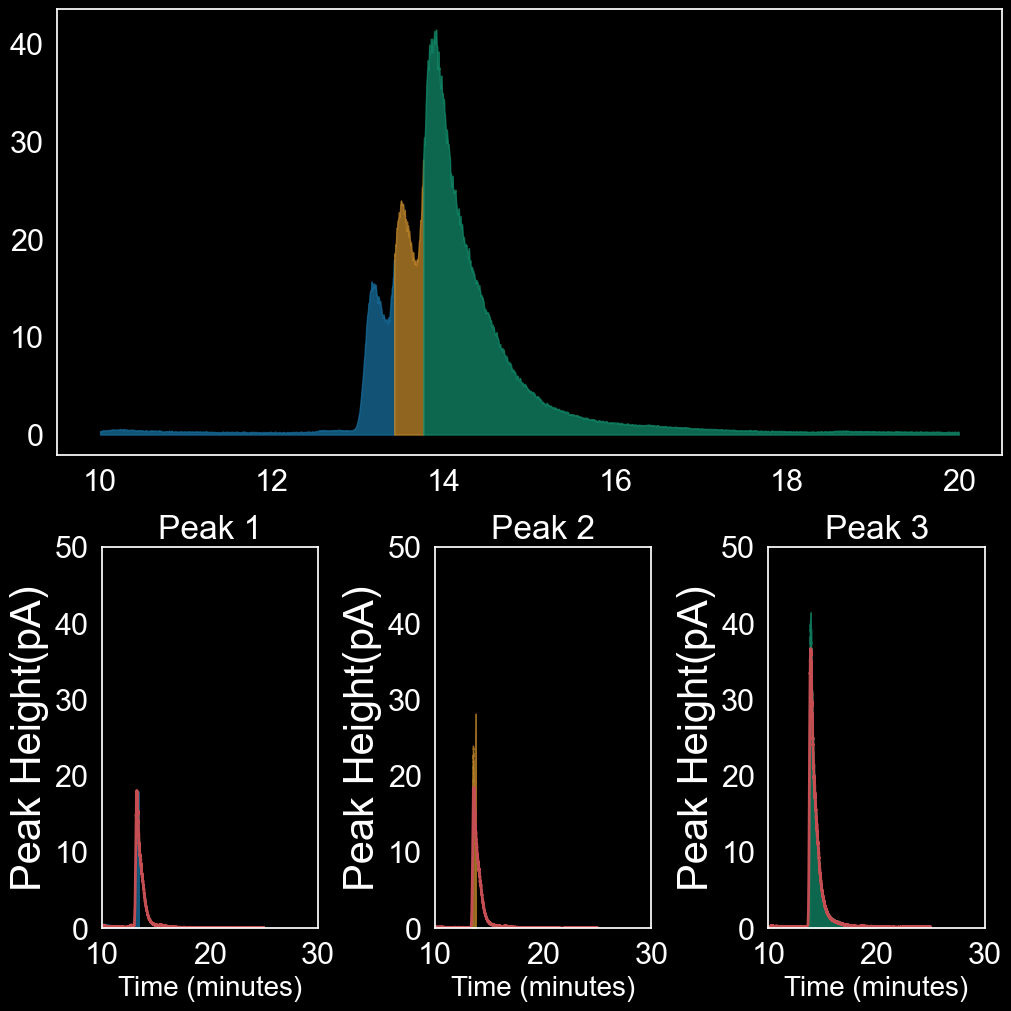

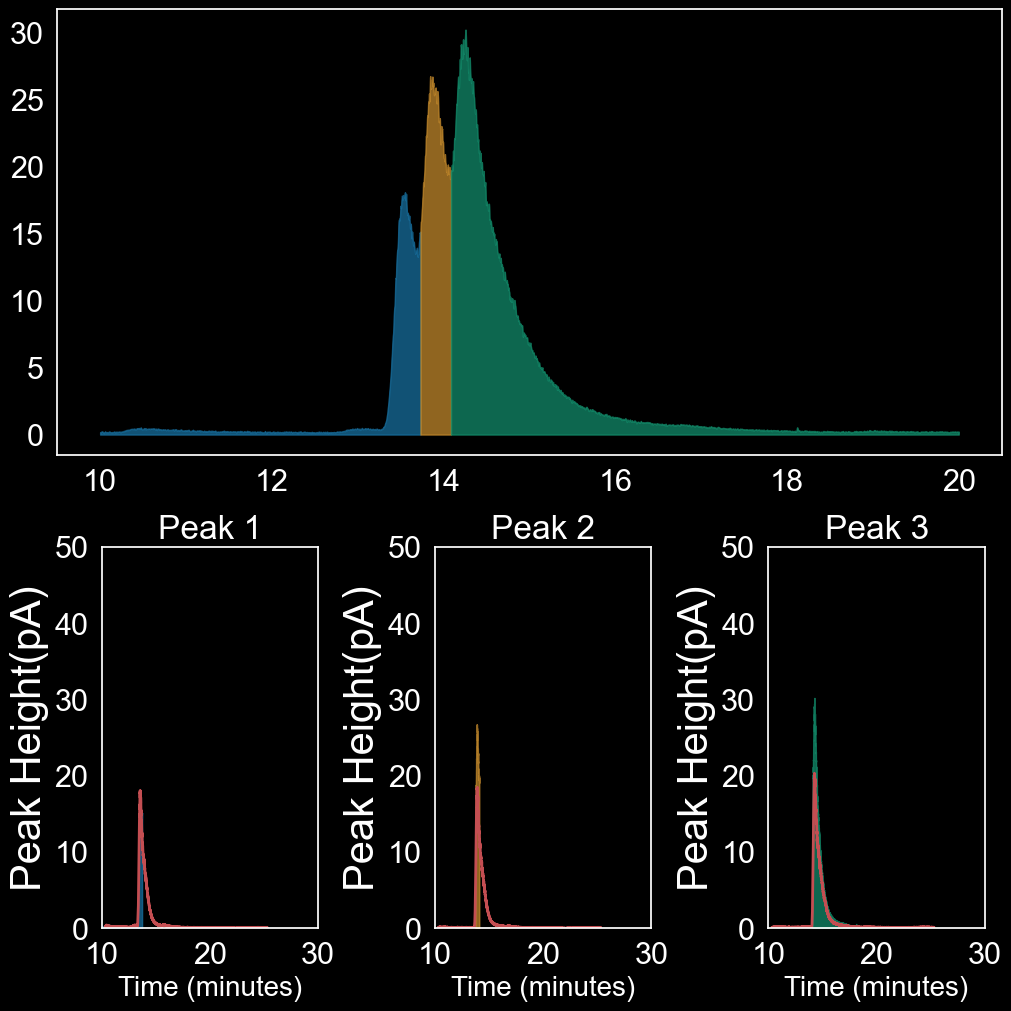

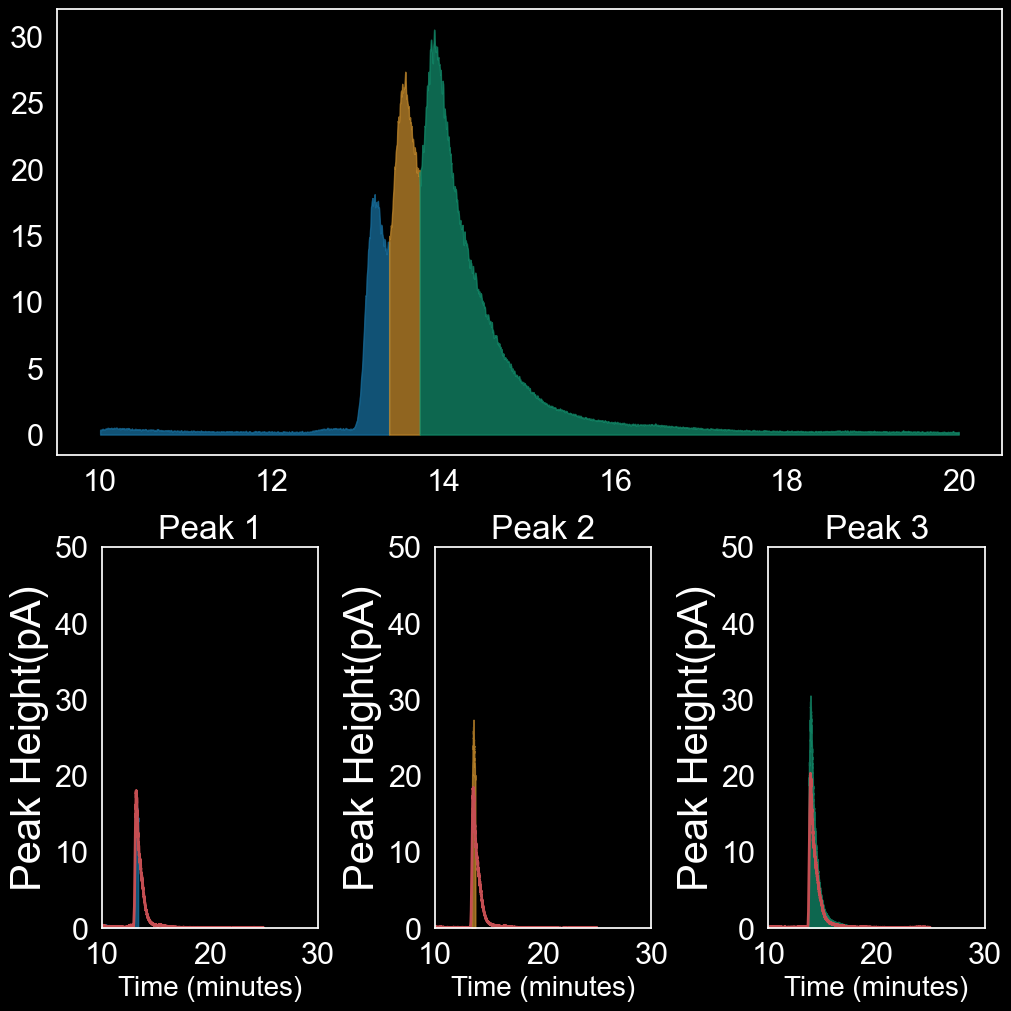

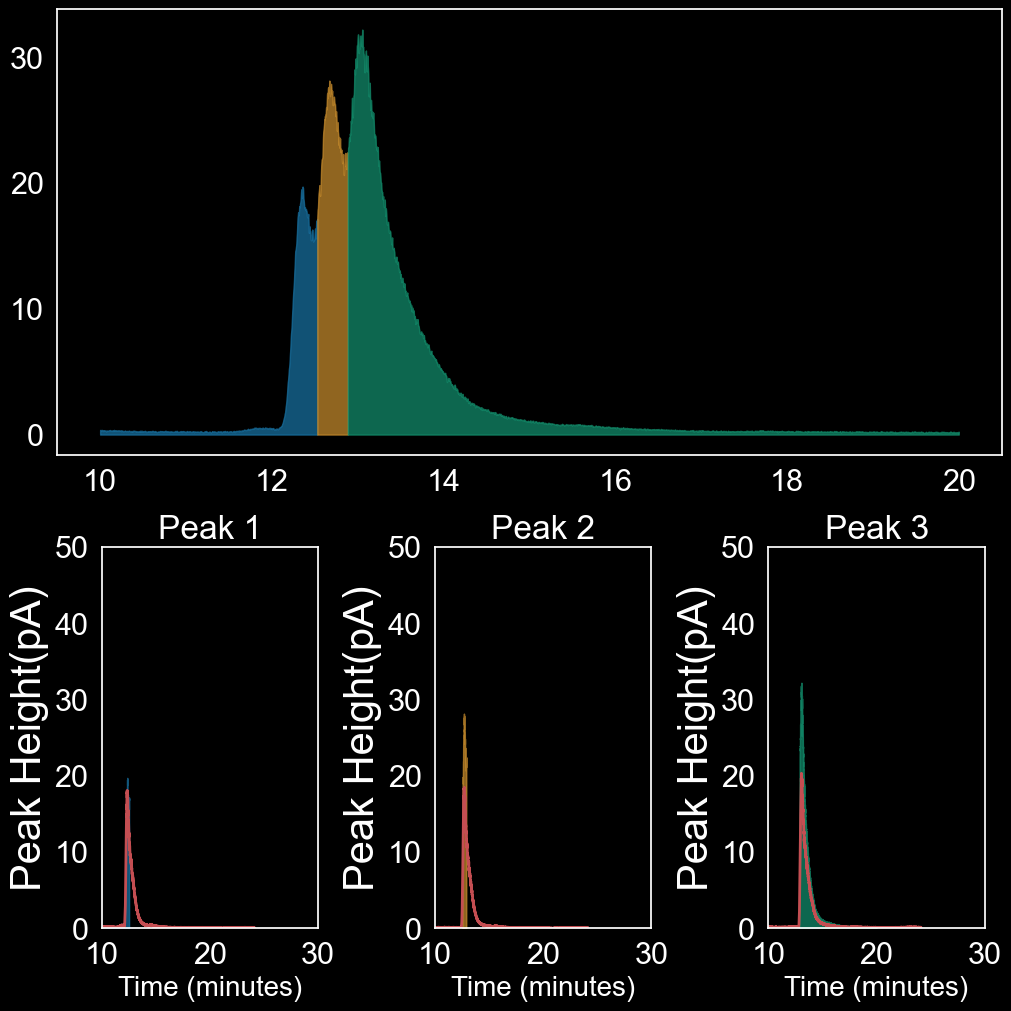

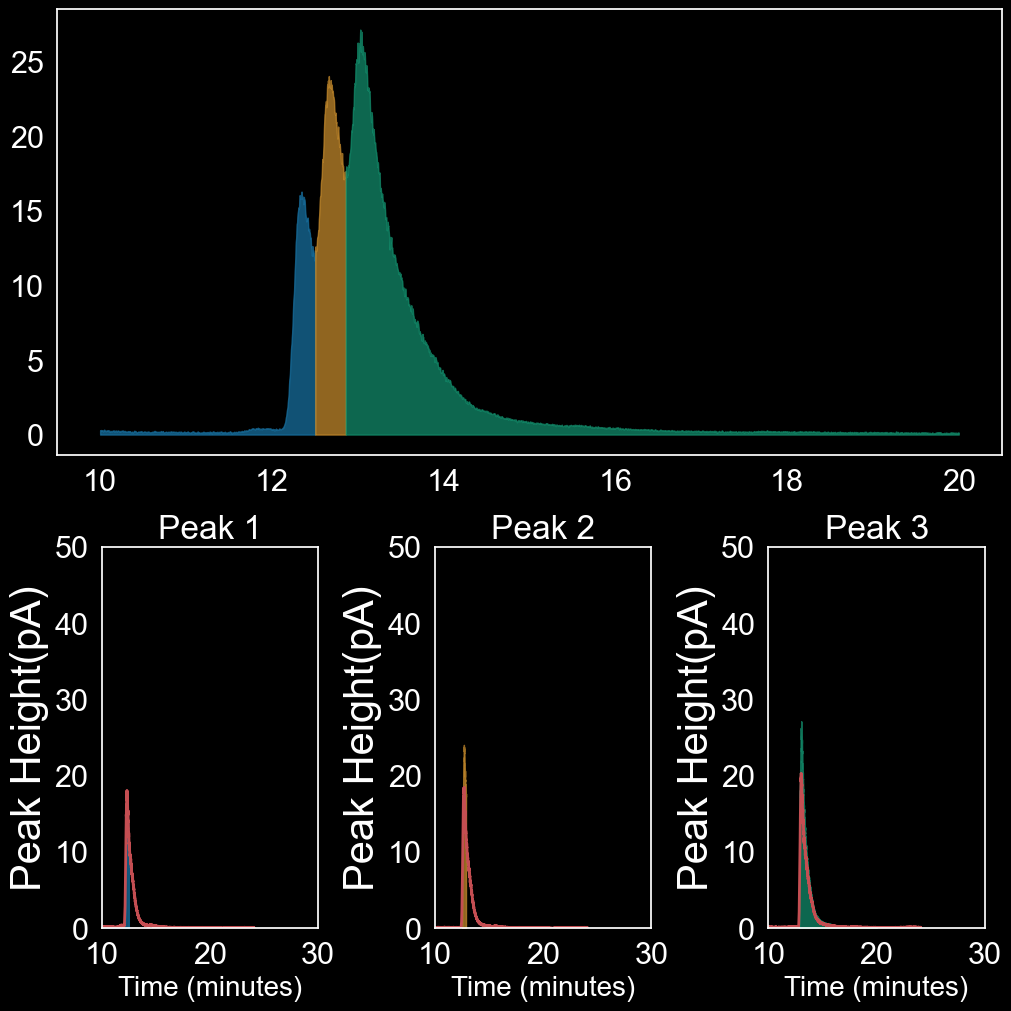

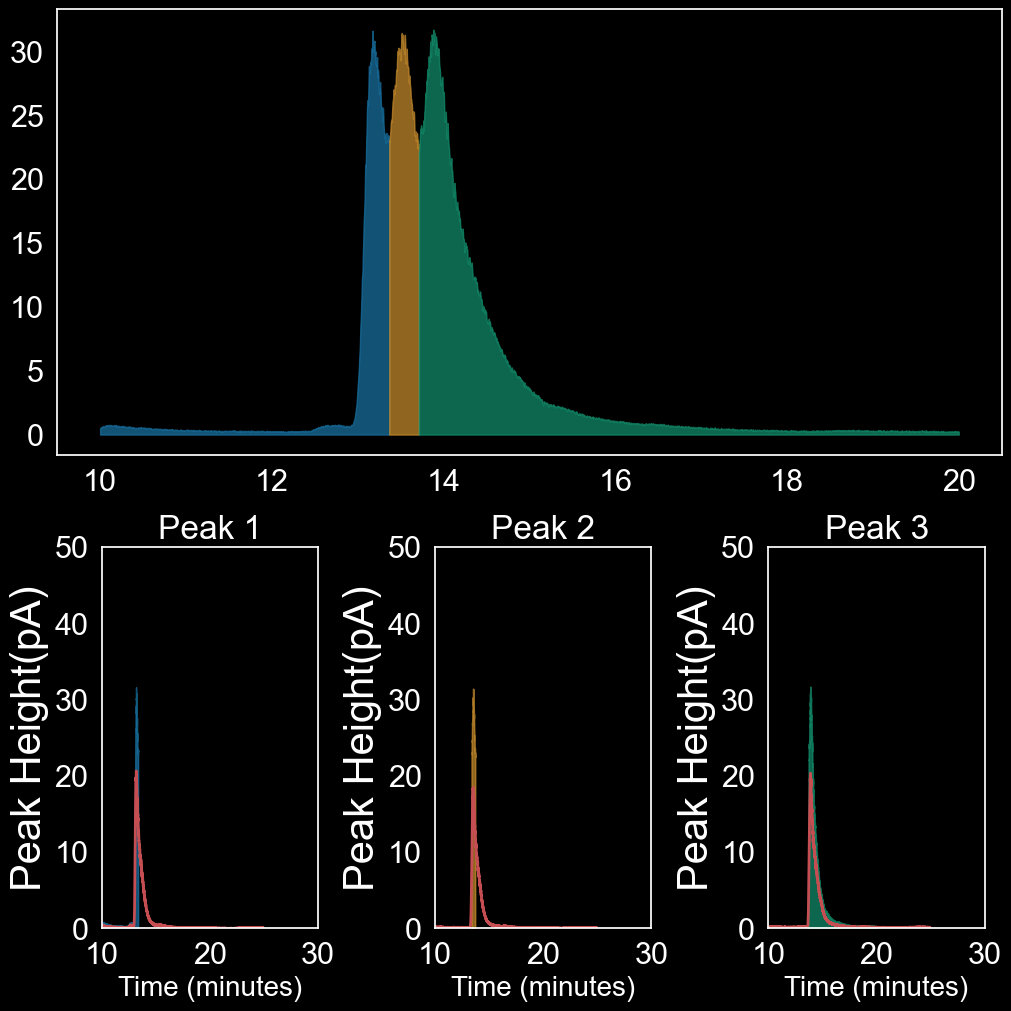

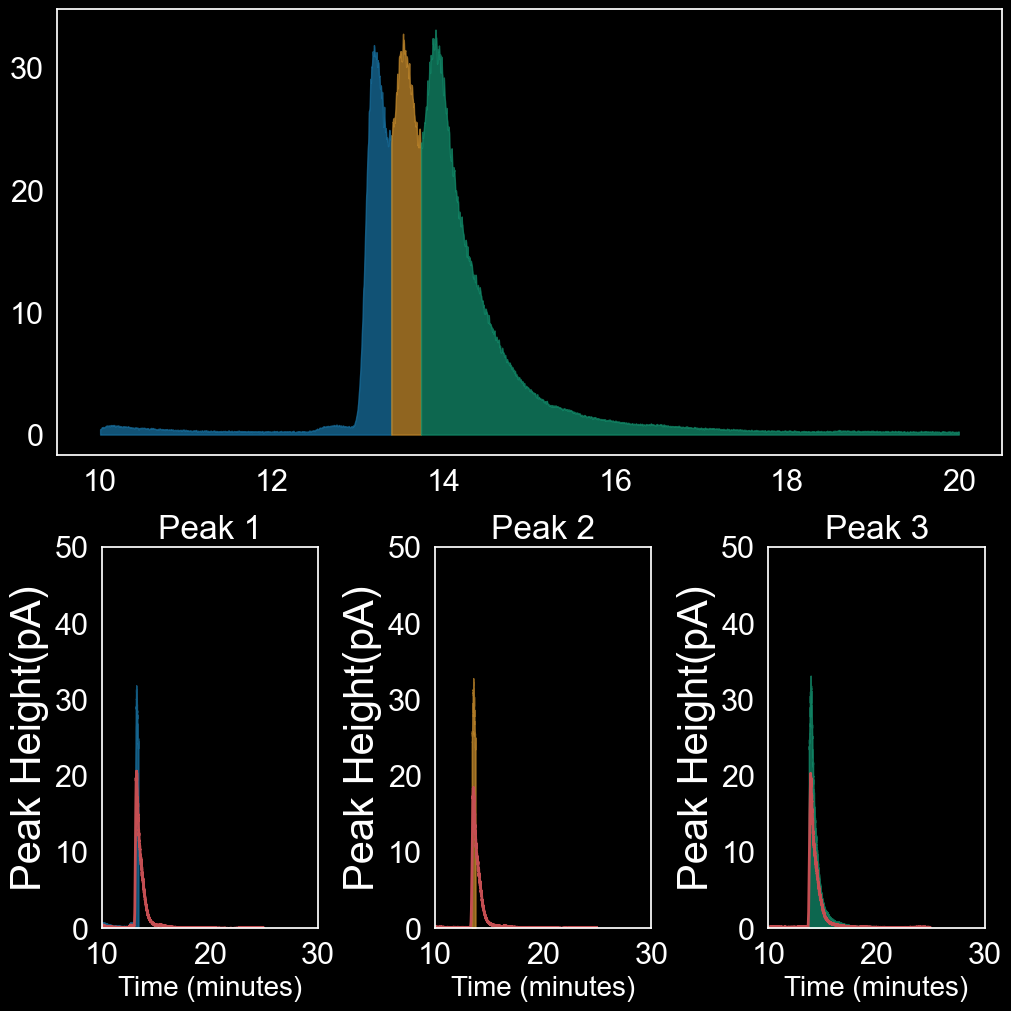

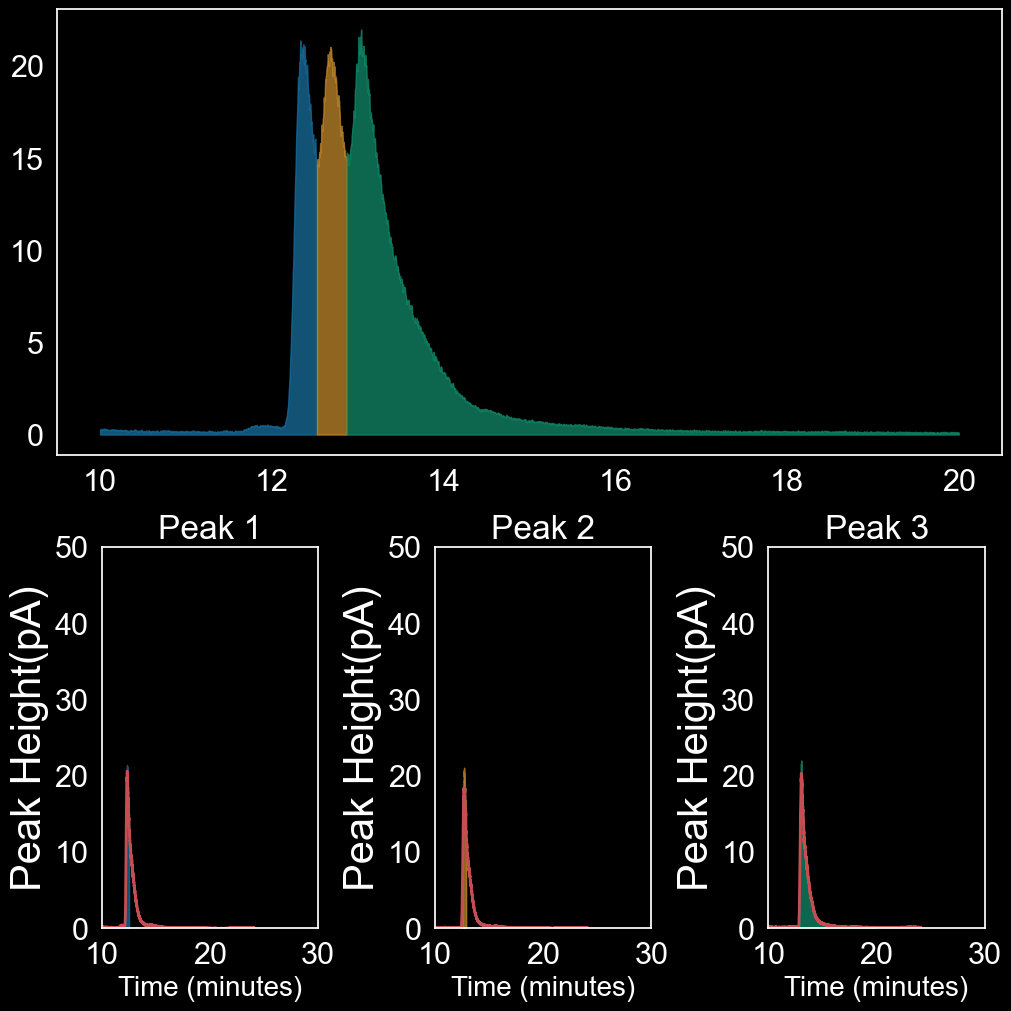

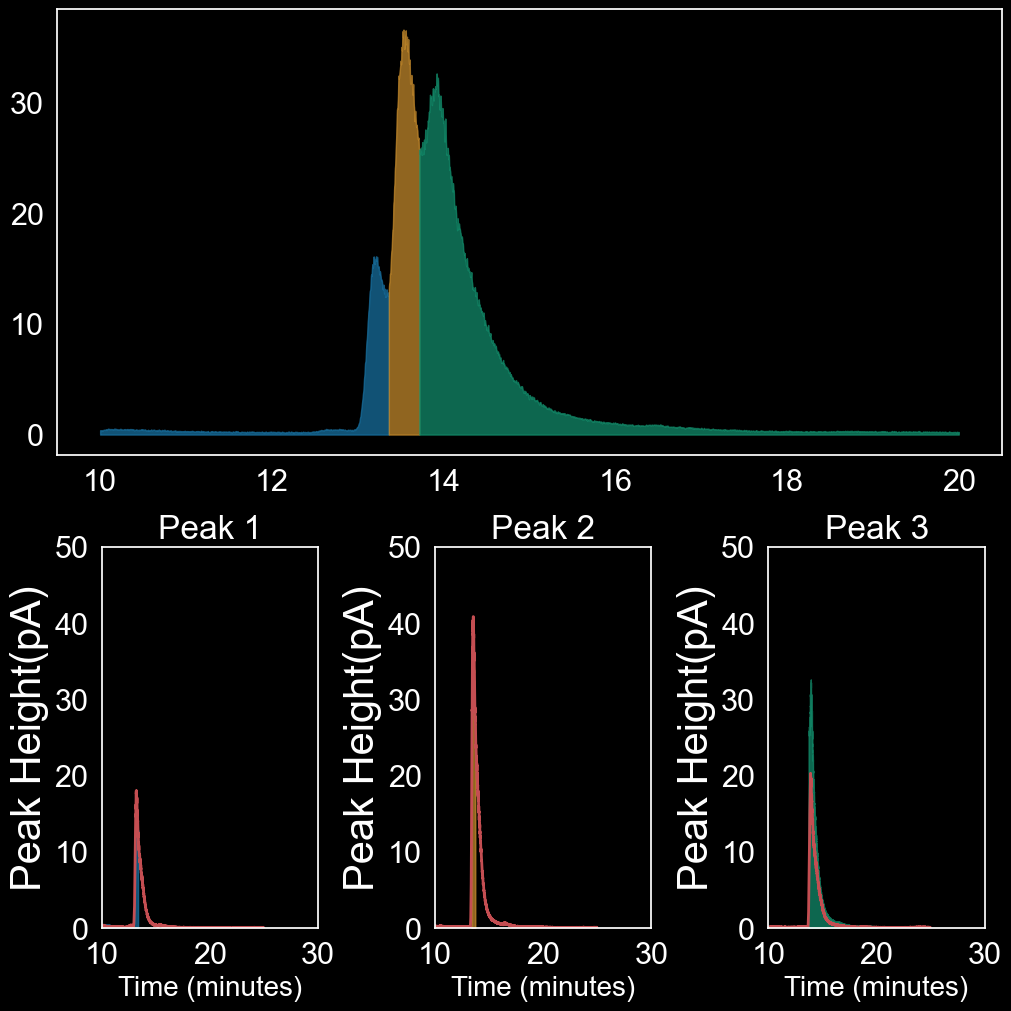

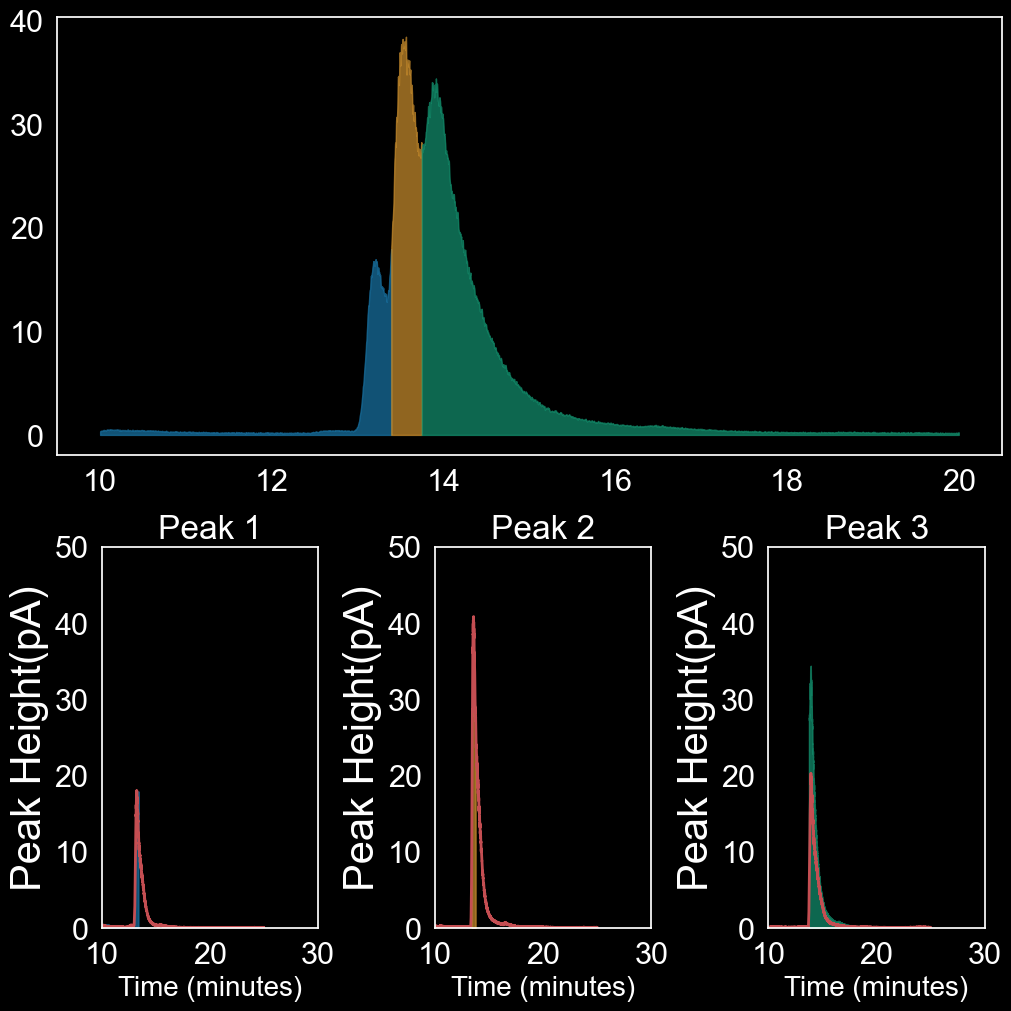

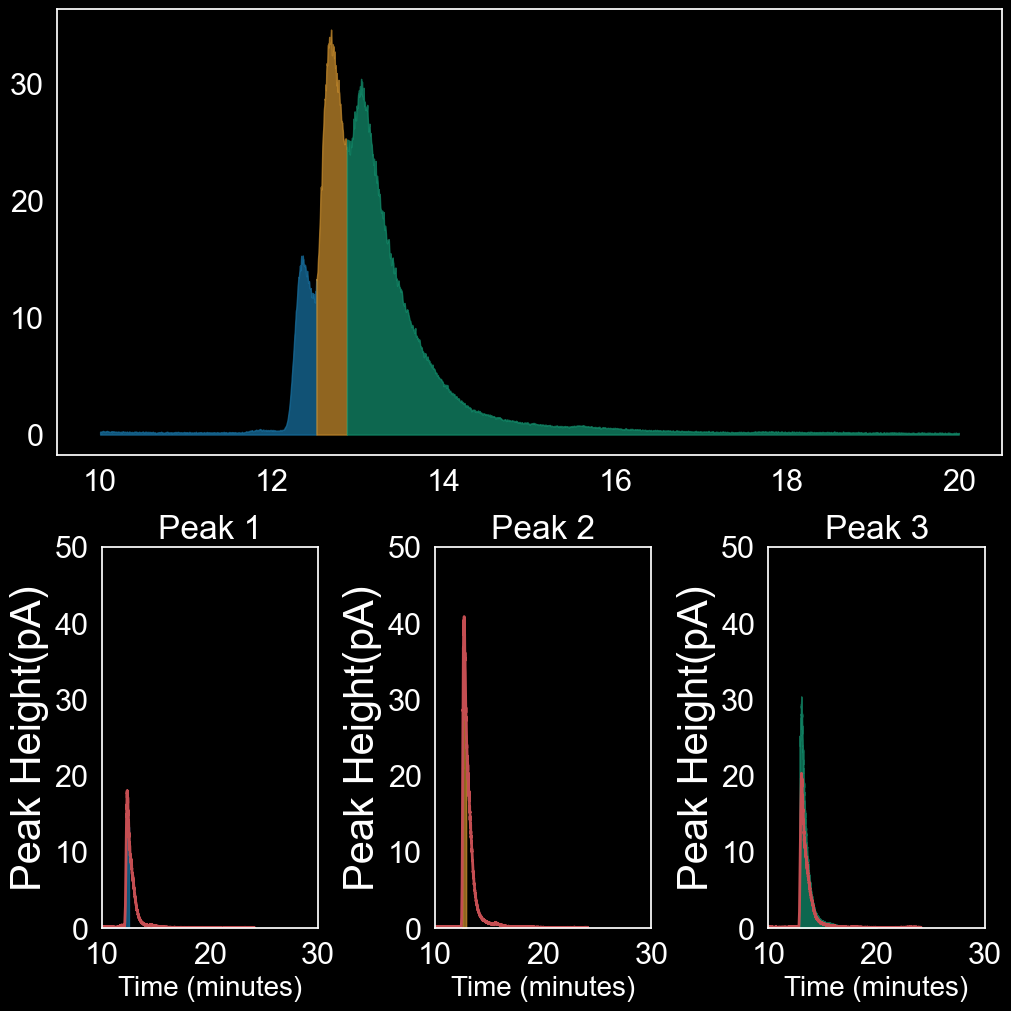

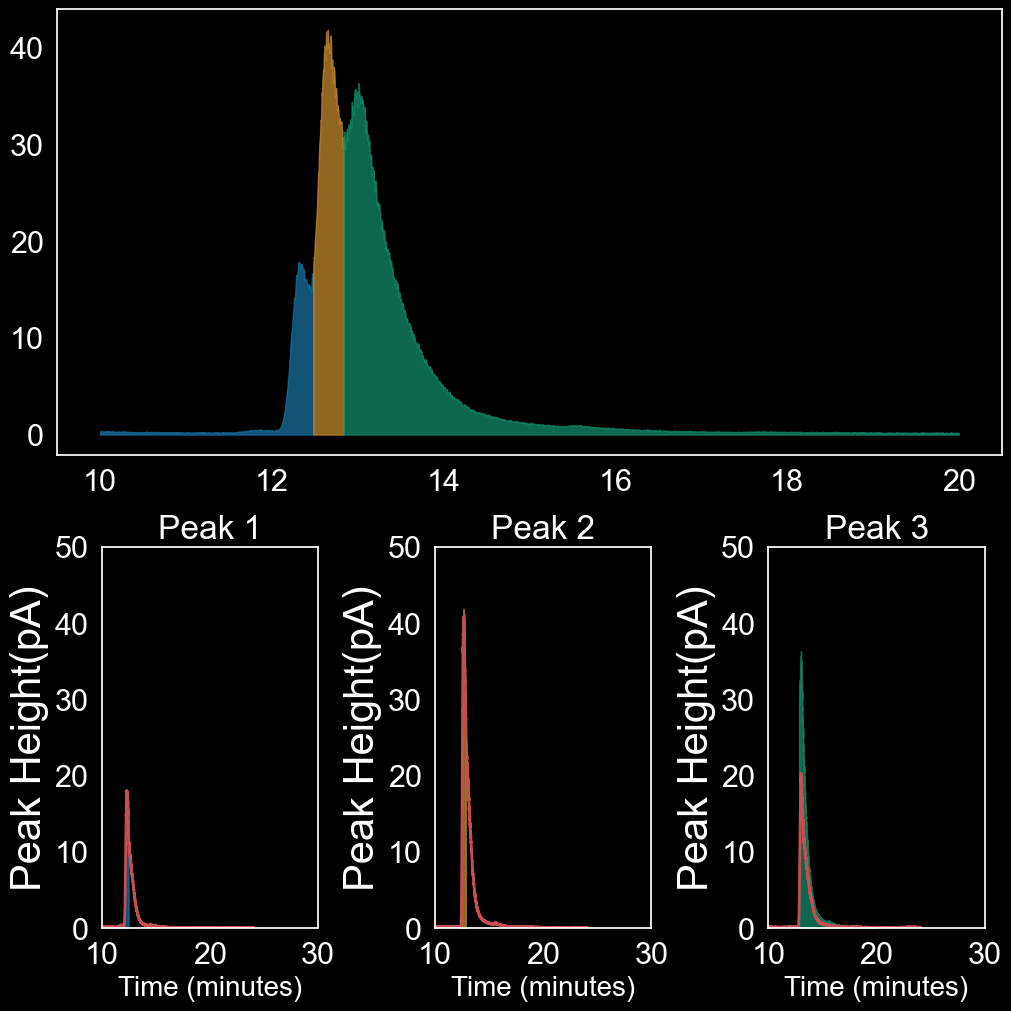

In [6]:
#valley-to-valley
rmse_list=[]
for name in ["la_spike3","la_spike2","la_spike1",
            "equal1","equal2","equal3","equal4",
             "dha_spike1","dha_spike2","dha_spike3",
            "ara_spike1","ara_spike2","ara_spike3","ara_spike4"]:
    
    x=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']==name)]['Time']
    y=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']==name)]['Value']
    peak_size=[10,10,10]
    if "la_spike" in name:
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone10_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone10_4")]['Value']
        peak_size=[10,10,20]
    elif "equal" in name: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
    elif "ara" in name: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone10_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone10_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
        peak_size=[10,20,10]
    else: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone10_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone10_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
        peak_size=[20,10,10]

    #z=remove_noise(y,2000,1e11,20)
    df = pd.DataFrame()
    shift=(-1*x[y.idxmax()]+j[k.idxmax()])
    if "ara" in name:
        shift=(-1*x[y.idxmax()]+z[w.idxmax()])
    centers=[p[q.idxmax()]-shift,z[w.idxmax()]-shift,j[k.idxmax()]-shift]
    
        
    p=p-shift
    z=z-shift
    j=j-shift
    starts=[10,(centers[0]+centers[1])/2,(centers[1]+centers[2])/2]
    ends=[(centers[0]+centers[1])/2,(centers[1]+centers[2])/2,20]
    fig=plt.figure(constrained_layout=True,figsize=(10,10))
    subplots=fig.subfigures(2,1)
    ax1=subplots[0].subplots(1,1)
    ax2=subplots[1].subplots(1,3)


    colors=['#176E9D','#C2882B','#128B6A']
    ax2[0].plot(p,q,color='r',linewidth=2)
    ax2[1].plot(z,w,color='r',linewidth=2)
    ax2[2].plot(j,k,color='r',linewidth=2)
    sub_list=[q,w,k]
    for n in range(0,3):
        ax1.fill_between(x, y, alpha=0.75,color=colors[n],where=((x>starts[n])&(x<ends[n])))
        ax2[n].fill_between(x, y, alpha=0.75,color=colors[n],where=((x>starts[n])&(x<ends[n]))) 
        summm=0
        for a, b,c in zip(sub_list[n],y,x):
            if c>starts[n] and c<ends[n]:
                summm+=(a-b)*(a-b)
            else:
                summm+=a*a
        rmse_list.append({"Peak Number":n+1,"RMSE":math.sqrt(summm/len(sub_list[n]))/(peak_size[n]/10),"Algorithm":"Valley-to-Valley","Peak Mass(ug)":peak_size[n]})
        #adds peak location on the actual output graph 
        #ax.text(out.params['p'+str(n)+"_center"].value, out.params['p'+str(n)+"_amplitude"].value+1, str(out.params['p'+str(n)+"_center"].value)[0:5], fontsize=8,horizontalalignment='center')
        #calculates the area which is amplitude(SD)/(1/sqrt(2*pi))
        area=sum(comps['p'+str(n)+"_"])*0.01
        ax2[n].set_xlabel("Time (minutes)",size=20)
        ax2[n].set_ylabel("Peak Height(pA)",size=30)
        ax2[n].set(ylim=[0,50])
        ax2[n].set(xlim=[10,30])
        ax2[n].set_title("Peak "+str(n+1))
        #ax2[n].text(centers[n]+1,20, str(centers2[n]), fontsize = 22)
    plt.show()


valley_error=pd.DataFrame(rmse_list) 


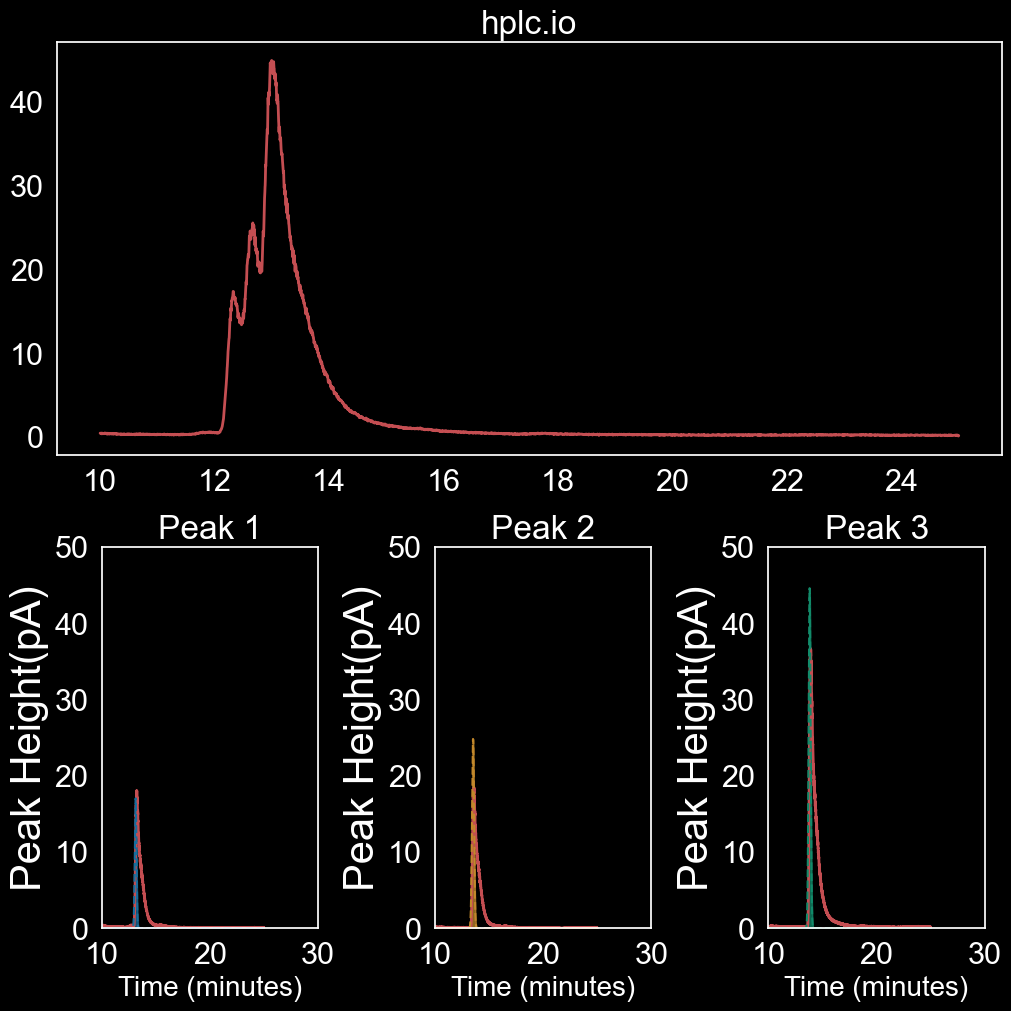

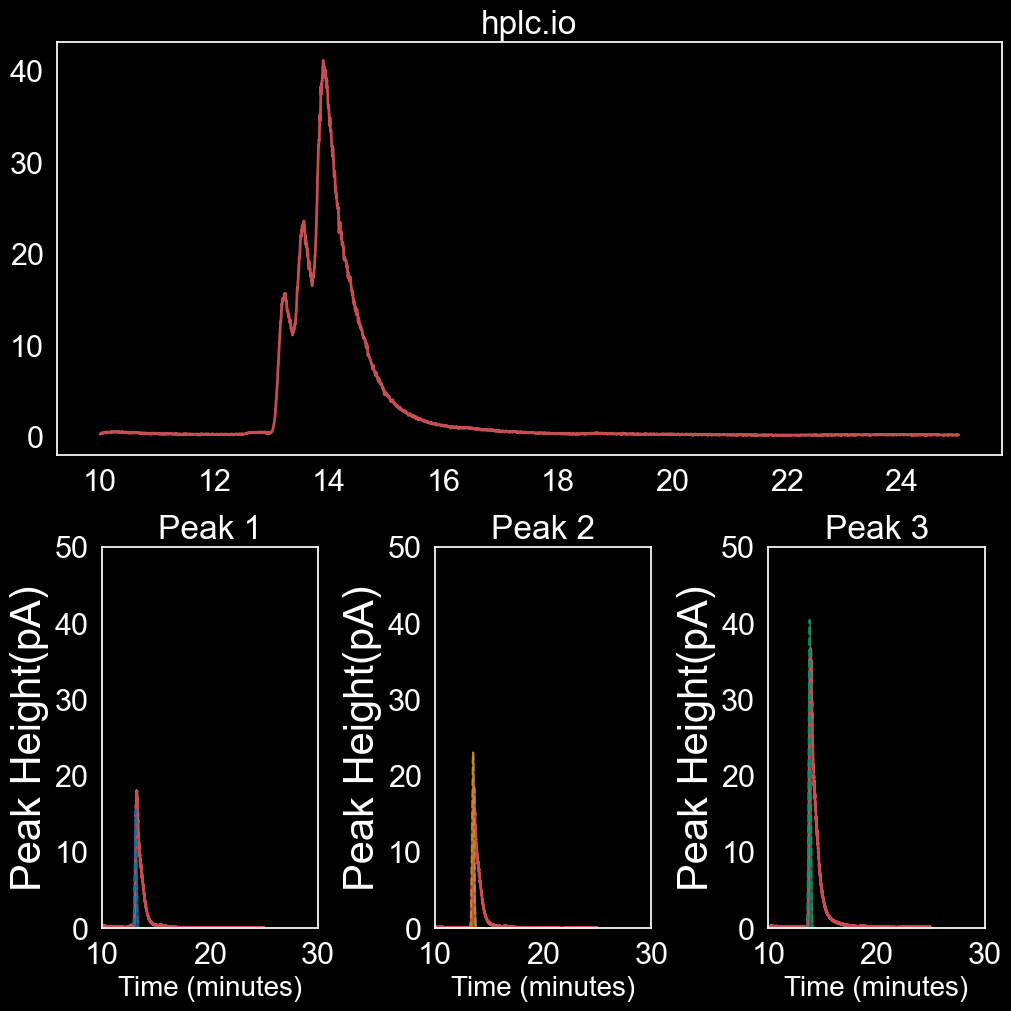

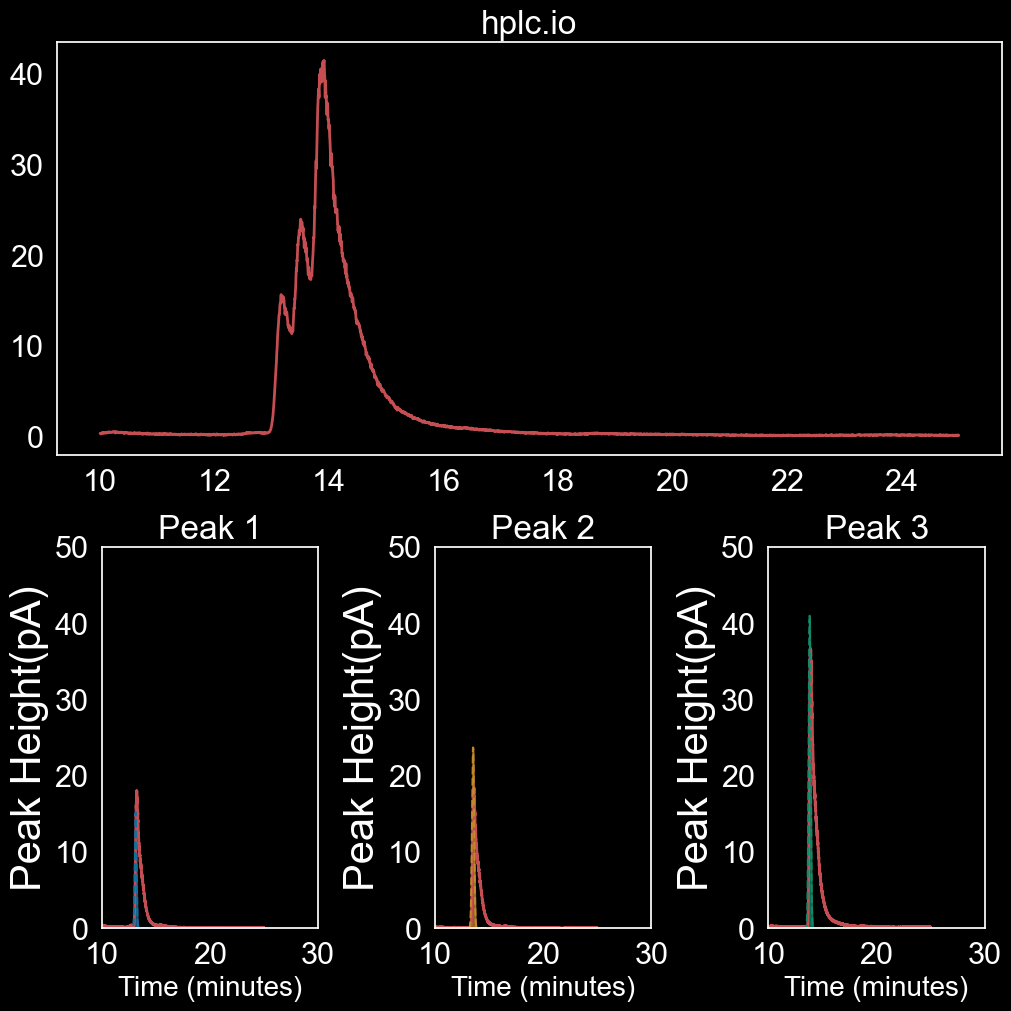

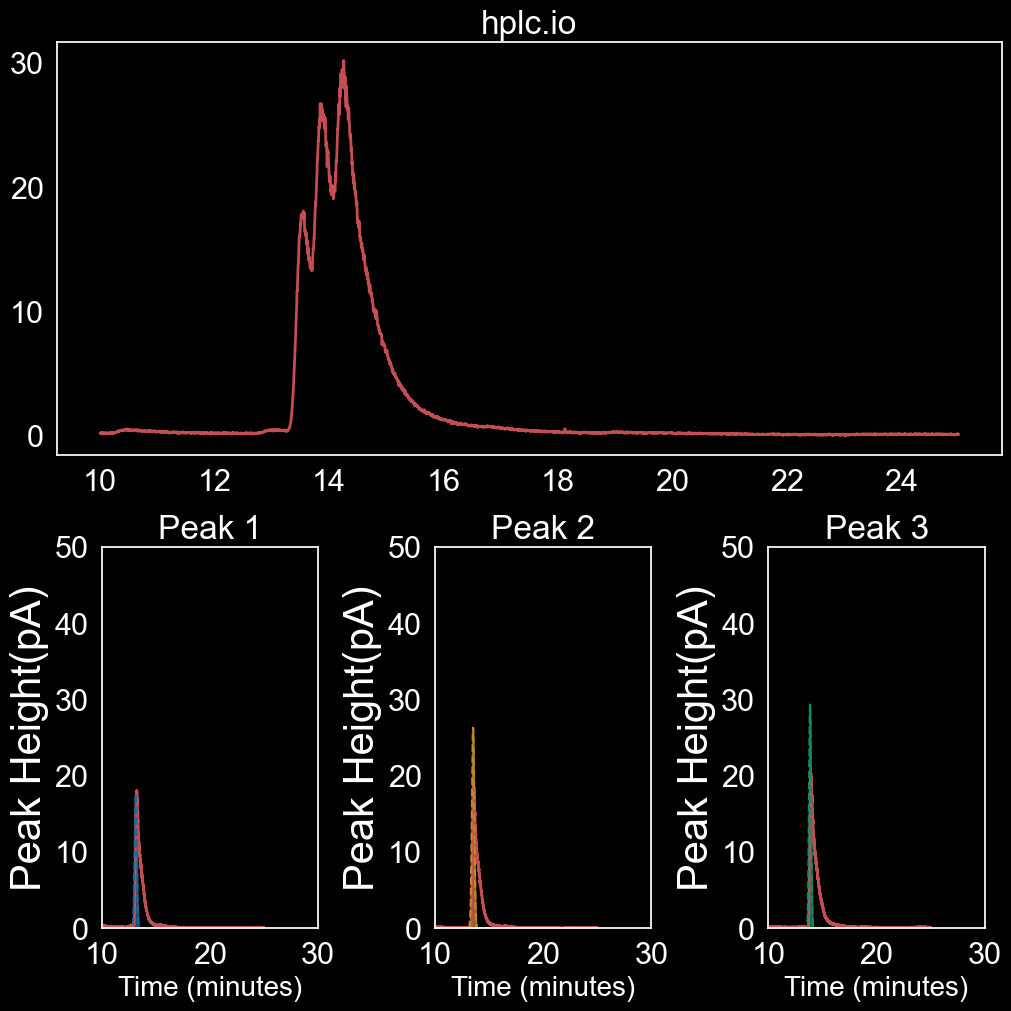

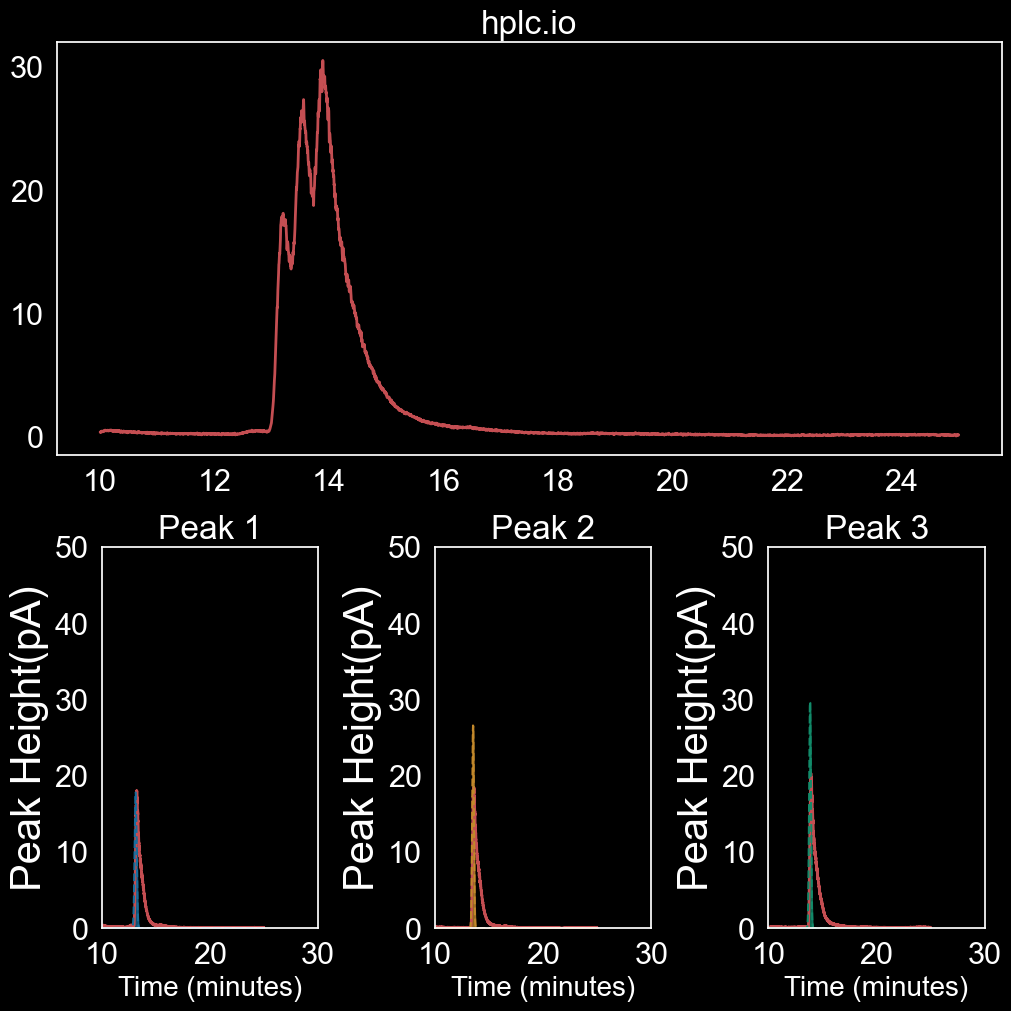

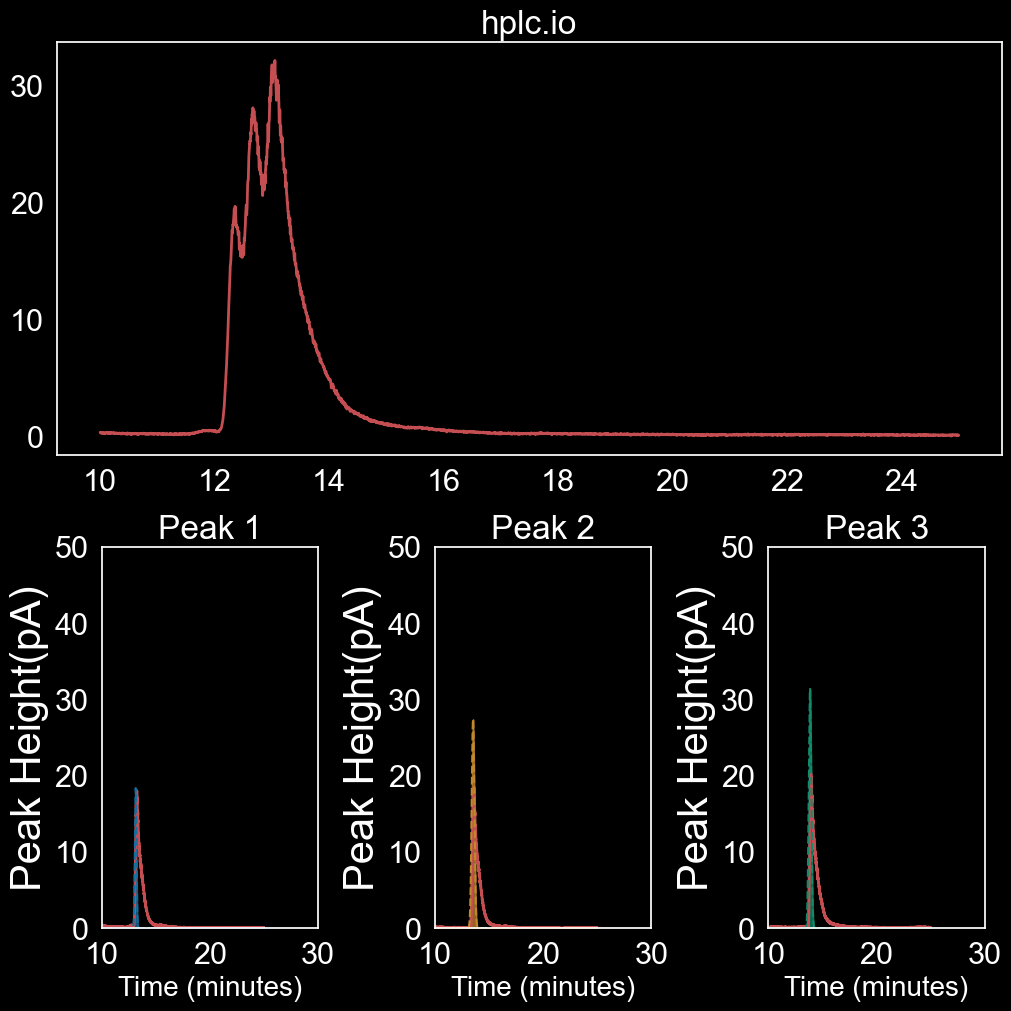

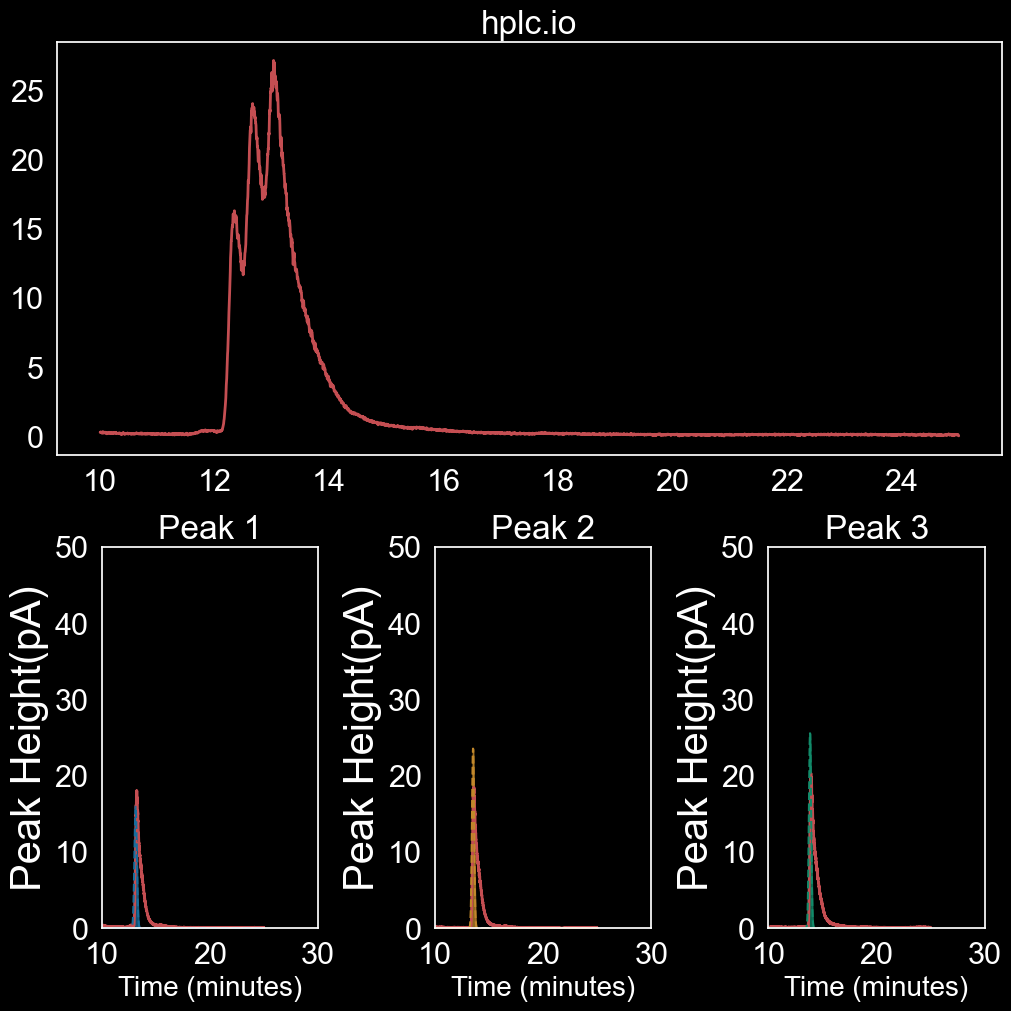

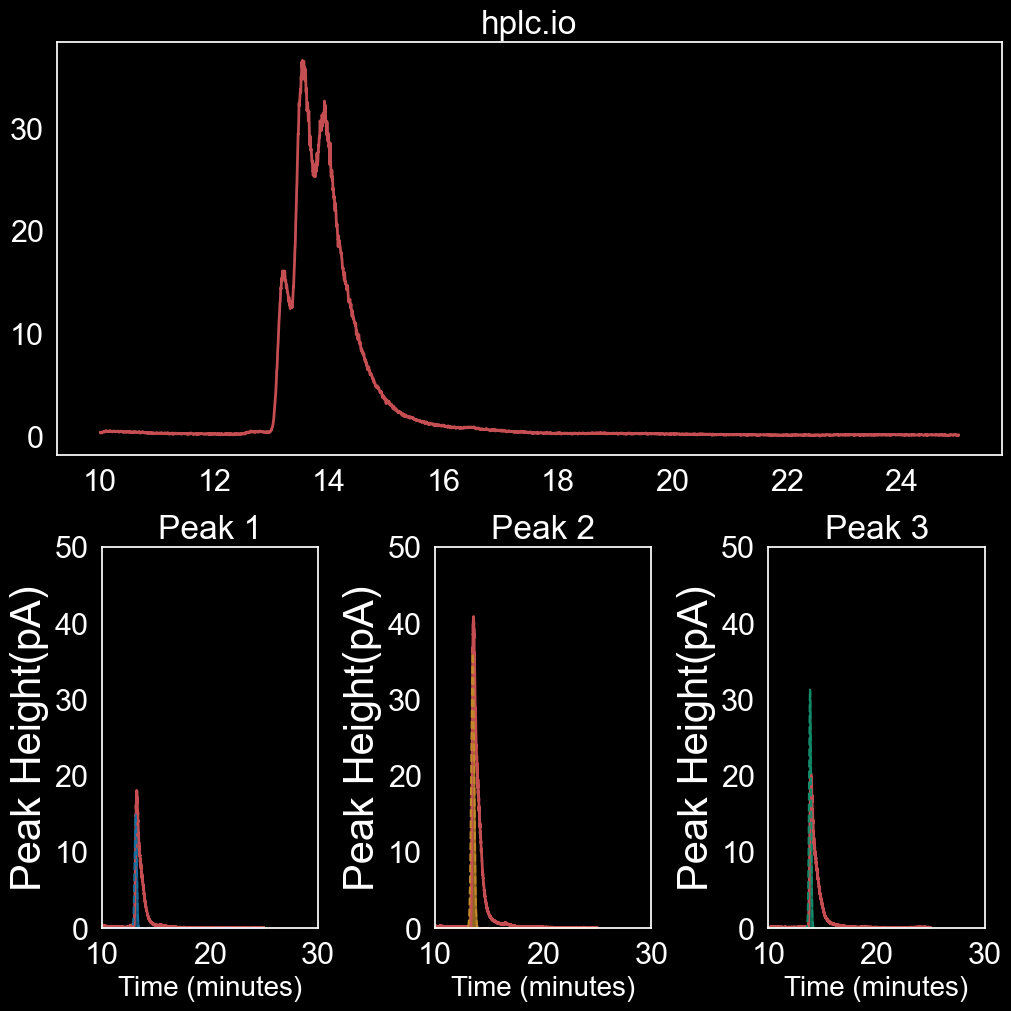

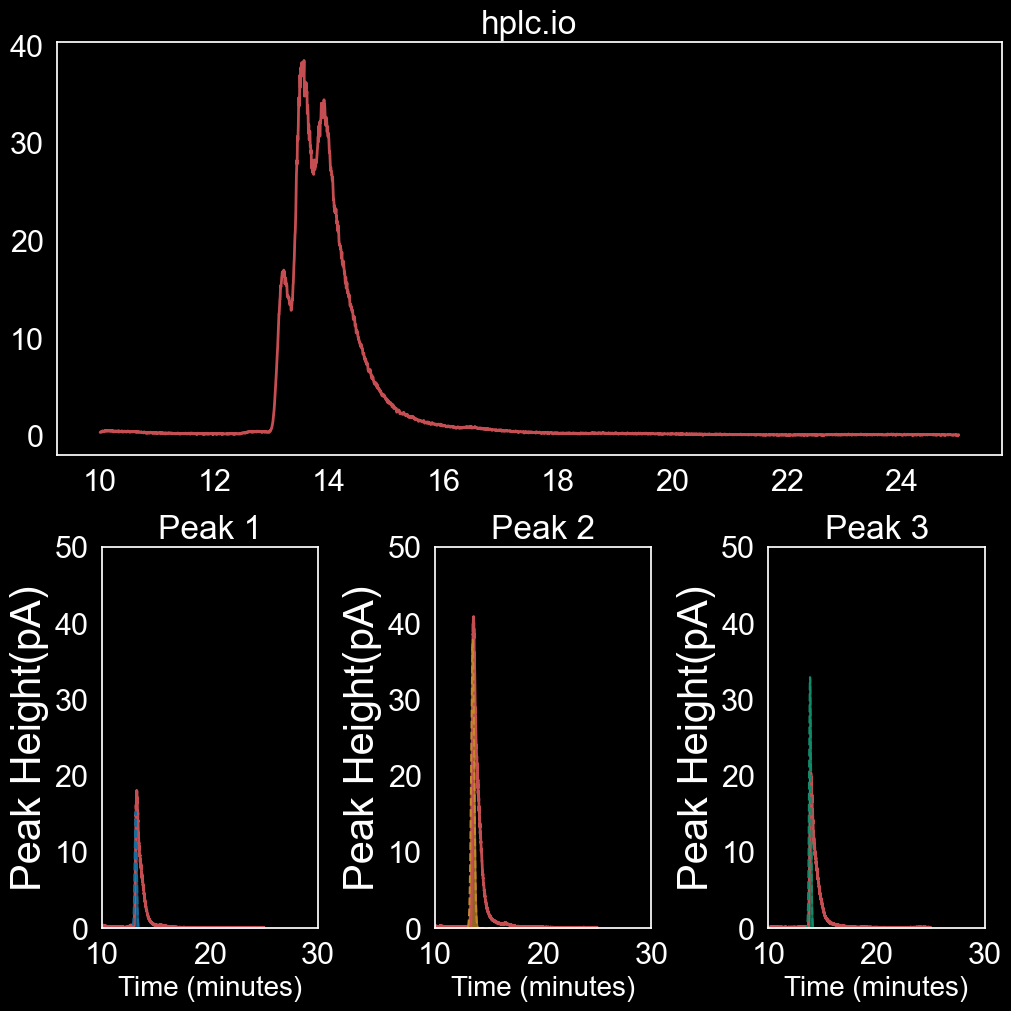

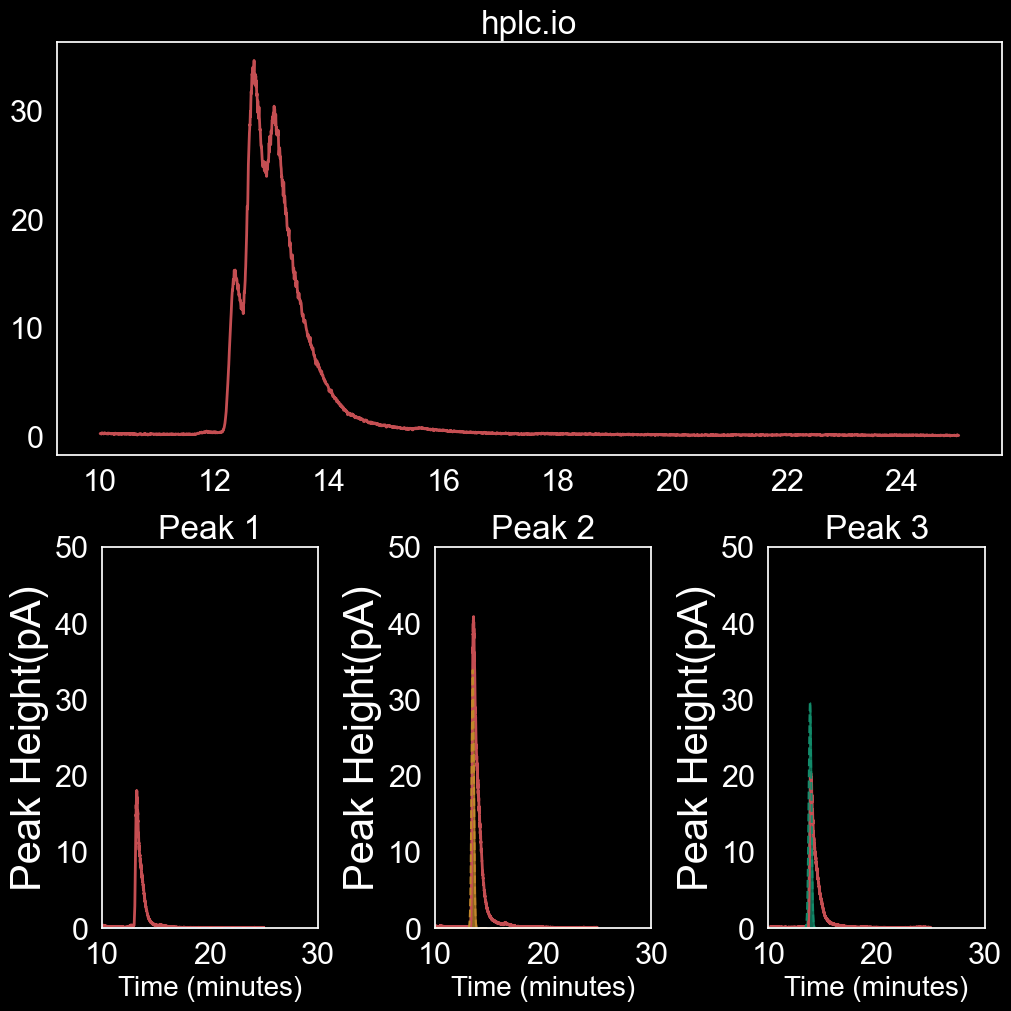

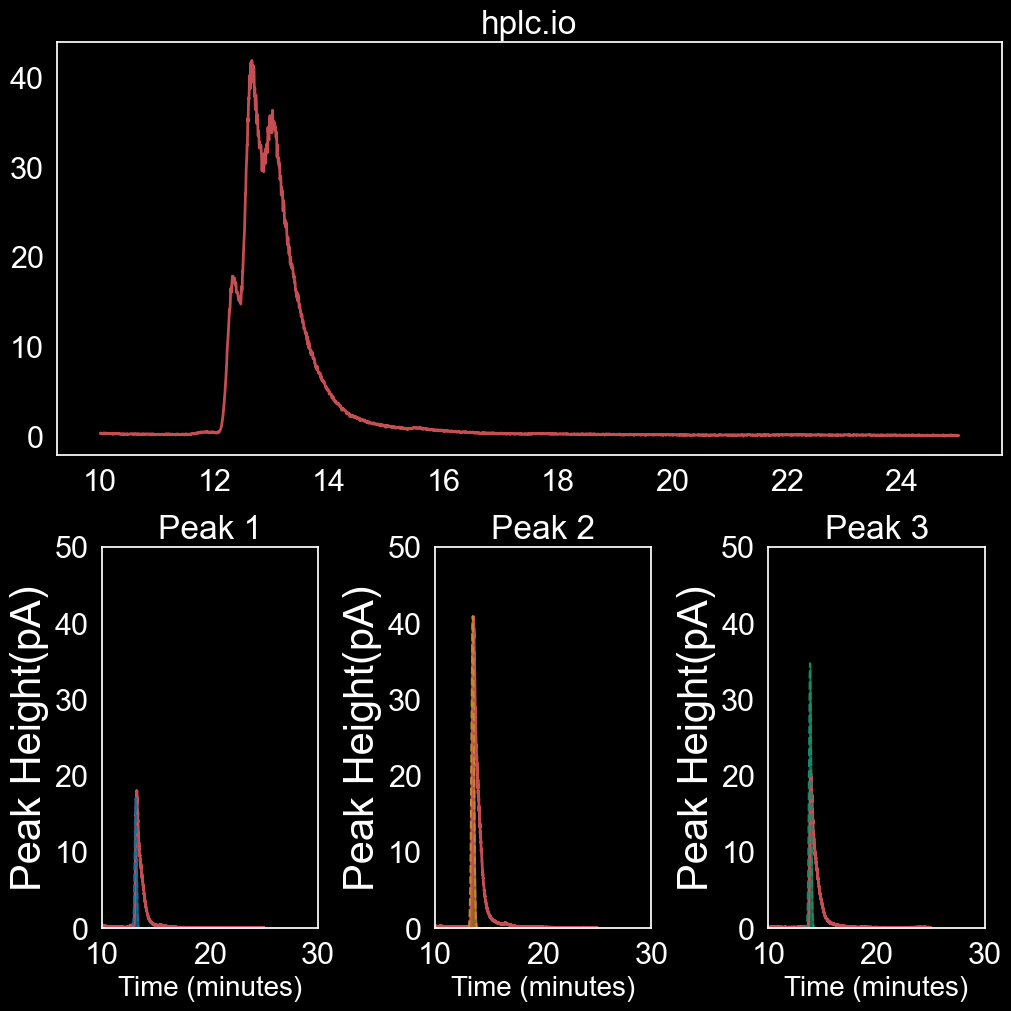

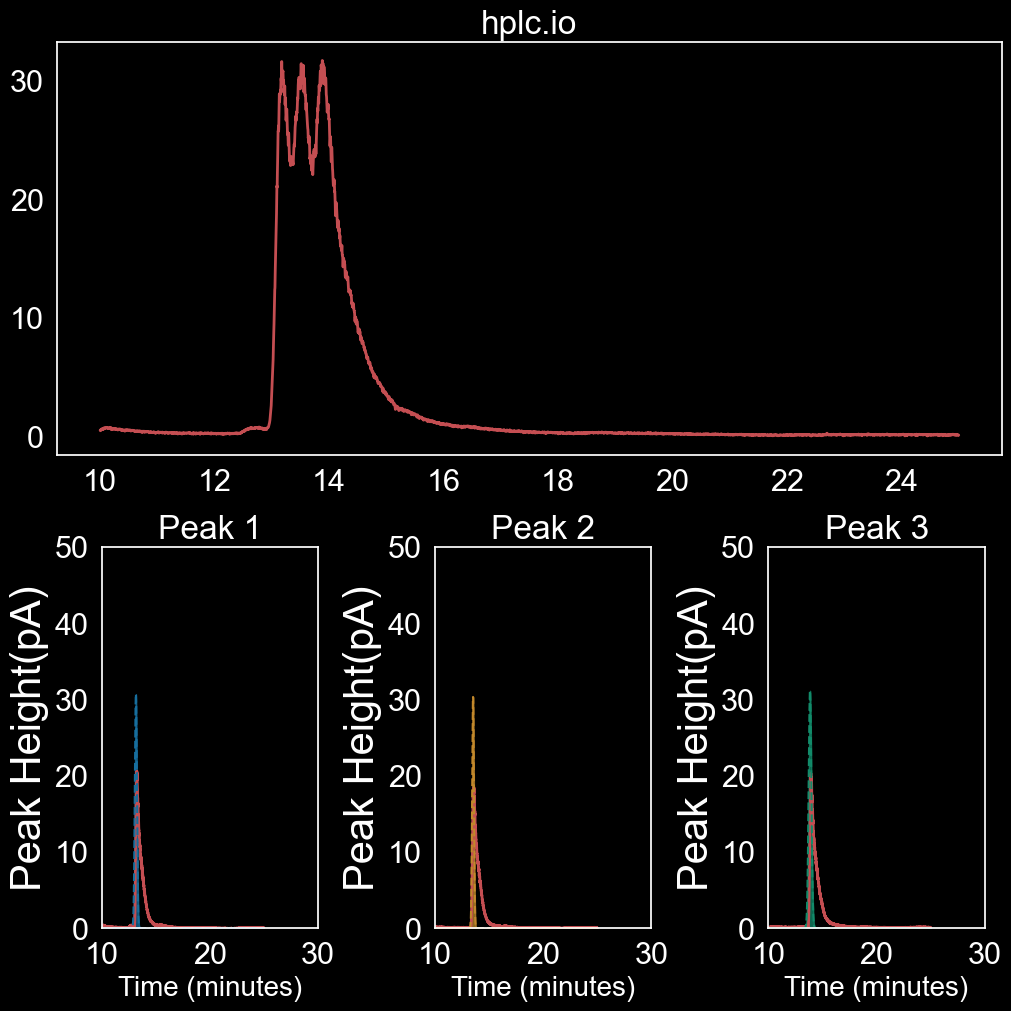

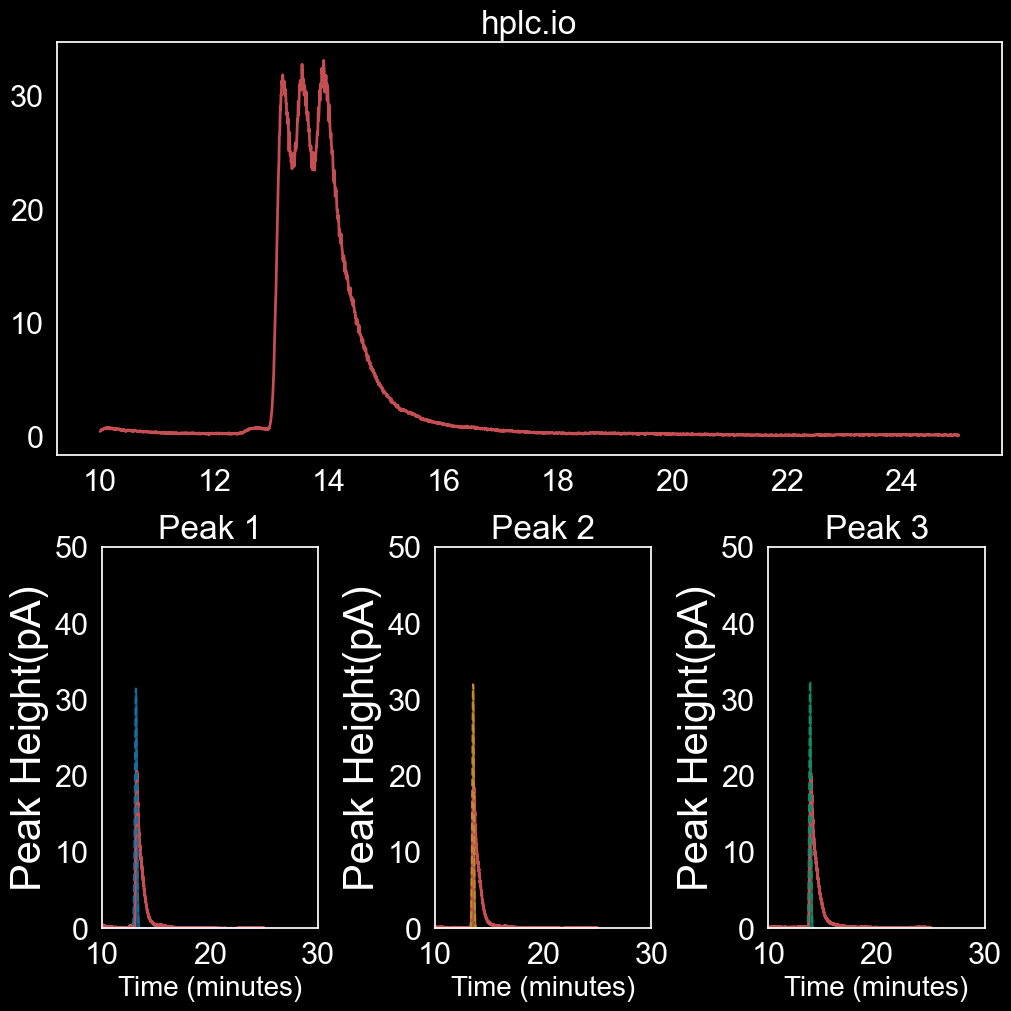

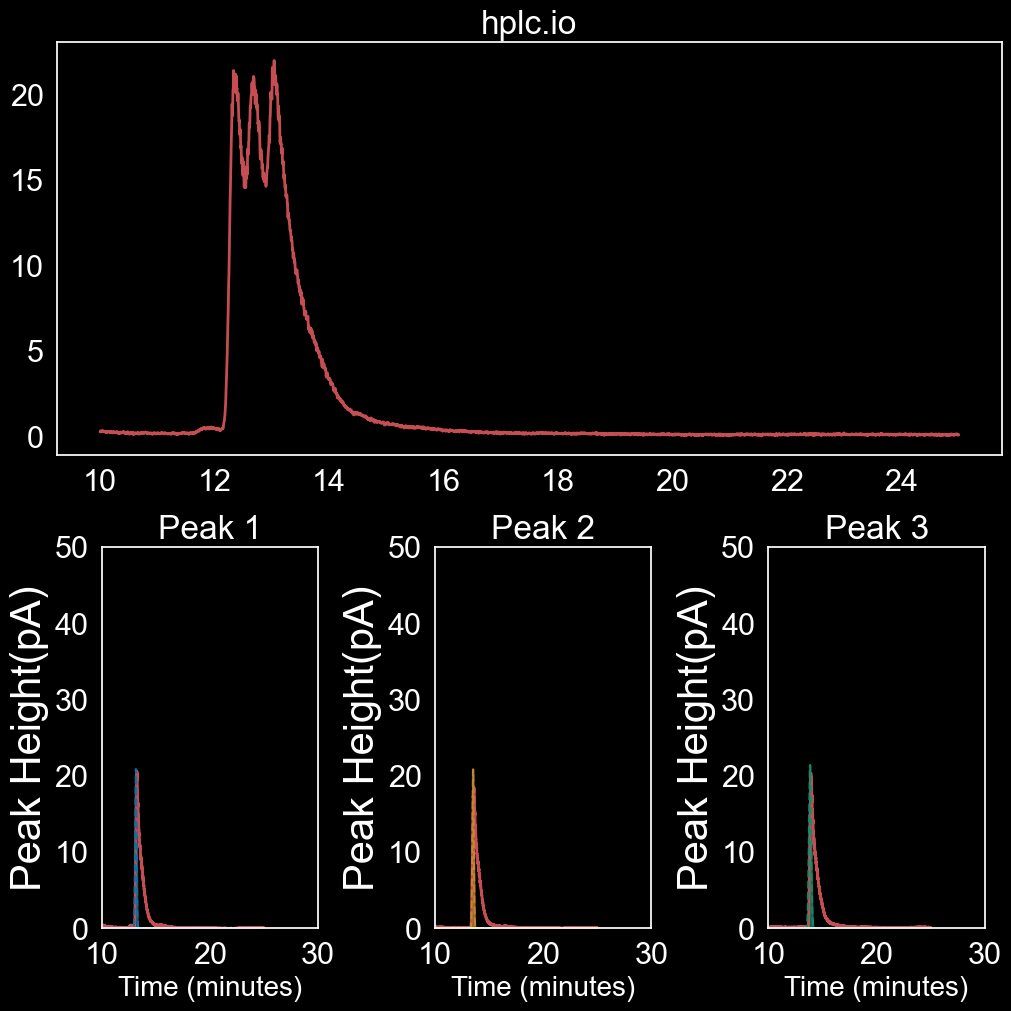

In [7]:
#happy tools
rmse_list=[]
parameters=pd.read_excel("happy_tools.xlsx")
for name in ["la_spike3","la_spike2","la_spike1",
            "equal1","equal2","equal3","equal4",
            "ara_spike1","ara_spike2","ara_spike3","ara_spike4",
            "dha_spike1","dha_spike2","dha_spike3"]:
    
    x=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']==name)]['Time']
    y=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']==name)]['Value']
    peak_size=[10,10,10]
    if "la_spike" in name:
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone10_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone10_4")]['Value']
        peak_size=[10,10,20]
    elif "equal" in name: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
    elif "ara" in name: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone5_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone10_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone10_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
        peak_size=[10,20,10]
    else: 
        p=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone10_4")]['Time']
        q=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="dha_alone10_4")]['Value']


        z=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Time']
        w=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="ara_alone5_4")]['Value']

        j=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Time']
        k=hplcz.loc[(hplcz['Time']>=10) & (hplcz['Time']<=25)& (hplcz['Name']=="la_alone5_4")]['Value']
        peak_size=[20,10,10]
    #z=remove_noise(y,2000,1e11,20)
    df = pd.DataFrame()
    centers=[p[q.idxmax()-50],z[w.idxmax()-50],j[k.idxmax()-50]]
    #centers_r=[]
    sigmas=[]
    amplitudes=[]
    gamma=[]
    for i in (1,2,3):
        #centers_r.append(float(parameters[(parameters["Name"]==name)&(parameters["Peak"]==i)]["center"]))
        sigmas.append(float(parameters[(parameters["Name"]==name)&(parameters["Peak"]==i)]["sigma"]))
        amplitudes.append(float(parameters[(parameters["Name"]==name)&(parameters["Peak"]==i)]["Height"])*float(parameters[(parameters["Name"]==name)&(parameters["Peak"]==i)]["sigma"])*math.sqrt(2*math.pi))

    model=''
    for n in range(0,3):
        gaus=GaussianModel(prefix='p'+str(n)+"_")
        #addition of first model for first peak
        if model=='':
            model=gaus
            pars=gaus.make_params(prefix='p'+str(n)+"_")
            #peak locations can vary by 1 min 
            pars['p'+str(n)+'_center'].set(value=centers[n],vary=False)
            #sigma can only be so large and small 
            pars['p'+str(n)+'_sigma'].set(value=sigmas[n],vary=False)
            #amplitude can only be so small to be a real peak 
            pars['p'+str(n)+'_amplitude'].set(value=amplitudes[n],vary=False)

        #all subsequent peaks    
        else:
            model+=gaus
            pars.update(gaus.make_params(prefix='p'+str(n)+"_"))
            pars['p'+str(n)+'_center'].set(value=centers[n],vary=False)
            pars['p'+str(n)+'_sigma'].set(value=sigmas[n],vary=False)
            pars['p'+str(n)+'_amplitude'].set(value=amplitudes[n],vary=False)
    
    init = model.eval(pars, x=x)
    out = model.fit(y, pars, x=x)

    comps=out.eval_components(x=x)

    fig=plt.figure(constrained_layout=True,figsize=(10,10))
    subplots=fig.subfigures(2,1)
    ax1=subplots[0].subplots(1,1)
    ax2=subplots[1].subplots(1,3)
    colors=['#176E9D','#C2882B','#128B6A']
    ax2[0].plot(p,q,color='r',linewidth=2)
    ax2[1].plot(z,w,color='r',linewidth=2)
    ax2[2].plot(j,k,color='r',linewidth=2)
    ax1.plot(x,y,color='r',linewidth=2)
    sub_list=[q,w,k]
    for n in range(0,3):
        #ax1.plot(x, comps2['p'+str(n)+"_"], '--', label='Gaussian component '+str(n),color=colors[n])
        #ax1.fill_between(x, comps2['p'+str(n)+"_"].min(), comps2['p'+str(n)+"_"], alpha=0.75,color=colors[n])
        ax2[n].plot(x, comps['p'+str(n)+"_"], '--', label='Gaussian component '+str(n),color=colors[n])
        ax2[n].fill_between(x, comps['p'+str(n)+"_"].min(), comps['p'+str(n)+"_"], alpha=0.75,color=colors[n]) 
        summm=0
        for a, b in zip(sub_list[n],comps['p'+str(n)+"_"]):

           summm+=(a-b)*(a-b)
        rmse_list.append({"Peak Number":n+1,"RMSE":math.sqrt(summm/len(sub_list[n]))/(peak_size[n]/10),"Algorithm":"happytools","Peak Mass(ug)":peak_size[n]})
        #adds peak location on the actual output graph 
        #ax.text(out.params['p'+str(n)+"_center"].value, out.params['p'+str(n)+"_amplitude"].value+1, str(out.params['p'+str(n)+"_center"].value)[0:5], fontsize=8,horizontalalignment='center')
        #calculates the area which is amplitude(SD)/(1/sqrt(2*pi))
        area=sum(comps['p'+str(n)+"_"])*0.01
        ax2[n].set_xlabel("Time (minutes)",size=20)
        ax2[n].set_ylabel("Peak Height(pA)",size=30)
        ax2[n].set(ylim=[0,50])
        ax2[n].set(xlim=[10,30])
        ax2[n].set_title("Peak "+str(n+1))
        ax1.set_title("hplc.io")
        #ax2[n].text(centers[n]+1,20, str(centers2[n]), fontsize = 22)


happytools_error=pd.DataFrame(rmse_list)   
plt.show()

In [8]:
total=pd.concat([peakclimber_error,hplc_error,happytools_error,valley_error])

In [9]:
total

Peak Number      RMSE         Algorithm  Peak Mass(ug)
0             1  0.453618       PeakClimber             10
1             2  0.686050       PeakClimber             10
2             3  0.502509       PeakClimber             20
3             1  0.703990       PeakClimber             10
4             2  0.807359       PeakClimber             10
..          ...       ...               ...            ...
37            2  3.796916  Valley-to-Valley             20
38            3  5.273433  Valley-to-Valley             10
39            1  3.370773  Valley-to-Valley             10
40            2  4.084663  Valley-to-Valley             20
41            3  6.237449  Valley-to-Valley             10

[168 rows x 4 columns]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PeakClimber_3 v.s. hplc.io_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.674e-02 U_stat=3.500e+01
PeakClimber_1 v.s. hplc.io_1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.326e-03 U_stat=2.000e+01
PeakClimber_2 v.s. hplc.io_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.334e-03 U_stat=1.800e+01
PeakClimber_1 v.s. happytools_1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.721e-05 U_stat=0.000e+00
PeakClimber_2 v.s. happytools_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.721e-05 U_stat=0.000e+00
PeakClimber_3 v.s. happytools_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.721e-05 U_stat=0.000e+00
PeakClimber_1 v.s. Valley-to-Valley_1: Mann-Whitney-Wilcoxo

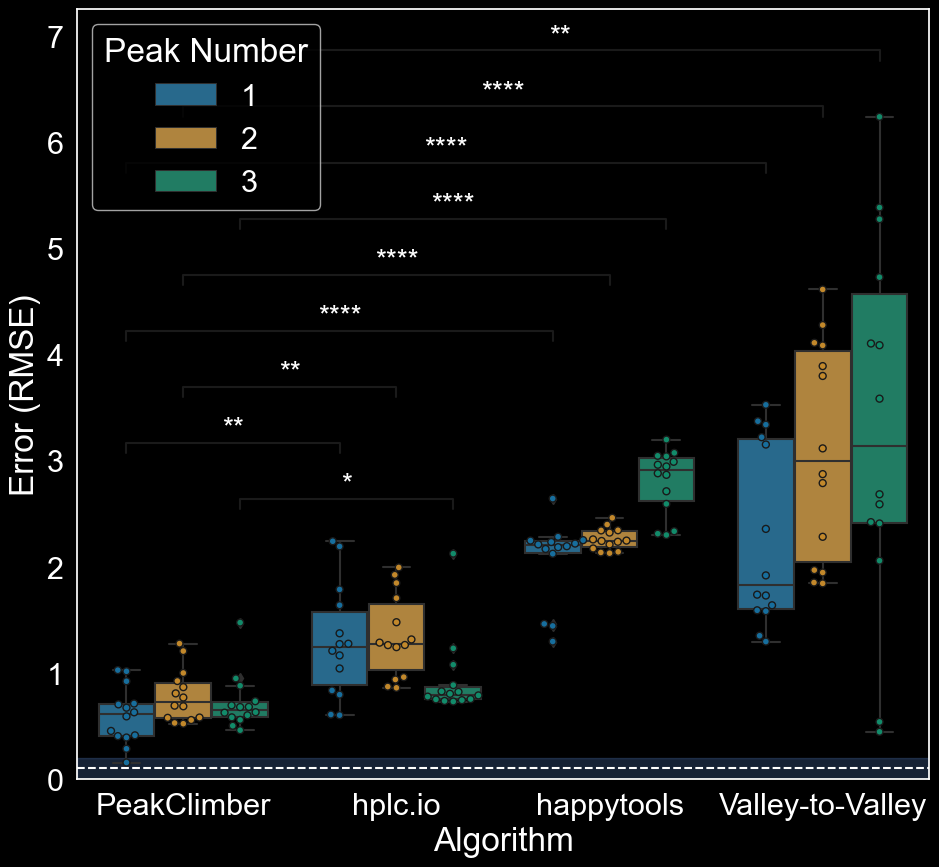

In [10]:
fig,ax=plt.subplots(1,1,figsize=(11,10))
colors=['#176E9D','#C2882B','#128B6A']
sns.boxplot(data=total,x="Algorithm",y="RMSE",hue="Peak Number",ax=ax,palette=colors)
sns.swarmplot(data=total,x="Algorithm",y="RMSE",hue="Peak Number",legend=False,ax=ax,dodge=True,palette=colors,edgecolor='k',linewidth=1)
ax.set(ylim=[0,5])
box_pairs=[
    (("PeakClimber",1),("hplc.io",1)),
    (("PeakClimber",2),("hplc.io",2)),
    (("PeakClimber",3),("hplc.io",3)),
    (("PeakClimber",1),("happytools",1)),
    (("PeakClimber",2),("happytools",2)),
    (("PeakClimber",3),("happytools",3)),
    (("PeakClimber",1),("Valley-to-Valley",1)),
    (("PeakClimber",2),("Valley-to-Valley",2)),
    (("PeakClimber",3),("Valley-to-Valley",3))
]
add_stat_annotation(ax=ax,data=total, x="Algorithm", y='RMSE', hue="Peak Number",
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2,color='k',fontsize=20)
ax.axhline(0.1, ls='--')
plt.legend(loc='upper left',title="Peak Number")
ax.set(ylabel="Error (RMSE)")
ax.axhspan(ymin=0,ymax=0.2, alpha=0.3,color='b')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PeakClimber_3 v.s. hplc.io_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.674e-02 U_stat=3.500e+01
PeakClimber_1 v.s. hplc.io_1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.326e-03 U_stat=2.000e+01
PeakClimber_2 v.s. hplc.io_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.334e-03 U_stat=1.800e+01
PeakClimber_1 v.s. happytools_1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.721e-05 U_stat=0.000e+00
PeakClimber_2 v.s. happytools_2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.721e-05 U_stat=0.000e+00
PeakClimber_3 v.s. happytools_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.721e-05 U_stat=0.000e+00
PeakClimber_1 v.s. Valley-to-Valley_1: Mann-Whitney-Wilcoxo

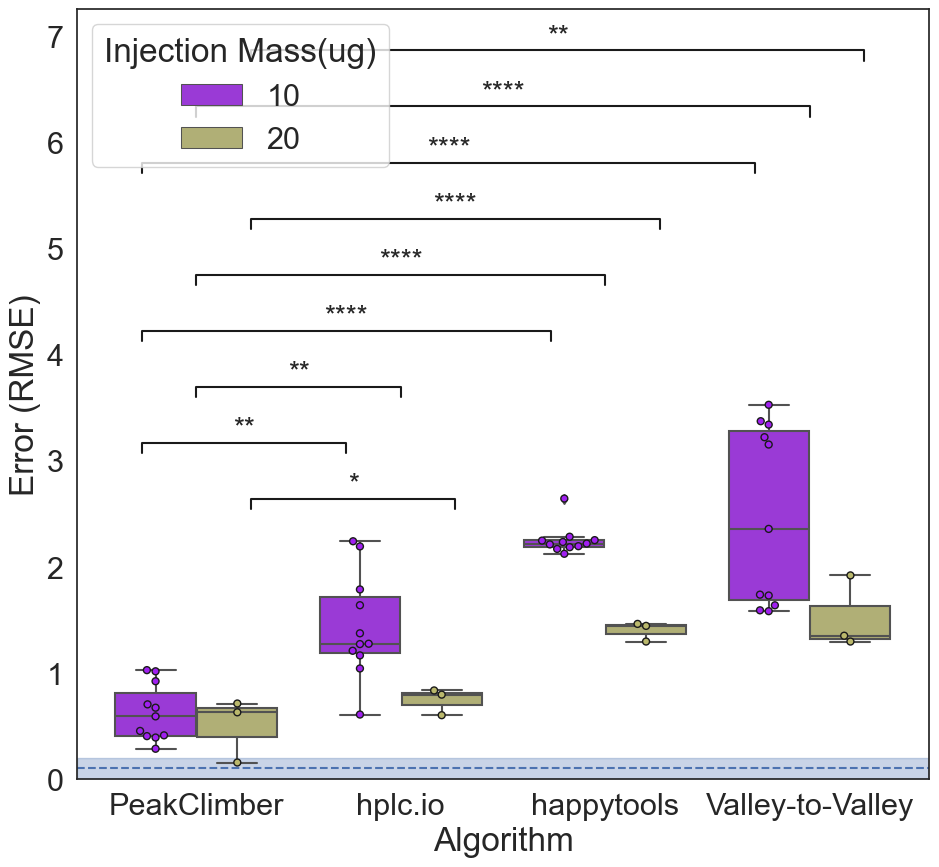

In [14]:
fig,ax=plt.subplots(1,1,figsize=(11,10))
colors=['#A020F0','#BAB86C']
sns.boxplot(data=total[total["Peak Number"]==1],x="Algorithm",y="RMSE",hue="Peak Mass(ug)",ax=ax,palette=colors)
sns.swarmplot(data=total[total["Peak Number"]==1],x="Algorithm",y="RMSE",hue="Peak Mass(ug)",legend=False,ax=ax,dodge=True,palette=colors,edgecolor='k',linewidth=1)
ax.set(ylim=[0,5])
box_pairs=[
    (("PeakClimber",1),("hplc.io",1)),
    (("PeakClimber",2),("hplc.io",2)),
    (("PeakClimber",3),("hplc.io",3)),
    (("PeakClimber",1),("happytools",1)),
    (("PeakClimber",2),("happytools",2)),
    (("PeakClimber",3),("happytools",3)),
    (("PeakClimber",1),("Valley-to-Valley",1)),
    (("PeakClimber",2),("Valley-to-Valley",2)),
    (("PeakClimber",3),("Valley-to-Valley",3))
]
add_stat_annotation(ax=ax,data=total, x="Algorithm", y='RMSE', hue="Peak Number",
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2,color='k',fontsize=20)
ax.axhline(0.1, ls='--')
plt.legend(loc='upper left',title="Injection Mass(ug)")
ax.set(ylabel="Error (RMSE)")
ax.axhspan(ymin=0,ymax=0.2, alpha=0.3,color='b')
plt.show()